<a href="https://colab.research.google.com/github/womaro/SimlationOfQubit/blob/main/Kopia_notatnika_QuantumQubitTransmitionSimilation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Classical Cost of Transmitting a Qubit: Protocol Visualization and Simulation**

**Introduction to the Research**

The simulation code implements the groundbreaking protocol described in the paper "Classical Cost of Transmitting a Qubit" by Renner, Tavakoli, and Quintino. This research addresses a fundamental question in quantum information theory: what is the minimum number of classical bits needed to perfectly simulate the transmission of a quantum bit (qubit)?
The authors prove a remarkable result—exactly two classical bits are both necessary and sufficient to simulate all possible correlations that could be obtained by transmitting a qubit, even when the receiver can perform the most general quantum measurements possible (POVMs). This result extends the previous work by Toner and Bacon, which only covered the more restricted case of projective measurements.

**The Classical Simulation Protocol**

ny quantum state to Bob using only two classical bits, along with pre-shared randomness. Here's how it works:

1. Shared Randomness Setup: Alice and Bob share two normalized random vectors λ₁ and λ₂ uniformly distributed on the unit sphere in 3D space (represented by the Bloch sphere).
2. Classical Communication: Instead of sending a quantum state ρ (represented as a point on the Bloch sphere), Alice calculates and sends two bits:

c₁ = H(ρ·λ₁) and c₂ = H(ρ·λ₂)
where H is the Heaviside function (H(z) = 1 if z ≥ 0, and H(z) = 0 if z < 0)


3. Vector Transformation: Bob transforms the shared vectors based on the received bits:

If c₁ = 0, Bob flips λ₁ → -λ₁; otherwise, he leaves it unchanged
If c₂ = 0, Bob flips λ₂ → -λ₂; otherwise, he leaves it unchanged


4. Measurement Simulation: When Bob needs to perform a measurement corresponding to some POVM elements, he uses these transformed vectors to compute the correct probabilities for each outcome.

The visualization in this simulation shows exactly how the Heaviside function creates a hemispherical partitioning of the Bloch sphere, and how the transformation of vectors enables Bob to reproduce quantum statistics without actually receiving a quantum state.

**Mathematical Insight**

The mathematical beauty of this protocol lies in how it leverages the geometry of the Bloch sphere. The Heaviside function H(ρ·λ) effectively determines whether the vector λ lies in the same hemisphere as the quantum state ρ. The two bits sent by Alice provide Bob with enough information to correctly orient the random vectors relative to the original quantum state.
The protocol exploits the fact that once these vectors are properly oriented, the statistics of any measurement on the original quantum state can be reproduced using only classical calculations involving these vectors. This reveals a profound connection between quantum information and classical communication complexity.

**SIC-POVM Extension**

As an extension to the basic protocol, the code also implements Symmetric Informationally Complete POVMs (SIC-POVMs). These are optimal measurement sets that form a regular tetrahedron in the Bloch sphere representation. The SIC-POVM visualization demonstrates how these special measurement sets can be rotated while preserving their critical mathematical properties.
This extension connects to the paper's discussion of general POVMs and shows how the classical simulation protocol applies even to these sophisticated measurement structures that go beyond standard projective measurements.

**Visualization Components**

The simulation provides three key visualizations:

1. Distribution Analysis: Verifies the statistical properties of the randomly generated points on the Bloch sphere, confirming they follow the expected uniform distribution.
2. Protocol Visualization: Shows the quantum state, the shared random vectors, and their transformed versions on the Bloch sphere, with the critical hemisphere where H(ρ·λ) = 1 highlighted.
3. SIC-POVM Visualization: Demonstrates how canonical SIC-POVM sets transform under rotation while maintaining their mathematical properties.

Together, these visualizations provide an intuitive geometric understanding of the theoretical concepts in the research paper, making abstract mathematical proofs tangible and accessible.

**Significance and Applications**

This research and implementation have profound implications for understanding the boundary between quantum and classical information. By proving that exactly two bits are both necessary and sufficient for simulating qubit communication, the paper establishes a precise quantification of the quantum-classical gap in this scenario.

The protocol implemented here could potentially be used in quantum network simulations, educational tools for quantum information theory, and as a building block for more complex quantum protocols that rely on classical communication channels.

**Imports and Utility Functions**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import time
import random
from scipy.spatial import distance
from scipy import stats

# ==================== UTILITY FUNCTIONS ====================
def heaviside(z):
    """Implementation of Heaviside function H(z)."""
    return 1 if z >= 0 else 0

def cartesian_to_spherical(point):
    """Converts a point from Cartesian (x,y,z) to spherical (theta, phi) coordinates."""
    x, y, z = point
    r = np.sqrt(x**2 + y**2 + z**2)  # Should be 1 for unit sphere

    theta = np.arccos(z / r) * 180 / np.pi

    phi = np.arctan2(y, x) * 180 / np.pi
    if phi < 0:
        phi += 360  # Convert to 0-360 range

    return theta, phi

def bloch_to_ket(point):
    """Converts a point on the Bloch sphere to quantum state in ket notation."""
    x, y, z = point

    # Calculate theta and phi
    theta = np.arccos(z)
    phi = np.arctan2(y, x)

    # Calculate coefficients
    alpha = np.cos(theta/2)
    beta_mag = np.sin(theta/2)
    beta_phase = phi

    # Format complex numbers nicely
    if abs(alpha) < 1e-10:
        alpha_str = "0"
    elif abs(1 - alpha) < 1e-10:
        alpha_str = "1"
    elif abs(-1 - alpha) < 1e-10:
        alpha_str = "-1"
    else:
        alpha_str = f"{alpha:.4f}"

    if abs(beta_mag) < 1e-10:
        beta_str = "0"
    else:
        # Handle the phase factor
        if abs(beta_phase) < 1e-10:
            beta_str = f"{beta_mag:.4f}"
        elif abs(abs(beta_phase) - np.pi) < 1e-10:
            # Phase is π or -π
            beta_str = f"-{beta_mag:.4f}"
        else:
            # Express as a complex number
            re = beta_mag * np.cos(beta_phase)
            im = beta_mag * np.sin(beta_phase)
            if abs(re) < 1e-10:
                re_str = ""
            elif abs(re) == 1:
                re_str = "-" if re < 0 else ""
            else:
                re_str = f"{re:.4f}"

            if abs(im) < 1e-10:
                beta_str = re_str or "0"
            elif abs(im - 1) < 1e-10 and not re_str:
                beta_str = "i"
            elif abs(im + 1) < 1e-10 and not re_str:
                beta_str = "-i"
            elif abs(im) == 1:
                beta_str = f"{re_str}{'-' if im < 0 else '+'}i"
            else:
                beta_str = f"{re_str}{'-' if im < 0 else '+'}{abs(im):.4f}i"

    if beta_str.startswith("+"):
        beta_str = beta_str[1:]

    # Create the ket notation - using ASCII characters for compatibility
    if abs(beta_mag) < 1e-10:
        return "|0>"
    elif abs(alpha) < 1e-10:
        return "|1>"
    else:
        return f"{alpha_str}|0> + {beta_str}|1>"

def get_bloch_vector_from_pure_state(psi):
    """Calculates the Bloch vector corresponding to a pure quantum state."""
    # Pauli matrices
    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_y = np.array([[0, -1j], [1j, 0]])
    sigma_z = np.array([[1, 0], [0, -1]])

    # Calculate the expected values of Pauli matrices
    x = np.real(psi.conj().T @ sigma_x @ psi)[0, 0]
    y = np.real(psi.conj().T @ sigma_y @ psi)[0, 0]
    z = np.real(psi.conj().T @ sigma_z @ psi)[0, 0]

    return np.array([x, y, z])

def get_pure_state_from_bloch_vector(r):
    """Calculates the pure quantum state corresponding to a Bloch vector."""
    # Normalize the Bloch vector (should have length 1)
    r = r / np.linalg.norm(r)

    # Convert to spherical coordinates
    theta = np.arccos(r[2])  # Zenithal angle (from z-axis)
    phi = np.arctan2(r[1], r[0])  # Azimuthal angle (in xy-plane)

    # Quantum state in vector representation
    psi = np.array([[np.cos(theta/2)],
                   [np.sin(theta/2) * np.exp(1j * phi)]])

    return psi

def get_density_matrix_from_pure_state(psi):
    """Calculates the density matrix corresponding to a pure quantum state."""
    # For a pure state |psi⟩, the density matrix is |psi⟩⟨psi|
    return psi @ psi.conj().T

# Global dictionary to store simulation data across cells
simulation_data = {}

**Protocol Functions**

In [2]:
def generate_random_sphere_points(n):
    """Generates n points randomly distributed on a unit sphere."""
    print(f"Generating {n} points randomly on a unit sphere...")

    start_time = time.time()

    # Truly random method using gaussian distribution to avoid pole bias
    points = np.random.randn(n, 3)
    # Normalize to unit sphere
    norms = np.sqrt(np.sum(points**2, axis=1))
    points = points / norms[:, np.newaxis]

    end_time = time.time()
    print(f"Generation completed in {end_time - start_time:.2f} seconds.")

    return points

def generate_random_quantum_state():
    """Generates a random quantum state represented as a point on the Bloch sphere."""
    # Generate random vector in 3D space
    rho = np.random.randn(3)
    # Normalize to unit sphere
    rho = rho / np.linalg.norm(rho)

    print(f"Generated random quantum state ρ = [{rho[0]:.6f}, {rho[1]:.6f}, {rho[2]:.6f}]")

    # Convert to spherical coordinates and quantum notation
    theta, phi = cartesian_to_spherical(rho)
    ket_notation = bloch_to_ket(rho)

    print(f"Spherical coordinates: θ = {theta:.4f}°, φ = {phi:.4f}°")
    print(f"State in ket notation: {ket_notation}")

    return rho

def select_random_points(points, num_select=2):
    """Randomly selects a specified number of points from the given array."""
    indices = np.random.choice(len(points), num_select, replace=False)
    return points[indices]

def compute_transformed_vectors(selected_points, quantum_state):
    """Computes transformed vectors lambda' based on quantum state and Heaviside function."""
    transformed_points = []

    for i, point in enumerate(selected_points):
        # Calculate value c_i = H(rho⋅lambda_i)
        c_i = heaviside(np.dot(quantum_state, point))

        # Transform vector lambda_i to lambda_i'
        # lambda_i' = lambda_i when c_i = 1
        # lambda_i' = -lambda_i when c_i = 0
        lambda_prime = point if c_i == 1 else -point

        transformed_points.append({
            'original': point,
            'transformed': lambda_prime,
            'c_i': c_i
        })

    return transformed_points

def calculate_angles_with_rho(points, rho):
    """Calculates angles between each point and the quantum state rho."""
    # Calculate dot products
    dot_products = np.dot(points, rho)

    # Convert to angles (in degrees)
    angles = np.arccos(np.clip(dot_products, -1.0, 1.0)) * 180 / np.pi

    return angles

def generate_and_select_points(n=1000):
    """Main function to generate points, select lambda vectors, and generate quantum state."""
    # Generate quantum state
    quantum_state = generate_random_quantum_state()

    # Generate points
    all_points = generate_random_sphere_points(n)

    # Select random points
    selected_points = select_random_points(all_points)

    # Calculate angles between points and quantum state
    angles = calculate_angles_with_rho(selected_points, quantum_state)

    # Print information about selected points
    print("\nSelected points (lambda1, lambda2):")
    for i, point in enumerate(selected_points):
        theta, phi = cartesian_to_spherical(point)
        print(f"λ{i+1} = [{point[0]:.6f}, {point[1]:.6f}, {point[2]:.6f}]")
        print(f"Spherical coordinates: θ = {theta:.2f}°, φ = {phi:.2f}°")
        print(f"Angle with ρ: {angles[i]:.2f}°")

    # Compute transformed points
    transformed_points = compute_transformed_vectors(selected_points, quantum_state)

    # Print information about transformed points
    print("\nTransformed points (lambda1', lambda2'):")
    for i, point_info in enumerate(transformed_points):
        original = point_info['original']
        transformed = point_info['transformed']
        c_i = point_info['c_i']

        # Calculate angles
        dot_product = np.dot(quantum_state, original)

        print(f"c{i+1} = H(ρ⋅λ{i+1}) = H({dot_product:.4f}) = {c_i}")

        if c_i == 1:
            print(f"λ{i+1}' = λ{i+1} (no change)")
        else:
            print(f"λ{i+1}' = -λ{i+1}")

        print(f"λ{i+1}' = [{transformed[0]:.6f}, {transformed[1]:.6f}, {transformed[2]:.6f}]")

    # Store data for use in other cells
    simulation_data['protocol'] = {
        'all_points': all_points,
        'selected_points': selected_points,
        'quantum_state': quantum_state,
        'transformed_points': transformed_points
    }

    return all_points, selected_points, quantum_state, transformed_points

def generate_protocol_simulation(n_points=1000):
    """Generates inputs for the quantum protocol and simulates the first steps."""
    all_points, selected_points, quantum_state, transformed_points = generate_and_select_points(n_points)

    # Calculate probabilities for POVM elements
    # This is a simple example with a projective measurement
    p1 = 0.7
    p2 = 0.3
    y1 = np.array([0.0, 0.0, 1.0])  # |0>
    y2 = np.array([0.0, 0.0, -1.0]) # |1>

    # Calculate quantum probabilities using Born's rule
    prob1 = p1 * (1 + np.dot(quantum_state, y1))
    prob2 = p2 * (1 + np.dot(quantum_state, y2))

    # Normalize
    total = prob1 + prob2
    prob1 /= total
    prob2 /= total

    # Get quantum state in ket notation
    ket_notation = bloch_to_ket(quantum_state)

    print("\nQuantum simulation protocol:")
    print(f"Quantum state ρ = {quantum_state} → |ψ> = {ket_notation}")

    for i, point_info in enumerate(transformed_points):
        print(f"Bit {i+1}: c{i+1} = {point_info['c_i']}")

    print(f"POVM elements: p₁ = {p1}, y₁ = {y1}, p₂ = {p2}, y₂ = {y2}")
    print(f"Quantum probabilities: P(1) = {prob1:.4f}, P(2) = {prob2:.4f}")

    # Implementation of protocol steps
    print("\nImplementation of protocol steps:")
    print("1. Alice and Bob share two unit vectors λ₁, λ₂ ∈ ℝ³")
    print("2. Instead of sending the qubit ρ, Alice calculates two bits:")
    print(f"   c₁ = H(ρ⋅λ₁) = {transformed_points[0]['c_i']}")
    print(f"   c₂ = H(ρ⋅λ₂) = {transformed_points[1]['c_i']}")
    print("3. Bob reverses each vector λᵢ when the corresponding bit cᵢ is 0:")

    # Format transformed vectors
    for i, point_info in enumerate(transformed_points):
        if point_info['c_i'] == 1:
            print(f"   λ{i+1}' = λ{i+1} (no change, c{i+1}=1)")
        else:
            print(f"   λ{i+1}' = -λ{i+1} (reversed, c{i+1}=0)")

    # Store additional simulation data
    simulation_data['protocol']['povm'] = {
        1: (p1, y1),
        2: (p2, y2)
    }
    simulation_data['protocol']['quantum_probs'] = {
        1: prob1,
        2: prob2
    }

    return simulation_data['protocol']

**SIC-POVM Functions**

In [3]:
def generate_haar_rotation_matrix():
    """Generates a rotation matrix according to the Haar distribution."""
    # Generate a random 3x3 matrix from normal distribution
    A = np.random.randn(3, 3)

    # Perform QR decomposition of matrix A
    Q, R = np.linalg.qr(A)

    # Correct the sign of the determinant by multiplying by a diagonal matrix
    # containing the signs of diagonal elements of R
    diag = np.diag(np.sign(np.diag(R)))
    Q = Q @ diag

    # Make sure the matrix has determinant 1 (it's a rotation matrix, not a reflection)
    if np.linalg.det(Q) < 0:
        # Reverse the sign of the first column, which changes the sign of the determinant
        Q[:, 0] = -Q[:, 0]

    return Q

def create_canonical_sic_povm():
    """Creates a canonical SIC-POVM set for a qubit."""
    # Bloch vectors forming an ideal tetrahedron inscribed in the unit sphere
    bloch_vectors = [
        np.array([0, 0, 1]),                    # North pole
        np.array([2*np.sqrt(2)/3, 0, -1/3]),    # Remaining three vertices of the tetrahedron
        np.array([-np.sqrt(2)/3, np.sqrt(6)/3, -1/3]),
        np.array([-np.sqrt(2)/3, -np.sqrt(6)/3, -1/3])
    ]

    # Convert Bloch vectors to quantum states
    sic_povm = [get_pure_state_from_bloch_vector(r) for r in bloch_vectors]

    return sic_povm, bloch_vectors

def apply_haar_rotation_to_povm(canonical_povm, canonical_bloch_vectors=None):
    """Applies a random rotation from the Haar distribution to the entire POVM set."""
    # Generate random rotation from Haar distribution
    R = generate_haar_rotation_matrix()

    # If Bloch vectors are not provided, calculate them
    if canonical_bloch_vectors is None:
        canonical_bloch_vectors = [get_bloch_vector_from_pure_state(psi) for psi in canonical_povm]

    # Apply rotation to each Bloch vector
    rotated_bloch_vectors = [R @ r for r in canonical_bloch_vectors]

    # Convert rotated Bloch vectors back to quantum states
    rotated_povm = [get_pure_state_from_bloch_vector(r) for r in rotated_bloch_vectors]

    return rotated_povm, rotated_bloch_vectors, R

def verify_sic_povm(povm_set, bloch_vectors=None, verbose=True):
    """Verifies whether a set of vectors forms a valid SIC-POVM for a qubit."""
    # Expected scalar product for SIC-POVM in dimension d=2
    expected_overlap = 1/3

    # Calculate Bloch vectors if not provided
    if bloch_vectors is None:
        bloch_vectors = [get_bloch_vector_from_pure_state(psi) for psi in povm_set]

    # Check all pairs of vectors
    n = len(povm_set)
    max_error = 0

    # Calculate scalar products of quantum states
    quantum_overlaps = []
    for i in range(n):
        for j in range(i+1, n):
            overlap = np.abs(povm_set[i].conj().T @ povm_set[j])[0, 0] ** 2
            quantum_overlaps.append(overlap)
            error = abs(overlap - expected_overlap)
            max_error = max(max_error, error)

    # Calculate scalar products of Bloch vectors
    bloch_dot_products = []
    for i in range(n):
        for j in range(i+1, n):
            dot_product = np.dot(bloch_vectors[i], bloch_vectors[j])
            bloch_dot_products.append(dot_product)

    # Analyze statistics
    q_overlap_mean = np.mean(quantum_overlaps)
    q_overlap_std = np.std(quantum_overlaps)
    b_dot_mean = np.mean(bloch_dot_products)
    b_dot_std = np.std(bloch_dot_products)

    # Check if scalar products are close enough to the expected value
    is_valid = all(np.isclose(overlap, expected_overlap, rtol=1e-10, atol=1e-10) for overlap in quantum_overlaps)

    if verbose:
        print(f"Quantum scalar products: mean = {q_overlap_mean:.6f}, std dev = {q_overlap_std:.6e}")
        print(f"Bloch scalar products: mean = {b_dot_mean:.6f}, std dev = {b_dot_std:.6e}")
        print(f"Maximum quantum scalar product error: {max_error:.6e}")
        print(f"Is the set a valid SIC-POVM: {is_valid}")

    return is_valid

def generate_sic_povms(num_sets=1):
    """Generates SIC-POVM sets and validates them."""
    # Create canonical SIC-POVM set
    canonical_povm, canonical_bloch_vectors = create_canonical_sic_povm()

    print("Canonical SIC-POVM set:")
    verify_sic_povm(canonical_povm, canonical_bloch_vectors)

    # List to store all valid sets
    valid_povm_sets = []

    for i in range(num_sets):
        print(f"\nGenerating SIC-POVM set #{i+1}:")

        # Apply random rotation from Haar distribution to the canonical set
        rotated_povm, rotated_bloch_vectors, rotation_matrix = apply_haar_rotation_to_povm(
            canonical_povm, canonical_bloch_vectors)

        # Verify the set
        is_valid = verify_sic_povm(rotated_povm, rotated_bloch_vectors)

        if is_valid:
            # Add to the list of valid sets
            valid_povm_sets.append((rotated_povm, rotated_bloch_vectors, rotation_matrix))

    print(f"\nGenerated {len(valid_povm_sets)} valid SIC-POVM sets out of {num_sets} attempts.")

    # Store data for use in other cells
    simulation_data['sic_povm'] = {
        'canonical_bloch_vectors': canonical_bloch_vectors,
        'valid_sets': valid_povm_sets
    }

    if valid_povm_sets:
        simulation_data['sic_povm']['first_valid'] = {
            'rotated_bloch_vectors': valid_povm_sets[0][1],
            'rotation_matrix': valid_povm_sets[0][2],
            'selected_vector_index': random.randint(0, 3)
        }

    return valid_povm_sets

**Visualization Functions**

In [4]:
def analyze_point_coordinates_distribution(all_points):
    """Analyzes the distribution of x, y, z coordinates of the generated points."""
    if 'protocol' not in simulation_data or 'all_points' not in simulation_data['protocol']:
        print("No points data available. Please run the protocol simulation first.")
        return None

    all_points = simulation_data['protocol']['all_points']

    # Extract x, y, z coordinates
    x_coords = all_points[:, 0]
    y_coords = all_points[:, 1]
    z_coords = all_points[:, 2]

    # Create plot
    fig = make_subplots(rows=1, cols=3, subplot_titles=['X Coordinates', 'Y Coordinates', 'Z Coordinates'])

    # X coordinates histogram
    fig.add_trace(
        go.Histogram(
            x=x_coords,
            nbinsx=30,
            marker_color='red',
            opacity=0.7,
            name='X Coordinates'
        ),
        row=1, col=1
    )

    # Y coordinates histogram
    fig.add_trace(
        go.Histogram(
            x=y_coords,
            nbinsx=30,
            marker_color='green',
            opacity=0.7,
            name='Y Coordinates'
        ),
        row=1, col=2
    )

    # Z coordinates histogram
    fig.add_trace(
        go.Histogram(
            x=z_coords,
            nbinsx=30,
            marker_color='blue',
            opacity=0.7,
            name='Z Coordinates'
        ),
        row=1, col=3
    )

    # Add theoretical distribution line for points on a unit sphere
    x = np.linspace(-1, 1, 100)
    y = np.sqrt(1 - x**2) * (len(all_points)/60)  # Scale for comparison with histogram

    for i in range(1, 4):
        fig.add_trace(
            go.Scatter(
                x=x,
                y=y,
                mode='lines',
                line=dict(color='black', dash='dash', width=2),
                name='Theoretical distribution' if i == 1 else None,
                showlegend=i == 1
            ),
            row=1, col=i
        )

    # Configure axes
    for i in range(1, 4):
        fig.update_xaxes(title_text=f"{'X' if i==1 else 'Y' if i==2 else 'Z'} Coordinate", range=[-1.1, 1.1], row=1, col=i)
        fig.update_yaxes(title_text="Number of points", row=1, col=i)

    # Configure the entire plot
    fig.update_layout(
        title_text='Distribution of x, y, z coordinates of points generated on a unit sphere',
        height=500,
        width=1200,
        showlegend=True,
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="right",
            x=0.99
        )
    )

    # Show statistics
    print("Coordinate distribution statistics:")
    print(f"Mean X: {np.mean(x_coords):.4f}, Standard deviation: {np.std(x_coords):.4f}")
    print(f"Mean Y: {np.mean(y_coords):.4f}, Standard deviation: {np.std(y_coords):.4f}")
    print(f"Mean Z: {np.mean(z_coords):.4f}, Standard deviation: {np.std(z_coords):.4f}")

    # Kolmogorov-Smirnov test for comparison with theoretical distribution
    # For uniform distribution on a sphere, coordinates should approximately
    # conform to a specific theoretical distribution (not uniform)
    x_theory = np.random.normal(0, 1/np.sqrt(3), 10000)
    y_theory = np.random.normal(0, 1/np.sqrt(3), 10000)
    z_theory = np.random.normal(0, 1/np.sqrt(3), 10000)

    # Normalize to unit sphere
    norms = np.sqrt(x_theory**2 + y_theory**2 + z_theory**2)
    x_theory /= norms
    y_theory /= norms
    z_theory /= norms

    ks_x = stats.ks_2samp(x_coords, x_theory)
    ks_y = stats.ks_2samp(y_coords, y_theory)
    ks_z = stats.ks_2samp(z_coords, z_theory)

    print("\nKolmogorov-Smirnov test (comparison with theoretical distribution):")
    print(f"X coordinates: statistic={ks_x.statistic:.4f}, p-value={ks_x.pvalue:.4f}")
    print(f"Y coordinates: statistic={ks_y.statistic:.4f}, p-value={ks_y.pvalue:.4f}")
    print(f"Z coordinates: statistic={ks_z.statistic:.4f}, p-value={ks_z.pvalue:.4f}")

    if min(ks_x.pvalue, ks_y.pvalue, ks_z.pvalue) > 0.05:
        print("The distribution of points on the sphere is consistent with the expected uniform distribution (p > 0.05)")
    else:
        print("The distribution of points may deviate from the expected uniform distribution (p ≤ 0.05)")

    return fig

def visualize_protocol_points_plotly():
    """Visualizes points on a unit sphere including the protocol steps using Plotly."""
    if 'protocol' not in simulation_data:
        print("No protocol data available. Please run the protocol simulation first.")
        return None

    all_points = simulation_data['protocol']['all_points']
    selected_points = simulation_data['protocol']['selected_points']
    transformed_points = simulation_data['protocol']['transformed_points']
    quantum_state = simulation_data['protocol']['quantum_state']
    title = "Visualization of Points on Unit Sphere with Protocol Steps"

    # Creating the sphere grid
    phi = np.linspace(0, 2*np.pi, 100)
    theta = np.linspace(0, np.pi, 50)
    phi_grid, theta_grid = np.meshgrid(phi, theta)

    x_sphere = np.sin(theta_grid) * np.cos(phi_grid)
    y_sphere = np.sin(theta_grid) * np.sin(phi_grid)
    z_sphere = np.cos(theta_grid)

    # Creating the plot
    fig = go.Figure()

    # Adding the sphere grid
    fig.add_trace(go.Surface(
        x=x_sphere, y=y_sphere, z=z_sphere,
        colorscale=[[0, 'rgb(240, 240, 240)'], [1, 'rgb(240, 240, 240)']],
        opacity=0.2,
        showscale=False,
        name='Unit Sphere'
    ))

    # Add axes
    axis_length = 1.2  # Extend beyond the sphere

    # X-axis (red)
    fig.add_trace(go.Scatter3d(
        x=[-axis_length, axis_length], y=[0, 0], z=[0, 0],
        mode='lines',
        line=dict(color='red', width=4),
        name='X-axis'
    ))
    fig.add_trace(go.Scatter3d(
        x=[axis_length], y=[0], z=[0],
        mode='text',
        text=['X'],
        textposition="middle right",
        textfont=dict(color='red', size=16),
        showlegend=False
    ))

    # Y-axis (green)
    fig.add_trace(go.Scatter3d(
        x=[0, 0], y=[-axis_length, axis_length], z=[0, 0],
        mode='lines',
        line=dict(color='green', width=4),
        name='Y-axis'
    ))
    fig.add_trace(go.Scatter3d(
        x=[0], y=[axis_length], z=[0],
        mode='text',
        text=['Y'],
        textposition="middle right",
        textfont=dict(color='green', size=16),
        showlegend=False
    ))

    # Z-axis (blue)
    fig.add_trace(go.Scatter3d(
        x=[0, 0], y=[0, 0], z=[-axis_length, axis_length],
        mode='lines',
        line=dict(color='blue', width=4),
        name='Z-axis'
    ))
    fig.add_trace(go.Scatter3d(
        x=[0], y=[0], z=[axis_length],
        mode='text',
        text=['Z'],
        textposition="top center",
        textfont=dict(color='blue', size=16),
        showlegend=False
    ))

    # Sample a subset of points for display if there are too many
    display_points = all_points
    if len(all_points) > 2000:
        indices = np.random.choice(len(all_points), 2000, replace=False)
        display_points = all_points[indices]

    # Adding all points
    fig.add_trace(go.Scatter3d(
        x=display_points[:, 0], y=display_points[:, 1], z=display_points[:, 2],
        mode='markers',
        marker=dict(
            size=4,
            color='blue',
            opacity=0.2
        ),
        name='Random Points'
    ))

    # Adding quantum state (rho)
    theta_rho, phi_rho = cartesian_to_spherical(quantum_state)
    ket_notation = bloch_to_ket(quantum_state)

    hover_text = f"ρ<br>x: {quantum_state[0]:.4f}, y: {quantum_state[1]:.4f}, z: {quantum_state[2]:.4f}<br>" + \
                 f"θ: {theta_rho:.2f}°, φ: {phi_rho:.2f}°<br>{ket_notation}"

    # Add transparent hemisphere representing the space where H(ρ⋅λ) = 1
    theta_hemi = np.linspace(0, np.pi, 50)
    phi_hemi = np.linspace(0, 2*np.pi, 100)
    theta_grid_hemi, phi_grid_hemi = np.meshgrid(theta_hemi, phi_hemi)

    x_hemi = np.sin(theta_grid_hemi) * np.cos(phi_grid_hemi)
    y_hemi = np.sin(theta_grid_hemi) * np.sin(phi_grid_hemi)
    z_hemi = np.cos(theta_grid_hemi)

    # Calculate values on the grid
    hemi_points = np.stack([x_hemi.flatten(), y_hemi.flatten(), z_hemi.flatten()], axis=1)
    dot_products = np.dot(hemi_points, quantum_state)
    mask = dot_products >= 0

    x_hemi_filtered = np.reshape(hemi_points[mask, 0], (-1, 1))
    y_hemi_filtered = np.reshape(hemi_points[mask, 1], (-1, 1))
    z_hemi_filtered = np.reshape(hemi_points[mask, 2], (-1, 1))

    fig.add_trace(go.Scatter3d(
        x=x_hemi_filtered[:, 0], y=y_hemi_filtered[:, 0], z=z_hemi_filtered[:, 0],
        mode='markers',
        marker=dict(
            size=2,
            color='yellow',
            opacity=0.1
        ),
        name='H(ρ⋅λ) = 1 Region'
    ))

    fig.add_trace(go.Scatter3d(
        x=[quantum_state[0]], y=[quantum_state[1]], z=[quantum_state[2]],
        mode='markers+text',
        marker=dict(
            size=10,
            color='yellow',
            symbol='diamond',
            line=dict(
                color='black',
                width=2
            )
        ),
        text=['ρ'],
        hovertext=[hover_text],
        hoverinfo='text',
        textposition="top center",
        name='Quantum State'
    ))

    # Line from center to quantum state
    fig.add_trace(go.Scatter3d(
        x=[0, quantum_state[0]], y=[0, quantum_state[1]], z=[0, quantum_state[2]],
        mode='lines',
        line=dict(
            color='gold',
            width=4,
            dash='solid'
        ),
        showlegend=False
    ))

    # Adding original and transformed points
    colors = ['red', 'green']

    for i, point_info in enumerate(transformed_points):
        original_point = point_info['original']
        transformed_point = point_info['transformed']
        c_i = point_info['c_i']

        theta_orig, phi_orig = cartesian_to_spherical(original_point)
        theta_trans, phi_trans = cartesian_to_spherical(transformed_point)

        hover_orig = f"λ{i+1}<br>x: {original_point[0]:.4f}, y: {original_point[1]:.4f}, z: {original_point[2]:.4f}<br>" + \
                     f"θ: {theta_orig:.2f}°, φ: {phi_orig:.2f}°<br>c{i+1} = H(ρ⋅λ{i+1}) = {c_i}"

        hover_trans = f"λ{i+1}'<br>x: {transformed_point[0]:.4f}, y: {transformed_point[1]:.4f}, z: {transformed_point[2]:.4f}<br>" + \
                      f"θ: {theta_trans:.2f}°, φ: {phi_trans:.2f}°<br>λ{i+1}' = {'' if c_i == 1 else '-'}λ{i+1}"

        # Add original point
        fig.add_trace(go.Scatter3d(
            x=[original_point[0]], y=[original_point[1]], z=[original_point[2]],
            mode='markers+text',
            marker=dict(
                size=8,
                color=colors[i]
            ),
            text=[f'λ{i+1}'],
            hovertext=[hover_orig],
            hoverinfo='text',
            textposition="top center",
            name=f'λ{i+1}'
        ))

        # Add transformed point
        if np.array_equal(original_point, transformed_point):
            # If λ = λ' (no change), mark it with a special marker
            fig.add_trace(go.Scatter3d(
                x=[transformed_point[0]], y=[transformed_point[1]], z=[transformed_point[2]],
                mode='markers+text',
                marker=dict(
                    size=12,
                    color=colors[i],
                    symbol='diamond',
                    line=dict(color='black', width=2)
                ),
                text=['λ = λ\''],
                hovertext=[f"λ{i+1} = λ{i+1}' (no change)"],
                hoverinfo='text',
                textposition="top right",
                name=f'λ{i+1} = λ{i+1}\' (c{i+1}=1)'
            ))
        else:
            # If λ ≠ λ' (there is a change), add a new point
            fig.add_trace(go.Scatter3d(
                x=[transformed_point[0]], y=[transformed_point[1]], z=[transformed_point[2]],
                mode='markers+text',
                marker=dict(
                    size=8,
                    color=colors[i],
                    symbol='circle-open',
                    line=dict(color=colors[i], width=2)
                ),
                text=[f'λ{i+1}\''],
                hovertext=[hover_trans],
                hoverinfo='text',
                textposition="top center",
                name=f'λ{i+1}\' = -λ{i+1} (c{i+1}=0)'
            ))

        # Line from center to original point
        fig.add_trace(go.Scatter3d(
            x=[0, original_point[0]], y=[0, original_point[1]], z=[0, original_point[2]],
            mode='lines',
            line=dict(
                color=colors[i],
                width=3,
                dash='dash'
            ),
            showlegend=False
        ))

        # If there's a change, add a line to the transformed point
        if not np.array_equal(original_point, transformed_point):
            fig.add_trace(go.Scatter3d(
                x=[0, transformed_point[0]], y=[0, transformed_point[1]], z=[0, transformed_point[2]],
                mode='lines',
                line=dict(
                    color=colors[i],
                    width=3,
                    dash='dot'
                ),
                showlegend=False
            ))

    # Layout configuration
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='cube'
        ),
        margin=dict(l=0, r=0, b=0, t=40),
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        ),
        hoverlabel=dict(
            bgcolor="white",
            font_size=14
        )
    )

    return fig

def create_sic_povm_plotly_visualization():
    """Creates an interactive Plotly visualization of a SIC-POVM set on the Bloch sphere."""
    if 'sic_povm' not in simulation_data or 'first_valid' not in simulation_data['sic_povm']:
        print("No valid SIC-POVM data available. Please generate SIC-POVM sets first.")
        return None

    canonical_bloch_vectors = simulation_data['sic_povm']['canonical_bloch_vectors']
    rotated_bloch_vectors = simulation_data['sic_povm']['first_valid']['rotated_bloch_vectors']
    rotation_matrix = simulation_data['sic_povm']['first_valid']['rotation_matrix']
    selected_vector_index = simulation_data['sic_povm']['first_valid']['selected_vector_index']

    # Get the selected vector
    selected_canonical_vector = canonical_bloch_vectors[selected_vector_index]
    selected_rotated_vector = rotated_bloch_vectors[selected_vector_index]

    # Create Plotly figure
    fig = go.Figure()

    # Bloch sphere surface
    phi_grid = np.linspace(0, 2*np.pi, 100)
    theta_grid = np.linspace(0, np.pi, 50)
    phi_mesh, theta_mesh = np.meshgrid(phi_grid, theta_grid)

    x_sphere = np.sin(theta_mesh) * np.cos(phi_mesh)
    y_sphere = np.sin(theta_mesh) * np.sin(phi_mesh)
    z_sphere = np.cos(theta_mesh)

    fig.add_trace(go.Surface(
        x=x_sphere,
        y=y_sphere,
        z=z_sphere,
        colorscale=[[0, 'rgba(240, 240, 240, 0.2)'], [1, 'rgba(240, 240, 240, 0.2)']],
        showscale=False,
        name='Bloch Sphere'
    ))

    # Coordinate axes
    axis_length = 1.2
    axis_colors = ['red', 'green', 'blue']
    axis_labels = ['X', 'Y', 'Z']
    axis_coords = [
        ([-axis_length, axis_length], [0, 0], [0, 0]),
        ([0, 0], [-axis_length, axis_length], [0, 0]),
        ([0, 0], [0, 0], [-axis_length, axis_length])
    ]

    for (x_line, y_line, z_line), color, label in zip(axis_coords, axis_colors, axis_labels):
        fig.add_trace(go.Scatter3d(
            x=x_line, y=y_line, z=z_line,
            mode='lines',
            line=dict(color=color, width=4),
            name=f'{label} Axis'
        ))

    # POVM sets visualization
    povm_sets = [canonical_bloch_vectors, rotated_bloch_vectors]
    povm_colors = ['blue', 'red']
    povm_names = ['Canonical POVM', 'Rotated POVM']

    for povms, color, name in zip(povm_sets, povm_colors, povm_names):
        # Draw tetrahedron edges
        for i in range(4):
            for j in range(i+1, 4):
                fig.add_trace(go.Scatter3d(
                    x=[povms[i][0], povms[j][0]],
                    y=[povms[i][1], povms[j][1]],
                    z=[povms[i][2], povms[j][2]],
                    mode='lines',
                    line=dict(color=color, width=2, dash='dot'),
                    name=f'{name} Edge'
                ))

        # Add POVM vertices
        for k, vec in enumerate(povms):
            # Check if this is the selected vector
            is_selected = (k == selected_vector_index)
            marker_size = 10 if not is_selected else 15
            symbol = 'diamond' if not is_selected else 'diamond-open'
            opacity = 0.7 if not is_selected else 1.0
            line_width = 2 if not is_selected else 3

            fig.add_trace(go.Scatter3d(
                x=[vec[0]], y=[vec[1]], z=[vec[2]],
                mode='markers+text',
                marker=dict(
                    size=marker_size,
                    color=color,
                    symbol=symbol,
                    opacity=opacity,
                    line=dict(color='black', width=line_width)
                ),
                text=[f'{name} {k+1}{"*" if is_selected else ""}'],
                textposition="top center",
                name=f'{name} Vector {k+1}{"*" if is_selected else ""}'
            ))

    # Add transformation arrow for the selected vector
    fig.add_trace(go.Scatter3d(
        x=[selected_canonical_vector[0], selected_rotated_vector[0]],
        y=[selected_canonical_vector[1], selected_rotated_vector[1]],
        z=[selected_canonical_vector[2], selected_rotated_vector[2]],
        mode='lines',
        line=dict(color='purple', width=5, dash='dashdot'),
        name='Selected vector transformation'
    ))

    # Layout configuration
    fig.update_layout(
        title=f'SIC-POVM Rotation Visualization (Selected vector: {selected_vector_index+1})',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='cube'
        ),
        margin=dict(l=0, r=0, b=0, t=40),
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        ),
        hoverlabel=dict(
            bgcolor="white",
            font_size=14
        )
    )

    # Add annotation with information about the selected vector and rotation matrix
    fig.add_annotation(
        x=1.0,
        y=0.0,
        xref="paper",
        yref="paper",
        text=f"<b>Selected vector {selected_vector_index+1}</b><br>" +
             f"Canonical: [{selected_canonical_vector[0]:.4f}, {selected_canonical_vector[1]:.4f}, {selected_canonical_vector[2]:.4f}]<br>" +
             f"Rotated: [{selected_rotated_vector[0]:.4f}, {selected_rotated_vector[1]:.4f}, {selected_rotated_vector[2]:.4f}]<br><br>" +
             f"<b>SO(3) Rotation matrix</b><br>" +
             f"[{rotation_matrix[0,0]:.4f}, {rotation_matrix[0,1]:.4f}, {rotation_matrix[0,2]:.4f}]<br>" +
             f"[{rotation_matrix[1,0]:.4f}, {rotation_matrix[1,1]:.4f}, {rotation_matrix[1,2]:.4f}]<br>" +
             f"[{rotation_matrix[2,0]:.4f}, {rotation_matrix[2,1]:.4f}, {rotation_matrix[2,2]:.4f}]",
        showarrow=False,
        bordercolor="black",
        borderwidth=2,
        borderpad=4,
        bgcolor="white",
        opacity=0.8
    )

    return fig

**SIC-POVM Measurement Function**

In [5]:
def perform_sic_povm_measurement(quantum_state=None, sic_povm_set=None, num_measurements=1000, visualize=True):
    """
    Performs measurements on a quantum state using SIC-POVM elements and analyzes results.

    Args:
        quantum_state: The quantum state (Bloch vector) to measure (defaults to using the simulation state)
        sic_povm_set: A tuple containing (quantum_states, bloch_vectors, rotation_matrix) (defaults to using first set)
        num_measurements: Number of measurement samples to collect
        visualize: Whether to create visualization of measurement statistics

    Returns:
        dict: Measurement statistics and visualization figure
    """
    print("\n=== Performing SIC-POVM Measurements on Quantum State ===")

    # Get quantum state from simulation data if not provided
    if quantum_state is None:
        if 'protocol' not in simulation_data or 'quantum_state' not in simulation_data['protocol']:
            print("No quantum state available. Please run the protocol simulation first.")
            return None
        quantum_state = simulation_data['protocol']['quantum_state']

    # Get POVM elements from simulation data if not provided
    if sic_povm_set is None:
        if 'sic_povm' not in simulation_data or 'valid_sets' not in simulation_data['sic_povm'] or not simulation_data['sic_povm']['valid_sets']:
            print("No valid SIC-POVM sets available. Please generate SIC-POVM sets first.")
            return None
        sic_povm_set = simulation_data['sic_povm']['valid_sets'][0]

    # Get POVM elements from the set
    rotated_povm, rotated_bloch_vectors, rotation_matrix = sic_povm_set

    # Convert quantum state (if it's a Bloch vector) to density matrix
    if quantum_state.shape == (3,):
        # Quantum state is a Bloch vector
        state_ket = get_pure_state_from_bloch_vector(quantum_state)
        density_matrix = get_density_matrix_from_pure_state(state_ket)
        bloch_vector = quantum_state
    else:
        # Quantum state is already in ket form
        density_matrix = get_density_matrix_from_pure_state(quantum_state)
        bloch_vector = get_bloch_vector_from_pure_state(quantum_state)

    # Calculate measurement probabilities for each POVM element
    # For SIC-POVM with rank-1 projectors Πᵢ = |ψᵢ⟩⟨ψᵢ|/d where d=2 for qubit
    # probability p(i) = Tr(ρΠᵢ) = Tr(ρ|ψᵢ⟩⟨ψᵢ|/d) = ⟨ψᵢ|ρ|ψᵢ⟩/d
    probabilities = []
    d = 2  # dimension (qubit)

    for i, povm_element in enumerate(rotated_povm):
        # Calculate probability: ⟨ψᵢ|ρ|ψᵢ⟩/d
        prob = np.real((povm_element.conj().T @ density_matrix @ povm_element)[0, 0]) / d
        probabilities.append(prob)

    # Normalize probabilities (should sum to 1, but ensure due to numerical precision)
    probabilities = np.array(probabilities)
    probabilities = probabilities / np.sum(probabilities)

    print(f"\nQuantum state: {bloch_to_ket(bloch_vector)}")
    print(f"Measurement probabilities using SIC-POVM:")
    for i, prob in enumerate(probabilities):
        print(f"  POVM element {i+1}: {prob:.6f}")

    # Perform simulated measurements
    measurement_results = np.random.choice(len(rotated_povm), size=num_measurements, p=probabilities)

    # Count occurrences of each outcome
    unique, counts = np.unique(measurement_results, return_counts=True)
    frequencies = counts / num_measurements

    print(f"\nSimulated {num_measurements} measurements:")
    for outcome, freq in zip(unique, frequencies):
        print(f"  Outcome {outcome+1}: {freq:.6f} (theoretical: {probabilities[outcome]:.6f})")

    # Calculate statistical distance between theoretical and experimental distributions
    statistical_distance = 0.5 * np.sum(np.abs(frequencies - probabilities[unique]))
    print(f"\nTotal variation distance between theoretical and experimental: {statistical_distance:.6f}")

    # Create visualization
    fig = None
    fig_bloch = None
    if visualize:
        fig = go.Figure()

        # Bar chart comparing theoretical vs experimental probabilities
        for i in range(len(rotated_povm)):
            # Theoretical probability
            fig.add_trace(go.Bar(
                x=[f'Outcome {i+1}'],
                y=[probabilities[i]],
                name=f'Theoretical {i+1}',
                marker_color='blue',
                opacity=0.6,
                width=0.4,
                offset=-0.2
            ))

            # Experimental frequency (if this outcome was observed)
            if i in unique:
                idx = np.where(unique == i)[0][0]
                fig.add_trace(go.Bar(
                    x=[f'Outcome {i+1}'],
                    y=[frequencies[idx]],
                    name=f'Experimental {i+1}',
                    marker_color='red',
                    opacity=0.6,
                    width=0.4,
                    offset=0.2
                ))
            else:
                # If outcome wasn't observed, show zero frequency
                fig.add_trace(go.Bar(
                    x=[f'Outcome {i+1}'],
                    y=[0],
                    name=f'Experimental {i+1}',
                    marker_color='red',
                    opacity=0.6,
                    width=0.4,
                    offset=0.2
                ))

        # Configure layout
        fig.update_layout(
            title=f'SIC-POVM Measurement Results ({num_measurements} samples)',
            xaxis_title='Measurement Outcome',
            yaxis_title='Probability / Frequency',
            barmode='group',
            bargap=0.15,
            bargroupgap=0.1,
            legend=dict(
                title="Probability Type",
                orientation="h",
                yanchor="bottom",
                y=1.02,
                xanchor="center",
                x=0.5
            )
        )

        # Add annotation about statistical distance
        fig.add_annotation(
            x=0.5,
            y=-0.15,
            xref="paper",
            yref="paper",
            text=f"Total variation distance: {statistical_distance:.6f}",
            showarrow=False,
            font=dict(size=14),
            align="center"
        )

        # Also create a 3D visualization showing the quantum state and the POVM elements
        # on the Bloch sphere
        fig_bloch = go.Figure()

        # Add Bloch sphere
        phi_grid = np.linspace(0, 2*np.pi, 50)
        theta_grid = np.linspace(0, np.pi, 25)
        phi_mesh, theta_mesh = np.meshgrid(phi_grid, theta_grid)

        x_sphere = np.sin(theta_mesh) * np.cos(phi_mesh)
        y_sphere = np.sin(theta_mesh) * np.sin(phi_mesh)
        z_sphere = np.cos(theta_mesh)

        fig_bloch.add_trace(go.Surface(
            x=x_sphere, y=y_sphere, z=z_sphere,
            colorscale=[[0, 'rgb(240, 240, 240)'], [1, 'rgb(240, 240, 240)']],
            opacity=0.2,
            showscale=False
        ))

        # Add POVM elements
        for i, bloch_vec in enumerate(rotated_bloch_vectors):
            # Size proportional to probability
            marker_size = 8 + probabilities[i] * 30

            fig_bloch.add_trace(go.Scatter3d(
                x=[bloch_vec[0]],
                y=[bloch_vec[1]],
                z=[bloch_vec[2]],
                mode='markers+text',
                marker=dict(
                    size=marker_size,
                    color=f'rgba({int(255*(1-probabilities[i]))}, 0, {int(255*probabilities[i])}, 0.8)',
                    symbol='circle'
                ),
                text=[f'{i+1}: {probabilities[i]:.4f}'],
                name=f'POVM {i+1} (p={probabilities[i]:.4f})'
            ))

        # Add quantum state
        fig_bloch.add_trace(go.Scatter3d(
            x=[bloch_vector[0]],
            y=[bloch_vector[1]],
            z=[bloch_vector[2]],
            mode='markers+text',
            marker=dict(
                size=12,
                color='gold',
                symbol='diamond'
            ),
            text=['ρ'],
            name='Quantum State ρ'
        ))

        # Add lines from center to each POVM element
        for i, bloch_vec in enumerate(rotated_bloch_vectors):
            fig_bloch.add_trace(go.Scatter3d(
                x=[0, bloch_vec[0]],
                y=[0, bloch_vec[1]],
                z=[0, bloch_vec[2]],
                mode='lines',
                line=dict(
                    color=f'rgba({int(255*(1-probabilities[i]))}, 0, {int(255*probabilities[i])}, 0.5)',
                    width=2
                ),
                showlegend=False
            ))

        # Add line from center to quantum state
        fig_bloch.add_trace(go.Scatter3d(
            x=[0, bloch_vector[0]],
            y=[0, bloch_vector[1]],
            z=[0, bloch_vector[2]],
            mode='lines',
            line=dict(
                color='gold',
                width=3
            ),
            showlegend=False
        ))

        # Configure layout
        fig_bloch.update_layout(
            title='Quantum State and SIC-POVM Elements on Bloch Sphere',
            scene=dict(
                xaxis_title='X',
                yaxis_title='Y',
                zaxis_title='Z',
                aspectmode='cube'
            ),
            margin=dict(l=0, r=0, b=0, t=40)
        )

    # Store the measurement results and figures
    simulation_data['measurement'] = {
        'quantum_state': bloch_vector,
        'probabilities': probabilities,
        'measurement_results': measurement_results,
        'frequencies': {int(unique[i]): frequencies[i] for i in range(len(unique))},
        'statistical_distance': statistical_distance,
        'figure': fig,
        'figure_bloch': fig_bloch
    }

    return simulation_data['measurement']

**Configuration and Main Execution**

In [6]:
def get_configuration():
    """Get user configuration for the simulation."""
    print("=== Classical Cost of Transmitting a Qubit Protocol Simulation ===")
    print("=============================================================")

    config = {}

    # Number of points on the Bloch sphere
    try:
        n_points = int(input("Enter number of points to generate (default: 1000): ") or "1000")
        if n_points <= 0:
            print("Number of points must be positive. Using default value 1000.")
            n_points = 1000
    except ValueError:
        print("Invalid input. Using default value 1000.")
        n_points = 1000

    config['n_points'] = n_points

    # Number of SIC-POVM sets to generate
    try:
        n_povms = int(input("Enter number of SIC-POVM sets to generate (default: 1): ") or "1")
        if n_povms <= 0:
            print("Number of SIC-POVM sets must be positive. Using default value 1.")
            n_povms = 1
    except ValueError:
        print("Invalid input. Using default value 1.")
        n_povms = 1

    config['n_povms'] = n_povms

    # Number of measurements to simulate
    try:
        n_measurements = int(input("Enter number of measurements to simulate (default: 10000): ") or "10000")
        if n_measurements <= 0:
            print("Number of measurements must be positive. Using default value 10000.")
            n_measurements = 10000
    except ValueError:
        print("Invalid input. Using default value 10000.")
        n_measurements = 10000

    config['n_measurements'] = n_measurements

    # Set random seed for reproducibility
    np.random.seed(42)
    random.seed(42)

    return config

def main():
    """Main execution function"""
    # Get configuration
    config = get_configuration()

    # Run protocol simulation
    print("\n=== Running Protocol Simulation ===")
    protocol_data = generate_protocol_simulation(config['n_points'])

    # Generate SIC-POVM sets
    print("\n=== Generating SIC-POVM Sets ===")
    sic_povm_sets = generate_sic_povms(config['n_povms'])

    # Perform SIC-POVM measurements
    if sic_povm_sets:
        print("\n=== Performing Measurements with SIC-POVM ===")
        measurement_data = perform_sic_povm_measurement(
            num_measurements=config['n_measurements']
        )
    else:
        print("\nNo valid SIC-POVM sets generated. Cannot perform measurements.")

    # Display all visualizations at the end
    print("\n=== Displaying Visualizations ===")

    # First, display protocol visualization
    print("\nShowing protocol simulation visualization...")
    protocol_fig = visualize_protocol_points_plotly()
    if protocol_fig:
        protocol_fig.show()

    # Then, display distribution analysis
    print("\nShowing distribution analysis of points on the unit sphere...")
    distribution_fig = analyze_point_coordinates_distribution(
        simulation_data['protocol']['all_points'] if 'protocol' in simulation_data else None
    )
    if distribution_fig:
        distribution_fig.show()

    # Next, display SIC-POVM visualization
    print("\nShowing SIC-POVM visualization...")
    sic_povm_fig = create_sic_povm_plotly_visualization()
    if sic_povm_fig:
        sic_povm_fig.show()

    # Finally, display measurement visualizations
    if 'measurement' in simulation_data:
        print("\nShowing SIC-POVM measurement results...")
        if simulation_data['measurement']['figure']:
            simulation_data['measurement']['figure'].show()

        print("\nShowing SIC-POVM measurement Bloch sphere visualization...")
        if simulation_data['measurement']['figure_bloch']:
            simulation_data['measurement']['figure_bloch'].show()

    print("\n=== Simulation Completed ===")

    return simulation_data

# Run the main function when this cell is executed
if __name__ == "__main__":
    main()

=== Classical Cost of Transmitting a Qubit Protocol Simulation ===
Enter number of points to generate (default: 1000): 1000
Enter number of SIC-POVM sets to generate (default: 1): 1
Enter number of measurements to simulate (default: 10000): 10000

=== Running Protocol Simulation ===


NameError: name 'generate_protocol_simulation' is not defined

This code implements step 4 of the protocol as described in the paper "Classical Cost of Transmitting a Qubit." Here's what it does:

Setup:

Retrieves the transformed λ vectors from protocol steps 1-3
Uses the same SIC-POVM set as in the previous measurement function
Sets up equal probabilities (1/4 each) for selecting POVM elements


Protocol Simulation:

Performs 10,000 experiments to estimate outcome probabilities
In each experiment:

Bob selects a vector y_b according to probability p_b (1/4 for each in SIC-POVM)
Determines which λ' vector to use based on which has larger absolute dot product with y_b
Calculates outcome probabilities using formula (5): p_B(b|{B_b},λ) = p_b θ(y_b·λ) / Σ_j p_j θ(y_j·λ)
Samples a final outcome based on these probabilities




Theoretical Calculations:

Computes the theoretical probabilities based on the protocol
Compares these with:

Experimental results from simulation (empirical frequencies)
Quantum measurement probabilities calculated in the previous step




Visualizations:

Bar chart comparing three sets of probabilities: theoretical protocol, experimental protocol, and quantum
3D Bloch sphere showing the quantum state, transformed λ vectors, and POVM elements


Analysis:

Calculates total variation distance between protocol probabilities and quantum probabilities
Determines whether the protocol successfully simulates quantum statistics



This implementation allows us to verify the key claim of the paper: that two bits of classical communication are sufficient to simulate quantum measurements on a qubit. The expected result should be a very small total variation distance between the protocol's output probabilities and the true quantum measurement probabilities.

In [9]:
def simulate_bob_protocol_step4():
    """
    Simulates Bob's part of the protocol (step 4) where he uses transformed lambda vectors
    to determine measurement outcome probabilities without directly performing POVM measurements.

    This implements the fourth step of the protocol from "Classical Cost of Transmitting a Qubit":
    Instead of performing a POVM, Bob selects a vector y_b from the POVM elements according to
    probabilities {p_b}, then computes probabilities using eq. (5) from the paper.

    Returns:
        dict: Results and visualizations of the simulation
    """
    # Check if we have all necessary data from previous steps
    if 'protocol' not in simulation_data or 'transformed_points' not in simulation_data['protocol']:
        print("Protocol data not found. Run the protocol simulation first.")
        return None

    if 'sic_povm' not in simulation_data or 'valid_sets' not in simulation_data['sic_povm'] or not simulation_data['sic_povm']['valid_sets']:
        print("No valid SIC-POVM sets available. Generate SIC-POVM sets first.")
        return None

    # Get the quantum state from protocol
    rho_state = simulation_data['protocol']['quantum_state']
    ket_notation = bloch_to_ket(rho_state)

    # Get transformed lambda vectors from protocol
    transformed_points = simulation_data['protocol']['transformed_points']
    lambda_prime1 = transformed_points[0]['transformed']
    lambda_prime2 = transformed_points[1]['transformed']

    # Get the same SIC-POVM set used in the measurement
    povm_set = simulation_data['sic_povm']['valid_sets'][0]
    _, povm_bloch_vectors, _ = povm_set

    # Extract vectors y_b and probabilities p_b from the POVM elements
    # For SIC-POVM, probabilities are 1/4 for each element
    y_vectors = povm_bloch_vectors
    p_values = np.ones(len(y_vectors)) / len(y_vectors)  # Equal probabilities for SIC-POVM

    print("\n=== Simulating Bob's Protocol (Step 4) ===")
    print(f"Quantum state: {ket_notation}")
    print(f"Transformed λ₁': [{lambda_prime1[0]:.4f}, {lambda_prime1[1]:.4f}, {lambda_prime1[2]:.4f}]")
    print(f"Transformed λ₂': [{lambda_prime2[0]:.4f}, {lambda_prime2[1]:.4f}, {lambda_prime2[2]:.4f}]")

    # Calculate theoretical comparison for all possible outcomes
    theoretical_probs = np.zeros(len(y_vectors))
    all_results = []

    # Helper function for Theta function: Θ(z) = z·H(z)
    def theta(z):
        return z if z >= 0 else 0

    # Simulate N experiments
    n_experiments = 10000
    outcome_counts = np.zeros(len(y_vectors))

    for _ in range(n_experiments):
        # Step 1: Bob selects y_b according to probabilities p_b
        selected_index = np.random.choice(len(y_vectors), p=p_values)
        selected_y = y_vectors[selected_index]

        # Step 2: Bob determines which λ' to use
        dot_product1 = abs(np.dot(lambda_prime1, selected_y))
        dot_product2 = abs(np.dot(lambda_prime2, selected_y))

        selected_lambda = lambda_prime1 if dot_product1 >= dot_product2 else lambda_prime2

        # Step 3: Calculate probabilities for all outcomes using formula (5)
        denominators = []
        for j, y_j in enumerate(y_vectors):
            denominators.append(p_values[j] * theta(np.dot(y_j, selected_lambda)))

        denominator_sum = sum(denominators)

        # Only proceed if denominator is not zero
        if denominator_sum > 0:
            outcome_probs = []
            for b, y_b in enumerate(y_vectors):
                # Probability from formula (5)
                prob_b = p_values[b] * theta(np.dot(y_b, selected_lambda)) / denominator_sum
                outcome_probs.append(prob_b)

            # Sample final outcome based on these probabilities
            final_outcome = np.random.choice(len(y_vectors), p=outcome_probs)
            outcome_counts[final_outcome] += 1

            # Store result for this experiment
            all_results.append({
                'selected_y_index': selected_index,
                'selected_lambda': 1 if np.array_equal(selected_lambda, lambda_prime1) else 2,
                'outcome_probs': outcome_probs,
                'final_outcome': final_outcome
            })

    # Calculate experimental probabilities from the outcomes
    experimental_probs = outcome_counts / n_experiments

    # Calculate theoretical probabilities
    # For each possible y_b selection, calculate outcome probabilities
    for i, y_b in enumerate(y_vectors):
        dot_product1 = abs(np.dot(lambda_prime1, y_b))
        dot_product2 = abs(np.dot(lambda_prime2, y_b))

        selected_lambda = lambda_prime1 if dot_product1 >= dot_product2 else lambda_prime2

        denominators = []
        for j, y_j in enumerate(y_vectors):
            denominators.append(p_values[j] * theta(np.dot(y_j, selected_lambda)))

        denominator_sum = sum(denominators)

        # Only add contribution if denominator is not zero
        if denominator_sum > 0:
            # We weight this by the probability p_b of selecting y_b
            weight = p_values[i]
            for b in range(len(y_vectors)):
                theoretical_probs[b] += weight * (p_values[b] * theta(np.dot(y_vectors[b], selected_lambda)) / denominator_sum)

    # Display results
    print("\nTheoretical vs Experimental Probabilities from Protocol Step 4:")
    for b in range(len(y_vectors)):
        print(f"Outcome {b+1}: Theoretical: {theoretical_probs[b]:.6f}, Experimental: {experimental_probs[b]:.6f}")

    # Compare with quantum measurement probabilities if available
    if 'classical_measurement' in simulation_data and 'probabilities' in simulation_data['classical_measurement']:
        quantum_probs = simulation_data['classical_measurement']['probabilities']
        print("\nComparison with Quantum Measurement Probabilities:")
        for b in range(len(y_vectors)):
            print(f"Outcome {b+1}: Protocol: {theoretical_probs[b]:.6f}, Quantum: {quantum_probs[b]:.6f}, " +
                  f"Difference: {abs(theoretical_probs[b]-quantum_probs[b]):.6f}")

        # Calculate total variation distance
        tv_distance = 0.5 * sum(abs(theoretical_probs[b] - quantum_probs[b]) for b in range(len(y_vectors)))
        print(f"\nTotal Variation Distance: {tv_distance:.6f}")

        if tv_distance < 0.01:
            print("The protocol successfully simulates quantum measurement statistics (distance < 0.01)")
        else:
            print("Potential discrepancy between protocol and quantum statistics (distance ≥ 0.01)")

    # Create visualization comparing protocol vs quantum probabilities
    fig = go.Figure()

    # Protocol probabilities
    for i, prob in enumerate(theoretical_probs):
        fig.add_trace(go.Bar(
            x=[f'Outcome {i+1}'],
            y=[prob],
            name=f'Protocol',
            marker_color='blue',
            opacity=0.7,
            width=0.3,
            offset=-0.2
        ))

    # Experimental probabilities from protocol simulation
    for i, prob in enumerate(experimental_probs):
        fig.add_trace(go.Bar(
            x=[f'Outcome {i+1}'],
            y=[prob],
            name=f'Experimental ({n_experiments} runs)',
            marker_color='purple',
            opacity=0.5,
            width=0.3,
            offset=0
        ))

    # Quantum probabilities if available
    if 'classical_measurement' in simulation_data and 'probabilities' in simulation_data['classical_measurement']:
        for i, prob in enumerate(quantum_probs):
            fig.add_trace(go.Bar(
                x=[f'Outcome {i+1}'],
                y=[prob],
                name=f'Quantum',
                marker_color='red',
                opacity=0.7,
                width=0.3,
                offset=0.2
            ))

    # Configure layout
    fig.update_layout(
        title='Protocol vs Quantum Measurement Probabilities',
        xaxis_title='Measurement Outcome',
        yaxis_title='Probability',
        barmode='group',
        annotations=[
            dict(
                x=0.5,
                y=1.15,
                xref='paper',
                yref='paper',
                text=f'State: {ket_notation} | TV Distance: {tv_distance:.6f}',
                showarrow=False,
                font=dict(size=14)
            )
        ]
    )

    # Create 3D visualization
    fig_bloch = go.Figure()

    # Add Bloch sphere
    phi_grid = np.linspace(0, 2*np.pi, 50)
    theta_grid = np.linspace(0, np.pi, 25)
    phi_mesh, theta_mesh = np.meshgrid(phi_grid, theta_grid)

    x_sphere = np.sin(theta_mesh) * np.cos(phi_mesh)
    y_sphere = np.sin(theta_mesh) * np.sin(phi_mesh)
    z_sphere = np.cos(theta_mesh)

    fig_bloch.add_trace(go.Surface(
        x=x_sphere, y=y_sphere, z=z_sphere,
        colorscale=[[0, 'rgb(240, 240, 240)'], [1, 'rgb(240, 240, 240)']],
        opacity=0.2,
        showscale=False
    ))

    # Add quantum state
    fig_bloch.add_trace(go.Scatter3d(
        x=[rho_state[0]],
        y=[rho_state[1]],
        z=[rho_state[2]],
        mode='markers+text',
        marker=dict(
            size=12,
            color='gold',
            symbol='diamond'
        ),
        text=['ρ'],
        name='Quantum State ρ'
    ))

    # Add transformed lambda vectors
    fig_bloch.add_trace(go.Scatter3d(
        x=[lambda_prime1[0]],
        y=[lambda_prime1[1]],
        z=[lambda_prime1[2]],
        mode='markers+text',
        marker=dict(
            size=10,
            color='green',
            symbol='circle'
        ),
        text=['λ₁\''],
        name='λ₁\''
    ))

    fig_bloch.add_trace(go.Scatter3d(
        x=[lambda_prime2[0]],
        y=[lambda_prime2[1]],
        z=[lambda_prime2[2]],
        mode='markers+text',
        marker=dict(
            size=10,
            color='blue',
            symbol='circle'
        ),
        text=['λ₂\''],
        name='λ₂\''
    ))

    # Add POVM vectors y_b with color based on theoretical probabilities
    for i, vec in enumerate(y_vectors):
        fig_bloch.add_trace(go.Scatter3d(
            x=[vec[0]],
            y=[vec[1]],
            z=[vec[2]],
            mode='markers+text',
            marker=dict(
                size=8 + theoretical_probs[i] * 30,
                color=f'rgba({int(255*theoretical_probs[i])}, 0, {int(255*(1-theoretical_probs[i]))}, 0.8)',
                symbol='circle-open'
            ),
            text=[f'y_{i+1}'],
            name=f'POVM y_{i+1} (p={theoretical_probs[i]:.4f})'
        ))

    # Configure layout
    fig_bloch.update_layout(
        title='Protocol Step 4: Quantum State, λ\' Vectors, and POVM Elements',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='cube'
        ),
        margin=dict(l=0, r=0, b=0, t=40)
    )

    # Store data
    simulation_data['bob_protocol'] = {
        'theoretical_probs': theoretical_probs,
        'experimental_probs': experimental_probs,
        'quantum_probs': quantum_probs if 'classical_measurement' in simulation_data else None,
        'tv_distance': tv_distance if 'classical_measurement' in simulation_data else None,
        'figure_bar': fig,
        'figure_bloch': fig_bloch
    }

    # Display figures
    fig.show()
    fig_bloch.show()

    return simulation_data['bob_protocol']

# Run the function
simulate_bob_protocol_step4()


=== Simulating Bob's Protocol (Step 4) ===
Quantum state: 0.9440|0> + 0.3178-0.0885i|1>
Transformed λ₁': [0.8371, 0.1212, -0.5334]
Transformed λ₂': [-0.0275, -0.7780, 0.6276]

Theoretical vs Experimental Probabilities from Protocol Step 4:
Outcome 1: Theoretical: 0.337892, Experimental: 0.341100
Outcome 2: Theoretical: 0.162108, Experimental: 0.169000
Outcome 3: Theoretical: 0.500000, Experimental: 0.489900
Outcome 4: Theoretical: 0.000000, Experimental: 0.000000


UnboundLocalError: cannot access local variable 'tv_distance' where it is not associated with a value

In [10]:
def simulate_bob_protocol_step4_with_convergence():
    """
    Simulates Bob's part of the protocol (step 4) with a variable number of shots
    and visualizes the convergence of experimental results to theoretical values.

    The function asks the user for a maximum number of shots, then runs the simulation
    iteratively from 1 to max_shots, tracking accuracy at each step.

    Returns:
        dict: Results and visualizations of the simulation
    """
    # Check if we have all necessary data from previous steps
    if 'protocol' not in simulation_data or 'transformed_points' not in simulation_data['protocol']:
        print("Protocol data not found. Run the protocol simulation first.")
        return None

    if 'sic_povm' not in simulation_data or 'valid_sets' not in simulation_data['sic_povm'] or not simulation_data['sic_povm']['valid_sets']:
        print("No valid SIC-POVM sets available. Generate SIC-POVM sets first.")
        return None

    # Get the quantum state from protocol
    rho_state = simulation_data['protocol']['quantum_state']
    ket_notation = bloch_to_ket(rho_state)

    # Get transformed lambda vectors from protocol
    transformed_points = simulation_data['protocol']['transformed_points']
    lambda_prime1 = transformed_points[0]['transformed']
    lambda_prime2 = transformed_points[1]['transformed']

    # Get the same SIC-POVM set used in the measurement
    povm_set = simulation_data['sic_povm']['valid_sets'][0]
    _, povm_bloch_vectors, _ = povm_set

    # Extract vectors y_b and probabilities p_b from the POVM elements
    y_vectors = povm_bloch_vectors
    p_values = np.ones(len(y_vectors)) / len(y_vectors)  # Equal probabilities for SIC-POVM

    # Get quantum measurement probabilities if available
    quantum_probs = None
    if 'classical_measurement' in simulation_data and 'probabilities' in simulation_data['classical_measurement']:
        quantum_probs = simulation_data['classical_measurement']['probabilities']

    # Calculate theoretical protocol probabilities
    theoretical_probs = np.zeros(len(y_vectors))

    # Helper function for Theta function: Θ(z) = z·H(z)
    def theta(z):
        return z if z >= 0 else 0

    # For each possible y_b selection, calculate outcome probabilities
    for i, y_b in enumerate(y_vectors):
        dot_product1 = abs(np.dot(lambda_prime1, y_b))
        dot_product2 = abs(np.dot(lambda_prime2, y_b))

        selected_lambda = lambda_prime1 if dot_product1 >= dot_product2 else lambda_prime2

        denominators = []
        for j, y_j in enumerate(y_vectors):
            denominators.append(p_values[j] * theta(np.dot(y_j, selected_lambda)))

        denominator_sum = sum(denominators)

        # Only add contribution if denominator is not zero
        if denominator_sum > 0:
            # We weight this by the probability p_b of selecting y_b
            weight = p_values[i]
            for b in range(len(y_vectors)):
                theoretical_probs[b] += weight * (p_values[b] * theta(np.dot(y_vectors[b], selected_lambda)) / denominator_sum)

    # Get max shots from user
    try:
        max_shots = int(input("Enter maximum number of shots (default: 10000): ") or "10000")
        if max_shots <= 0:
            print("Number of shots must be positive. Using default value 10000.")
            max_shots = 10000
    except ValueError:
        print("Invalid input. Using default value 10000.")
        max_shots = 10000

    print(f"\n=== Simulating Bob's Protocol (Step 4) with 1 to {max_shots} shots ===")
    print(f"Quantum state: {ket_notation}")

    # Prepare data structures for tracking convergence
    shot_numbers = []
    tv_distances_quantum = []  # Distance to quantum probabilities
    tv_distances_theory = []   # Distance to theoretical protocol probabilities

    # Arrays to store experimental probability values for each outcome
    outcome_probs_over_time = [[] for _ in range(len(y_vectors))]

    # Generate all experimental results upfront
    print("Generating experimental results...")

    # Initialize tracking variables
    all_experiments = []
    cumulative_counts = np.zeros(len(y_vectors))

    # Perform max_shots experiments
    for shot in range(max_shots):
        # Step 1: Bob selects y_b according to probabilities p_b
        selected_index = np.random.choice(len(y_vectors), p=p_values)
        selected_y = y_vectors[selected_index]

        # Step 2: Bob determines which λ' to use
        dot_product1 = abs(np.dot(lambda_prime1, selected_y))
        dot_product2 = abs(np.dot(lambda_prime2, selected_y))

        selected_lambda = lambda_prime1 if dot_product1 >= dot_product2 else lambda_prime2

        # Step 3: Calculate probabilities for all outcomes using formula (5)
        denominators = []
        for j, y_j in enumerate(y_vectors):
            denominators.append(p_values[j] * theta(np.dot(y_j, selected_lambda)))

        denominator_sum = sum(denominators)

        # Only proceed if denominator is not zero
        if denominator_sum > 0:
            outcome_probs = []
            for b, y_b in enumerate(y_vectors):
                # Probability from formula (5)
                prob_b = p_values[b] * theta(np.dot(y_b, selected_lambda)) / denominator_sum
                outcome_probs.append(prob_b)

            # Sample final outcome based on these probabilities
            final_outcome = np.random.choice(len(y_vectors), p=outcome_probs)
            all_experiments.append(final_outcome)

    # Process experiments in increments
    increment = max(1, max_shots // 100)  # Ensure we don't track too many points for very large max_shots

    # For small max_shots, track every shot
    if max_shots <= 1000:
        increments = range(1, max_shots + 1)
    else:
        # For larger max_shots, use logarithmic spacing
        increments = np.logspace(0, np.log10(max_shots), 100).astype(int)
        increments = np.unique(increments)  # Remove duplicates
        increments = np.append(increments, max_shots)  # Ensure we include max_shots

    print(f"Tracking convergence at {len(increments)} points...")

    # Process the experiments
    cumulative_counts = np.zeros(len(y_vectors))

    for n_shots in increments:
        # Update counts with experiments up to n_shots
        for i in range(len(cumulative_counts)):
            cumulative_counts[i] = np.sum(np.array(all_experiments[:n_shots]) == i)

        # Calculate experimental probabilities
        experimental_probs = cumulative_counts / n_shots

        # Store shot number and probabilities
        shot_numbers.append(n_shots)

        # Record probabilities for each outcome
        for i in range(len(y_vectors)):
            outcome_probs_over_time[i].append(experimental_probs[i])

        # Calculate total variation distances
        if quantum_probs is not None:
            tv_distance_quantum = 0.5 * sum(abs(experimental_probs[b] - quantum_probs[b]) for b in range(len(y_vectors)))
            tv_distances_quantum.append(tv_distance_quantum)

        tv_distance_theory = 0.5 * sum(abs(experimental_probs[b] - theoretical_probs[b]) for b in range(len(y_vectors)))
        tv_distances_theory.append(tv_distance_theory)

    # Final experimental probabilities
    final_experimental_probs = cumulative_counts / max_shots

    # Print final results
    print("\nFinal Results after", max_shots, "shots:")
    for b in range(len(y_vectors)):
        print(f"Outcome {b+1}:")
        print(f"  Protocol Theoretical: {theoretical_probs[b]:.6f}")
        print(f"  Protocol Experimental: {final_experimental_probs[b]:.6f}")
        if quantum_probs is not None:
            print(f"  Quantum: {quantum_probs[b]:.6f}")

    if quantum_probs is not None:
        final_tv_quantum = 0.5 * sum(abs(final_experimental_probs[b] - quantum_probs[b]) for b in range(len(y_vectors)))
        print(f"\nFinal Total Variation Distance to Quantum: {final_tv_quantum:.6f}")

    final_tv_theory = 0.5 * sum(abs(final_experimental_probs[b] - theoretical_probs[b]) for b in range(len(y_vectors)))
    print(f"Final Total Variation Distance to Protocol Theory: {final_tv_theory:.6f}")

    # Create convergence plot
    fig_convergence = go.Figure()

    # Add trace for distance to theoretical protocol probabilities
    fig_convergence.add_trace(go.Scatter(
        x=shot_numbers,
        y=tv_distances_theory,
        mode='lines',
        name='Distance to Protocol Theory',
        line=dict(color='blue', width=2)
    ))

    # Add trace for distance to quantum probabilities if available
    if quantum_probs is not None:
        fig_convergence.add_trace(go.Scatter(
            x=shot_numbers,
            y=tv_distances_quantum,
            mode='lines',
            name='Distance to Quantum',
            line=dict(color='red', width=2)
        ))

    # Configure layout
    fig_convergence.update_layout(
        title='Convergence of Protocol Simulation with Increasing Shots',
        xaxis_title='Number of Shots',
        yaxis_title='Total Variation Distance',
        xaxis_type='log',  # Logarithmic x-axis
        yaxis=dict(
            type='log',  # Logarithmic y-axis
            range=[-3, 0]  # From 10^-3 to 10^0
        ),
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="right",
            x=0.99
        )
    )

    # Plot individual outcome probabilities over time
    fig_outcomes = go.Figure()

    # Add trace for each outcome
    colors = ['blue', 'red', 'green', 'purple']
    for i in range(len(y_vectors)):
        fig_outcomes.add_trace(go.Scatter(
            x=shot_numbers,
            y=outcome_probs_over_time[i],
            mode='lines',
            name=f'Outcome {i+1}',
            line=dict(color=colors[i % len(colors)], width=2)
        ))

        # Add horizontal lines for theoretical values
        fig_outcomes.add_trace(go.Scatter(
            x=[min(shot_numbers), max(shot_numbers)],
            y=[theoretical_probs[i], theoretical_probs[i]],
            mode='lines',
            line=dict(color=colors[i % len(colors)], width=1, dash='dash'),
            name=f'Theory {i+1}'
        ))

        # Add horizontal lines for quantum values if available
        if quantum_probs is not None:
            fig_outcomes.add_trace(go.Scatter(
                x=[min(shot_numbers), max(shot_numbers)],
                y=[quantum_probs[i], quantum_probs[i]],
                mode='lines',
                line=dict(color=colors[i % len(colors)], width=1, dash='dot'),
                name=f'Quantum {i+1}'
            ))

    # Configure layout
    fig_outcomes.update_layout(
        title='Convergence of Individual Outcome Probabilities',
        xaxis_title='Number of Shots',
        yaxis_title='Probability',
        xaxis_type='log',  # Logarithmic x-axis
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="right",
            x=0.99
        )
    )

    # Create bar chart comparison
    fig_comparison = go.Figure()

    # Protocol theoretical probabilities
    for i, prob in enumerate(theoretical_probs):
        fig_comparison.add_trace(go.Bar(
            x=[f'Outcome {i+1}'],
            y=[prob],
            name='Protocol Theory',
            marker_color='blue',
            opacity=0.7,
            width=0.25,
            offset=-0.25
        ))

    # Protocol experimental probabilities
    for i, prob in enumerate(final_experimental_probs):
        fig_comparison.add_trace(go.Bar(
            x=[f'Outcome {i+1}'],
            y=[prob],
            name=f'Protocol Exp ({max_shots} shots)',
            marker_color='green',
            opacity=0.7,
            width=0.25,
            offset=0
        ))

    # Quantum probabilities if available
    if quantum_probs is not None:
        for i, prob in enumerate(quantum_probs):
            fig_comparison.add_trace(go.Bar(
                x=[f'Outcome {i+1}'],
                y=[prob],
                name='Quantum',
                marker_color='red',
                opacity=0.7,
                width=0.25,
                offset=0.25
            ))

    # Configure layout
    fig_comparison.update_layout(
        title='Comparison of Probabilities',
        xaxis_title='Measurement Outcome',
        yaxis_title='Probability',
        barmode='group',
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="center",
            x=0.5
        )
    )

    # Store data
    simulation_data['bob_protocol_convergence'] = {
        'shot_numbers': shot_numbers,
        'tv_distances_theory': tv_distances_theory,
        'tv_distances_quantum': tv_distances_quantum if quantum_probs is not None else None,
        'theoretical_probs': theoretical_probs,
        'final_experimental_probs': final_experimental_probs,
        'quantum_probs': quantum_probs,
        'outcome_probs_over_time': outcome_probs_over_time,
        'figure_convergence': fig_convergence,
        'figure_outcomes': fig_outcomes,
        'figure_comparison': fig_comparison
    }

    # Display figures
    print("\nDisplaying convergence plots...")
    fig_convergence.show()
    fig_outcomes.show()
    fig_comparison.show()

    return simulation_data['bob_protocol_convergence']

# Run the function
simulate_bob_protocol_step4_with_convergence()

Enter maximum number of shots (default: 10000): 1000

=== Simulating Bob's Protocol (Step 4) with 1 to 1000 shots ===
Quantum state: 0.9440|0> + 0.3178-0.0885i|1>
Generating experimental results...
Tracking convergence at 1000 points...

Final Results after 1000 shots:
Outcome 1:
  Protocol Theoretical: 0.337892
  Protocol Experimental: 0.356000
Outcome 2:
  Protocol Theoretical: 0.162108
  Protocol Experimental: 0.155000
Outcome 3:
  Protocol Theoretical: 0.500000
  Protocol Experimental: 0.489000
Outcome 4:
  Protocol Theoretical: 0.000000
  Protocol Experimental: 0.000000
Final Total Variation Distance to Protocol Theory: 0.018108

Displaying convergence plots...


{'shot_numbers': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,


Proba implementacji Qskit

In [ ]:
# Instalacja wymaganych pakietów
!pip install qiskit matplotlib qiskit.transpile

# Najpierw sprawdźmy wersję zainstalowanego pakietu Qiskit
import qiskit
print(f"Qiskit version: {qiskit.__version__}")

# Import niezbędnych bibliotek
import numpy as np
import matplotlib.pyplot as plt
import math
from qiskit import QuantumCircuit
from qiskit.primitives import Sampler
from qiskit.transpile import PassManager
from qiskit.visualization import plot_histogram
from qiskit.extensions import UnitaryGate

# ===== Funkcje pomocnicze =====
def random_unit_vector(dim=3):
    """Generuje losowy wektor jednostkowy na sferze Blocha"""
    vec = np.random.normal(0, 1, dim)
    return vec / np.linalg.norm(vec)

def bloch_vector_to_state(r):
    """Konwertuje wektor Blocha na stan kwantowy"""
    theta = np.arccos(r[2])
    phi = np.arctan2(r[1], r[0])
    return np.array([np.cos(theta/2), np.exp(1j*phi)*np.sin(theta/2)])

def state_to_bloch_vector(state):
    """Konwertuje stan kwantowy na wektor Blocha"""
    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_y = np.array([[0, -1j], [1j, 0]])
    sigma_z = np.array([[1, 0], [0, -1]])

    if len(state.shape) == 1:  # Stan czysty
        rho = np.outer(state, np.conj(state))
    else:  # Już macierz gęstości
        rho = state

    x = np.real(np.trace(rho @ sigma_x))
    y = np.real(np.trace(rho @ sigma_y))
    z = np.real(np.trace(rho @ sigma_z))

    return np.array([x, y, z])

def random_statevector(dim):
    """Generuje losowy wektor stanu kwantowego"""
    state = np.random.normal(0, 1, dim) + 1j * np.random.normal(0, 1, dim)
    state = state / np.linalg.norm(state)
    return state

# ===== POVM Implementations =====
def cross_povm():
    """Cross-POVM z 4 elementami: |0><0|, |1><1|, |+><+|, |-><-|"""
    povm_elements = []
    povm_elements.append(np.array([[1, 0], [0, 0]]) * 0.5)
    povm_elements.append(np.array([[0, 0], [0, 1]]) * 0.5)

    plus_state = np.array([1, 1]) / np.sqrt(2)
    povm_elements.append(np.outer(plus_state, plus_state.conj()) * 0.5)

    minus_state = np.array([1, -1]) / np.sqrt(2)
    povm_elements.append(np.outer(minus_state, minus_state.conj()) * 0.5)

    return povm_elements

# ===== Obliczanie prawdopodobieństwa kwantowego =====
def quantum_probability(state, povm_element):
    """Obliczanie prawdopodobieństwa kwantowego za pomocą reguły Borna: p(k|ρ,{Bₖ}) = tr(ρBₖ)"""
    if len(state.shape) == 1:  # Stan czysty
        return np.real(state.conj() @ povm_element @ state)
    else:  # Macierz gęstości
        return np.real(np.trace(state @ povm_element))

# ===== Implementacja protokołu klasycznego =====
def classical_protocol_pam(rho_bloch, povm_elements):
    """
    Klasyczny protokół przygotuj-i-zmierz używający 2 bitów komunikacji
    """
    # 1. Generowanie dwóch współdzielonych losowych wektorów jednostkowych
    lambda1 = random_unit_vector()
    lambda2 = random_unit_vector()

    # 2. Obliczenie bitów wysyłanych od Alicji do Boba
    c1 = 1 if np.dot(rho_bloch, lambda1) >= 0 else 0
    c2 = 1 if np.dot(rho_bloch, lambda2) >= 0 else 0

    # 3. Bob odwraca wektory, gdy odpowiedni bit wynosi 0
    lambda1_prime = lambda1 if c1 == 1 else -lambda1
    lambda2_prime = lambda2 if c2 == 1 else -lambda2

    # 4. Konwersja elementów POVM na wektory Blocha
    povm_bloch_vectors = []
    for element in povm_elements:
        bloch = state_to_bloch_vector(element)
        povm_bloch_vectors.append(bloch)

    # 5. Bob wybiera wektor z najwyższym iloczynem skalarnym
    selected_lambda = lambda1_prime
    if abs(np.dot(povm_bloch_vectors[0], lambda2_prime)) > abs(np.dot(povm_bloch_vectors[0], lambda1_prime)):
        selected_lambda = lambda2_prime

    # 6. Obliczenie prawdopodobieństw na podstawie iloczynów skalarnych z wybranym lambda
    probabilities = []
    denominator = 0
    numerators = []

    for y_k in povm_bloch_vectors:
        numerator = max(0, np.dot(y_k, selected_lambda))
        numerators.append(numerator)
        denominator += numerator

    if denominator > 0:
        probabilities = [num / denominator for num in numerators]
    else:
        probabilities = [1/len(povm_bloch_vectors)] * len(povm_bloch_vectors)

    return probabilities

# ===== Symulacja kwantowa =====
def quantum_simulation(state, povm_elements, shots=10000):
    """
    Symulacja pomiaru kwantowego za pomocą Qiskit
    """
    # Inicjalizacja Sampler, który zastępuje execute/run w nowszym API
    sampler = Sampler()

    # Przygotowanie obwodu dla Cross-POVM
    qc = QuantumCircuit(2, 2)

    # Przygotowanie stanu
    if len(state.shape) == 1 and len(state) == 2:
        theta = 2 * np.arccos(np.abs(state[0]))
        phi = np.angle(state[1]) - np.angle(state[0])
        qc.u(theta, phi, 0, 0)

    # Uproszczona unitarna dla rozszerzenia Naimarka
    unitary_matrix = np.array([
        [1, 0, 0, 0],
        [0, 1/np.sqrt(2), 1/np.sqrt(2), 0],
        [0, 1/np.sqrt(2), -1/np.sqrt(2), 0],
        [0, 0, 0, 1]
    ])

    unitary_gate = UnitaryGate(unitary_matrix)
    qc.append(unitary_gate, [0, 1])

    # Pomiar
    qc.measure([0, 1], [0, 1])

    # Wykonanie symulacji z użyciem nowego API
    job = sampler.run(qc, shots=shots)
    result = job.result()
    counts = result.quasi_dists[0]

    # Konwersja wyników (nowa struktura wyników w Qiskit 1.0)
    counts_dict = {}
    for bitstring, count in counts.items():
        bits = format(bitstring, f'0{qc.num_clbits}b')
        counts_dict[bits] = count * shots

    # Mapowanie na wyniki POVM - dla Cross-POVM
    povm_probabilities = [0] * len(povm_elements)
    if len(povm_elements) == 4:
        mapping = {'00': 0, '01': 1, '10': 2, '11': 3}
        total_shots = sum(counts_dict.values())
        for outcome, count in counts_dict.items():
            if outcome in mapping:
                povm_probabilities[mapping[outcome]] = count / total_shots

    return povm_probabilities

# ===== Bell Scenario Implementation =====
def bell_singlet_state():
    """Tworzy stan singletowy Bella (|01⟩ - |10⟩)/√2"""
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.cx(0, 1)
    qc.x(0)
    qc.z(0)
    return qc

def classical_protocol_bell(measurement_settings, num_iterations=10000):
    """
    Klasyczny protokół scenariusza Bella używający 1 bitu komunikacji
    """
    results = {}

    # Inicjalizacja liczników
    for A_x, B_y in measurement_settings:
        results[f"({A_x},{B_y})"] = {(1, 1): 0, (1, -1): 0, (-1, 1): 0, (-1, -1): 0}

    for _ in range(num_iterations):
        # Współdzielona losowość
        lambda1 = random_unit_vector()
        lambda2 = random_unit_vector()

        for A_x, B_y in measurement_settings:
            # Wektor pomiarowy Alicji
            if A_x == 'X':
                a_vec = np.array([1, 0, 0])
            elif A_x == 'Y':
                a_vec = np.array([0, 1, 0])
            else:  # 'Z'
                a_vec = np.array([0, 0, 1])

            # Wyjście Alicji i bit komunikacyjny
            a = -1 if np.dot(a_vec, lambda1) >= 0 else 1
            c = (1 if np.dot(a_vec, lambda1) >= 0 else -1) * (1 if np.dot(a_vec, lambda2) >= 0 else -1)

            # Bob odwraca lambda2 jeśli c = -1
            lambda2_prime = lambda2 if c == 1 else -lambda2

            # Wektor pomiarowy Boba
            if B_y == 'X':
                b_vec = np.array([1, 0, 0])
            elif B_y == 'Y':
                b_vec = np.array([0, 1, 0])
            else:  # 'Z'
                b_vec = np.array([0, 0, 1])

            # Wyjście Boba
            b = 1 if np.dot(b_vec, lambda2_prime) >= 0 else -1

            # Zapisanie wyniku
            results[f"({A_x},{B_y})"][(a, b)] += 1

    # Konwersja na prawdopodobieństwa i obliczenie korelacji
    for setting, outcomes in results.items():
        if setting.startswith("("):
            total = sum(outcomes.values())
            for outcome in outcomes:
                outcomes[outcome] /= total

            # Obliczenie wartości oczekiwanej
            E_AB = sum(a*b*p for (a, b), p in outcomes.items())
            A_x, B_y = setting[1:-1].split(',')
            results[f"E[{A_x},{B_y}]"] = E_AB

    # Obliczenie wartości CHSH
    if len(measurement_settings) >= 4:
        S = (results["E[X,Z]"] + results["E[X,X]"] +
             results["E[Z,Z]"] - results["E[Z,X]"])
        results["CHSH"] = S

    return results

def bell_scenario_quantum(measurement_settings):
    """Symulacja pomiarów kwantowych w scenariuszu Bella"""
    sampler = Sampler()
    shots = 10000

    # Utworzenie stanu singletowego Bella
    bell_circuit = bell_singlet_state()

    results = {}

    for A_x, B_y in measurement_settings:
        qc = QuantumCircuit(2, 2)
        qc.compose(bell_circuit, inplace=True)

        # Baza pomiarowa Alicji
        if A_x == 'X':
            qc.h(0)
        elif A_x == 'Y':
            qc.sdg(0)
            qc.h(0)

        # Baza pomiarowa Boba
        if B_y == 'X':
            qc.h(1)
        elif B_y == 'Y':
            qc.sdg(1)
            qc.h(1)

        qc.measure([0, 1], [0, 1])

        # Symulacja z użyciem nowego API
        job = sampler.run(qc, shots=shots)
        result = job.result()
        counts = result.quasi_dists[0]

        # Konwersja wyników (nowa struktura wyników w Qiskit 1.0)
        counts_dict = {}
        for bitstring, count in counts.items():
            bits = format(bitstring, f'0{qc.num_clbits}b')
            counts_dict[bits] = count * shots

        # Przetwarzanie wyników
        joint_probs = {}
        for outcome, count in counts_dict.items():
            if len(outcome) == 2:
                b, a = outcome  # Kolejność bitów jest odwrócona w Qiskit
                a_val = -1 if a == '1' else 1
                b_val = -1 if b == '1' else 1
                joint_probs[(a_val, b_val)] = count / shots

        results[f"({A_x},{B_y})"] = joint_probs

        # Obliczenie korelacji
        if joint_probs:
            E_AB = sum(a*b*p for (a, b), p in joint_probs.items())
            results[f"E[{A_x},{B_y}]"] = E_AB

    # Wartość CHSH
    if all(f"E[{A_x},{B_y}]" in results for A_x, B_y in measurement_settings):
        try:
            S = (results["E[X,Z]"] + results["E[X,X]"] +
                 results["E[Z,Z]"] - results["E[Z,X]"])
            results["CHSH"] = S
        except KeyError as e:
            print(f"Brakujący klucz przy obliczaniu CHSH: {e}")

    return results

# ===== Funkcja główna =====
def main():
    """Uruchomienie symulacji"""
    print("============ Scenariusz Przygotuj-i-Zmierz ============")

    # Generowanie losowego stanu kwantowego
    psi = random_statevector(2)
    rho = np.outer(psi, np.conj(psi))
    bloch_vec = state_to_bloch_vector(psi)

    print(f"Losowy stan: {psi}")
    print(f"Wektor Blocha: {bloch_vec}")

    # Użycie Cross-POVM do demonstracji
    povm = cross_povm()

    # Obliczenie teoretycznych prawdopodobieństw kwantowych
    quantum_probs = [quantum_probability(rho, element) for element in povm]
    print("\nTeoretyczne prawdopodobieństwa kwantowe:")
    for i, p in enumerate(quantum_probs):
        print(f"  P({i}) = {p:.4f}")

    # Uruchomienie protokołu klasycznego
    num_trials = 10000
    classical_results = []
    for _ in range(num_trials):
        classical_results.append(classical_protocol_pam(bloch_vec, povm))

    classical_avg = np.mean(classical_results, axis=0)
    print("\nPrawdopodobieństwa protokołu klasycznego (średnia z 10000 przebiegów):")
    for i, p in enumerate(classical_avg):
        print(f"  P({i}) = {p:.4f}")

    # Uruchomienie symulacji kwantowej
    try:
        quantum_sim = quantum_simulation(psi, povm)
        print("\nPrawdopodobieństwa symulacji kwantowej:")
        for i, p in enumerate(quantum_sim):
            print(f"  P({i}) = {p:.4f}")

        # Obliczenie dywergencji KL
        def kl_divergence(p, q):
            epsilon = 1e-10
            p = np.array(p) + epsilon
            q = np.array(q) + epsilon
            return np.sum(p * np.log(p / q))

        kl_theory_classic = kl_divergence(quantum_probs, classical_avg)
        kl_theory_sim = kl_divergence(quantum_probs, quantum_sim)

        print(f"\nDywergencja KL (Teoria vs Klasyczny): {kl_theory_classic:.6f}")
        print(f"Dywergencja KL (Teoria vs Symulacja): {kl_theory_sim:.6f}")

        # Przedstawienie wyników
        plt.figure(figsize=(10, 6))
        x = np.arange(len(quantum_probs))
        width = 0.25

        plt.bar(x - width, quantum_probs, width, label='Teoretyczne')
        plt.bar(x, classical_avg, width, label='Protokół klasyczny')
        plt.bar(x + width, quantum_sim, width, label='Symulacja kwantowa')

        plt.xlabel('Element POVM')
        plt.ylabel('Prawdopodobieństwo')
        plt.title('Scenariusz Przygotuj-i-Zmierz: Protokół klasyczny 2-bitowy vs Kwantowy')
        plt.xticks(x)
        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Błąd podczas symulacji kwantowej: {e}")
        print("Kontynuacja z samym protokołem klasycznym...")

    print("\n============ Scenariusz Bella ============")

    # Definicja ustawień pomiarowych dla testu CHSH
    measurement_settings = [
        ('X', 'Z'),  # (A₀, B₀)
        ('X', 'X'),  # (A₀, B₁)
        ('Z', 'Z'),  # (A₁, B₀)
        ('Z', 'X')   # (A₁, B₁)
    ]

    try:
        # Uruchomienie symulacji kwantowej Bella
        quantum_bell = bell_scenario_quantum(measurement_settings)

        # Uruchomienie klasycznego protokołu Bella
        classical_bell = classical_protocol_bell(measurement_settings)

        # Wyświetlenie wartości CHSH
        if "CHSH" in quantum_bell and "CHSH" in classical_bell:
            q_chsh = quantum_bell["CHSH"]
            c_chsh = classical_bell["CHSH"]

            print(f"Kwantowa wartość CHSH: {q_chsh:.4f} (Teoretyczna: {2*np.sqrt(2):.4f})")
            print(f"Wartość CHSH protokołu klasycznego: {c_chsh:.4f} (Teoretyczne max: 2)")

            # Przedstawienie korelacji scenariusza Bella
            plt.figure(figsize=(12, 6))
            settings = [f"{A_x},{B_y}" for A_x, B_y in measurement_settings]

            q_corr = [quantum_bell.get(f"E[{s}]", 0) for s in settings]
            c_corr = [classical_bell.get(f"E[{s}]", 0) for s in settings]

            x = np.arange(len(settings))
            width = 0.35

            plt.bar(x - width/2, q_corr, width, label='Kwantowy')
            plt.bar(x + width/2, c_corr, width, label='Protokół klasyczny')

            plt.axhline(y=-0.7071, color='r', linestyle='--', label='Granica CHSH')
            plt.axhline(y=0.7071, color='r', linestyle='--')

            plt.xlabel('Ustawienia pomiarów')
            plt.ylabel('Korelacja E[A,B]')
            plt.title('Scenariusz Bella: Protokół klasyczny 1-bitowy vs Kwantowy')
            plt.xticks(x, settings)
            plt.legend()
            plt.tight_layout()
            plt.show()
        else:
            print("Nie można obliczyć wartości CHSH. Sprawdź wyniki symulacji.")

    except Exception as e:
        print(f"Błąd podczas symulacji scenariusza Bella: {e}")

if __name__ == "__main__":
    main()

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import time
import random
from scipy.spatial import distance
from scipy import stats

# ==================== UTILITY FUNCTIONS ====================
def heaviside(z):
    """Implementation of Heaviside function H(z)."""
    return 1 if z >= 0 else 0

def cartesian_to_spherical(point):
    """Converts a point from Cartesian (x,y,z) to spherical (theta, phi) coordinates."""
    x, y, z = point
    r = np.sqrt(x**2 + y**2 + z**2)  # Should be 1 for unit sphere

    theta = np.arccos(z / r) * 180 / np.pi

    phi = np.arctan2(y, x) * 180 / np.pi
    if phi < 0:
        phi += 360  # Convert to 0-360 range

    return theta, phi

def bloch_to_ket(point):
    """Converts a point on the Bloch sphere to quantum state in ket notation."""
    x, y, z = point

    # Calculate theta and phi
    theta = np.arccos(z)
    phi = np.arctan2(y, x)

    # Calculate coefficients
    alpha = np.cos(theta/2)
    beta_mag = np.sin(theta/2)
    beta_phase = phi

    # Format complex numbers nicely
    if abs(alpha) < 1e-10:
        alpha_str = "0"
    elif abs(1 - alpha) < 1e-10:
        alpha_str = "1"
    elif abs(-1 - alpha) < 1e-10:
        alpha_str = "-1"
    else:
        alpha_str = f"{alpha:.4f}"

    if abs(beta_mag) < 1e-10:
        beta_str = "0"
    else:
        # Handle the phase factor
        if abs(beta_phase) < 1e-10:
            beta_str = f"{beta_mag:.4f}"
        elif abs(abs(beta_phase) - np.pi) < 1e-10:
            # Phase is π or -π
            beta_str = f"-{beta_mag:.4f}"
        else:
            # Express as a complex number
            re = beta_mag * np.cos(beta_phase)
            im = beta_mag * np.sin(beta_phase)
            if abs(re) < 1e-10:
                re_str = ""
            elif abs(re) == 1:
                re_str = "-" if re < 0 else ""
            else:
                re_str = f"{re:.4f}"

            if abs(im) < 1e-10:
                beta_str = re_str or "0"
            elif abs(im - 1) < 1e-10 and not re_str:
                beta_str = "i"
            elif abs(im + 1) < 1e-10 and not re_str:
                beta_str = "-i"
            elif abs(im) == 1:
                beta_str = f"{re_str}{'-' if im < 0 else '+'}i"
            else:
                beta_str = f"{re_str}{'-' if im < 0 else '+'}{abs(im):.4f}i"

    if beta_str.startswith("+"):
        beta_str = beta_str[1:]

    # Create the ket notation - using ASCII characters for compatibility
    if abs(beta_mag) < 1e-10:
        return "|0>"
    elif abs(alpha) < 1e-10:
        return "|1>"
    else:
        return f"{alpha_str}|0> + {beta_str}|1>"

def get_bloch_vector_from_pure_state(psi):
    """Calculates the Bloch vector corresponding to a pure quantum state."""
    # Pauli matrices
    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_y = np.array([[0, -1j], [1j, 0]])
    sigma_z = np.array([[1, 0], [0, -1]])

    # Calculate the expected values of Pauli matrices
    x = np.real(psi.conj().T @ sigma_x @ psi)[0, 0]
    y = np.real(psi.conj().T @ sigma_y @ psi)[0, 0]
    z = np.real(psi.conj().T @ sigma_z @ psi)[0, 0]

    return np.array([x, y, z])

def get_pure_state_from_bloch_vector(r):
    """Calculates the pure quantum state corresponding to a Bloch vector."""
    # Normalize the Bloch vector (should have length 1)
    r = r / np.linalg.norm(r)

    # Convert to spherical coordinates
    theta = np.arccos(r[2])  # Zenithal angle (from z-axis)
    phi = np.arctan2(r[1], r[0])  # Azimuthal angle (in xy-plane)

    # Quantum state in vector representation
    psi = np.array([[np.cos(theta/2)],
                   [np.sin(theta/2) * np.exp(1j * phi)]])

    return psi

def get_density_matrix_from_pure_state(psi):
    """Calculates the density matrix corresponding to a pure quantum state."""
    # For a pure state |psi⟩, the density matrix is |psi⟩⟨psi|
    return psi @ psi.conj().T

def generate_random_sphere_points(n):
    """Generates n points randomly distributed on a unit sphere."""
    print(f"Generowanie {n} punktów losowo na sferze jednostkowej...")

    # Truly random method using gaussian distribution to avoid pole bias
    points = np.random.randn(n, 3)
    # Normalize to unit sphere
    norms = np.sqrt(np.sum(points**2, axis=1))
    points = points / norms[:, np.newaxis]

    return points

def generate_random_quantum_state():
    """Generates a random quantum state represented as a point on the Bloch sphere."""
    # Generate random vector in 3D space
    rho = np.random.randn(3)
    # Normalize to unit sphere
    rho = rho / np.linalg.norm(rho)

    print(f"Wygenerowano losowy stan kwantowy ρ = [{rho[0]:.6f}, {rho[1]:.6f}, {rho[2]:.6f}]")

    # Convert to spherical coordinates and quantum notation
    theta, phi = cartesian_to_spherical(rho)
    ket_notation = bloch_to_ket(rho)

    print(f"Współrzędne sferyczne: θ = {theta:.4f}°, φ = {phi:.4f}°")
    print(f"Stan w notacji ket: {ket_notation}")

    return rho

def select_random_points(points, num_select=2):
    """Randomly selects a specified number of points from the given array."""
    indices = np.random.choice(len(points), num_select, replace=False)
    return points[indices]

def compute_transformed_vectors(selected_points, quantum_state):
    """Computes transformed vectors lambda' based on quantum state and Heaviside function."""
    transformed_points = []

    for i, point in enumerate(selected_points):
        # Calculate value c_i = H(rho⋅lambda_i)
        c_i = heaviside(np.dot(quantum_state, point))

        # Transform vector lambda_i to lambda_i'
        # lambda_i' = lambda_i when c_i = 1
        # lambda_i' = -lambda_i when c_i = 0
        lambda_prime = point if c_i == 1 else -point

        transformed_points.append({
            'original': point,
            'transformed': lambda_prime,
            'c_i': c_i
        })

    return transformed_points

def calculate_angles_with_rho(points, rho):
    """Calculates angles between each point and the quantum state rho."""
    # Calculate dot products
    dot_products = np.dot(points, rho)

    # Convert to angles (in degrees)
    angles = np.arccos(np.clip(dot_products, -1.0, 1.0)) * 180 / np.pi

    return angles

def create_canonical_sic_povm():
    """Creates a canonical SIC-POVM set for a qubit."""
    # Bloch vectors forming an ideal tetrahedron inscribed in the unit sphere
    bloch_vectors = [
        np.array([0, 0, 1]),                    # North pole
        np.array([2*np.sqrt(2)/3, 0, -1/3]),    # Remaining three vertices of the tetrahedron
        np.array([-np.sqrt(2)/3, np.sqrt(6)/3, -1/3]),
        np.array([-np.sqrt(2)/3, -np.sqrt(6)/3, -1/3])
    ]

    # Convert Bloch vectors to quantum states
    sic_povm = [get_pure_state_from_bloch_vector(r) for r in bloch_vectors]

    return sic_povm, bloch_vectors

def generate_haar_rotation_matrix():
    """Generates a rotation matrix according to the Haar distribution."""
    # Generate a random 3x3 matrix from normal distribution
    A = np.random.randn(3, 3)

    # Perform QR decomposition of matrix A
    Q, R = np.linalg.qr(A)

    # Correct the sign of the determinant by multiplying by a diagonal matrix
    # containing the signs of diagonal elements of R
    diag = np.diag(np.sign(np.diag(R)))
    Q = Q @ diag

    # Make sure the matrix has determinant 1 (it's a rotation matrix, not a reflection)
    if np.linalg.det(Q) < 0:
        # Reverse the sign of the first column, which changes the sign of the determinant
        Q[:, 0] = -Q[:, 0]

    return Q

def apply_haar_rotation_to_povm(canonical_povm, canonical_bloch_vectors=None):
    """Applies a random rotation from the Haar distribution to the entire POVM set."""
    # Generate random rotation from Haar distribution
    R = generate_haar_rotation_matrix()

    # If Bloch vectors are not provided, calculate them
    if canonical_bloch_vectors is None:
        canonical_bloch_vectors = [get_bloch_vector_from_pure_state(psi) for psi in canonical_povm]

    # Apply rotation to each Bloch vector
    rotated_bloch_vectors = [R @ r for r in canonical_bloch_vectors]

    # Convert rotated Bloch vectors back to quantum states
    rotated_povm = [get_pure_state_from_bloch_vector(r) for r in rotated_bloch_vectors]

    return rotated_povm, rotated_bloch_vectors, R

def verify_sic_povm(povm_set, bloch_vectors=None, verbose=True):
    """Verifies whether a set of vectors forms a valid SIC-POVM for a qubit."""
    # Expected scalar product for SIC-POVM in dimension d=2
    expected_overlap = 1/3

    # Calculate Bloch vectors if not provided
    if bloch_vectors is None:
        bloch_vectors = [get_bloch_vector_from_pure_state(psi) for psi in povm_set]

    # Check all pairs of vectors
    n = len(povm_set)
    max_error = 0

    # Calculate scalar products of quantum states
    quantum_overlaps = []
    for i in range(n):
        for j in range(i+1, n):
            overlap = np.abs(povm_set[i].conj().T @ povm_set[j])[0, 0] ** 2
            quantum_overlaps.append(overlap)
            error = abs(overlap - expected_overlap)
            max_error = max(max_error, error)

    # Calculate scalar products of Bloch vectors
    bloch_dot_products = []
    for i in range(n):
        for j in range(i+1, n):
            dot_product = np.dot(bloch_vectors[i], bloch_vectors[j])
            bloch_dot_products.append(dot_product)

    # Analyze statistics
    q_overlap_mean = np.mean(quantum_overlaps)
    q_overlap_std = np.std(quantum_overlaps)
    b_dot_mean = np.mean(bloch_dot_products)
    b_dot_std = np.std(bloch_dot_products)

    # Check if scalar products are close enough to the expected value
    is_valid = all(np.isclose(overlap, expected_overlap, rtol=1e-10, atol=1e-10) for overlap in quantum_overlaps)

    if verbose:
        print(f"Iloczyny skalarne kwantowe: średnia = {q_overlap_mean:.6f}, odch. stand. = {q_overlap_std:.6e}")
        print(f"Iloczyny skalarne Blocha: średnia = {b_dot_mean:.6f}, odch. stand. = {b_dot_std:.6e}")
        print(f"Maksymalny błąd iloczynu skalarnego kwantowego: {max_error:.6e}")
        print(f"Czy zbiór stanowi poprawny SIC-POVM: {is_valid}")

    return is_valid

def perform_quantum_protocol_simulation(n_points=1000, n_measurements=10000):
    """
    Główna funkcja symulacji protokołu kwantowego "Classical Cost of Transmitting a Qubit".

    Parametry:
    n_points (int): Liczba punktów do wygenerowania na sferze Blocha
    n_measurements (int): Liczba pomiarów do symulacji

    Zwraca:
    dict: Wyniki symulacji oraz wizualizacje
    """
    # Ustawienie ziarna losowości dla powtarzalności wyników
    np.random.seed(42)
    random.seed(42)

    # Dictionary przechowujący dane symulacji
    simulation_data = {}

    print("=== Symulacja protokołu 'Classical Cost of Transmitting a Qubit' ===")
    print("=================================================================")

    # KROK 1: Generowanie stanu kwantowego i punktów lambda
    print("\n--- Krok 1: Generowanie danych protokołu ---")

    # Generowanie stanu kwantowego
    quantum_state = generate_random_quantum_state()

    # Generowanie punktów na sferze Blocha
    all_points = generate_random_sphere_points(n_points)

    # Wybór dwóch wektorów lambda
    selected_points = select_random_points(all_points)

    # Obliczenie kątów między punktami a stanem kwantowym
    angles = calculate_angles_with_rho(selected_points, quantum_state)

    # Przekształcenie wektorów lambda
    transformed_points = compute_transformed_vectors(selected_points, quantum_state)

    # Wypisanie informacji o wybranych punktach
    print("\nWybrane punkty (lambda1, lambda2):")
    for i, point in enumerate(selected_points):
        theta, phi = cartesian_to_spherical(point)
        print(f"λ{i+1} = [{point[0]:.6f}, {point[1]:.6f}, {point[2]:.6f}]")
        print(f"Współrzędne sferyczne: θ = {theta:.2f}°, φ = {phi:.2f}°")
        print(f"Kąt z ρ: {angles[i]:.2f}°")

    # Wypisanie informacji o przekształconych punktach
    print("\nPrzekształcone punkty (lambda1', lambda2'):")
    for i, point_info in enumerate(transformed_points):
        original = point_info['original']
        transformed = point_info['transformed']
        c_i = point_info['c_i']

        dot_product = np.dot(quantum_state, original)
        print(f"c{i+1} = H(ρ⋅λ{i+1}) = H({dot_product:.4f}) = {c_i}")

        if c_i == 1:
            print(f"λ{i+1}' = λ{i+1} (bez zmiany)")
        else:
            print(f"λ{i+1}' = -λ{i+1}")

        print(f"λ{i+1}' = [{transformed[0]:.6f}, {transformed[1]:.6f}, {transformed[2]:.6f}]")

    # Zapisz dane protokołu
    simulation_data['protocol'] = {
        'all_points': all_points,
        'selected_points': selected_points,
        'quantum_state': quantum_state,
        'transformed_points': transformed_points
    }

    # KROK 2: Tworzenie i weryfikacja SIC-POVM
    print("\n--- Krok 2: Tworzenie i zastosowanie SIC-POVM ---")

    # Tworzenie kanonicznego SIC-POVM
    canonical_povm, canonical_bloch_vectors = create_canonical_sic_povm()

    # Zastosowanie losowej rotacji z rozkładu Haara
    rotated_povm, rotated_bloch_vectors, rotation_matrix = apply_haar_rotation_to_povm(
        canonical_povm, canonical_bloch_vectors)

    # Weryfikacja SIC-POVM
    print("\nWeryfikacja wygenerowanego SIC-POVM:")
    is_valid = verify_sic_povm(rotated_povm, rotated_bloch_vectors)

    if not is_valid:
        print("OSTRZEŻENIE: Wygenerowany SIC-POVM nie jest ściśle poprawny.")

    # Zapisz dane SIC-POVM
    simulation_data['sic_povm'] = {
        'canonical_bloch_vectors': canonical_bloch_vectors,
        'rotated_bloch_vectors': rotated_bloch_vectors,
        'rotation_matrix': rotation_matrix
    }

    # KROK 3: Wykonanie pomiarów kwantowych
    print("\n--- Krok 3: Wykonanie pomiarów kwantowych ---")

    # Konwersja stanu kwantowego na macierz gęstości
    state_ket = get_pure_state_from_bloch_vector(quantum_state)
    density_matrix = get_density_matrix_from_pure_state(state_ket)

    # Obliczenie prawdopodobieństw kwantowych dla POVM
    probabilities = []
    d = 2  # wymiar (kubit)

    for i, povm_element in enumerate(rotated_povm):
        # Obliczenie prawdopodobieństwa: ⟨ψᵢ|ρ|ψᵢ⟩/d
        prob = np.real((povm_element.conj().T @ density_matrix @ povm_element)[0, 0]) / d
        probabilities.append(prob)

    # Normalizacja prawdopodobieństw
    probabilities = np.array(probabilities)
    probabilities = probabilities / np.sum(probabilities)

    print(f"\nPrawdopodobieństwa pomiaru kwantowego przy użyciu SIC-POVM:")
    for i, prob in enumerate(probabilities):
        print(f"  Element POVM {i+1}: {prob:.6f}")

    # Wykonanie symulowanych pomiarów
    measurement_results = np.random.choice(len(rotated_povm), size=n_measurements, p=probabilities)

    # Zliczenie wystąpień każdego wyniku
    unique, counts = np.unique(measurement_results, return_counts=True)
    frequencies = counts / n_measurements

    print(f"\nWyniki {n_measurements} pomiarów:")
    for i, (outcome, freq) in enumerate(zip(unique, frequencies)):
        print(f"  Wynik {int(outcome)+1}: {freq:.6f} (teoria: {probabilities[int(outcome)]:.6f})")

    # Obliczenie odległości statystycznej między teoretycznym a eksperymentalnym rozkładem
    statistical_distance = 0.5 * np.sum(np.abs(frequencies - probabilities[unique]))
    print(f"\nOdległość całkowitej wariacji: {statistical_distance:.6f}")

    # Zapisz dane pomiarów
    simulation_data['measurement'] = {
        'probabilities': probabilities,
        'measurement_results': measurement_results,
        'frequencies': dict(zip(unique, frequencies)),
        'statistical_distance': statistical_distance
    }

    # KROK 4: Symulacja protokołu Boba
    print("\n--- Krok 4: Symulacja protokołu Boba ---")

    # Pobierz przekształcone wektory lambda z protokołu
    lambda_prime1 = transformed_points[0]['transformed']
    lambda_prime2 = transformed_points[1]['transformed']

    # Pobierz wektory y_b z elementów POVM
    y_vectors = rotated_bloch_vectors
    p_values = np.ones(len(y_vectors)) / len(y_vectors)  # Równe prawdopodobieństwa dla SIC-POVM

    # Pomocnicza funkcja Theta: Θ(z) = z·H(z)
    def theta(z):
        return z if z >= 0 else 0

    # Symulacja N eksperymentów
    n_experiments = 10000
    outcome_counts = np.zeros(len(y_vectors))

    for _ in range(n_experiments):
        # Krok 1: Bob wybiera y_b zgodnie z prawdopodobieństwami p_b
        selected_index = np.random.choice(len(y_vectors), p=p_values)
        selected_y = y_vectors[selected_index]

        # Krok 2: Bob określa, który λ' wykorzystać
        dot_product1 = abs(np.dot(lambda_prime1, selected_y))
        dot_product2 = abs(np.dot(lambda_prime2, selected_y))

        selected_lambda = lambda_prime1 if dot_product1 >= dot_product2 else lambda_prime2

        # Krok 3: Obliczenie prawdopodobieństw dla wszystkich wyników przy użyciu wzoru (5)
        denominators = []
        for j, y_j in enumerate(y_vectors):
            denominators.append(p_values[j] * theta(np.dot(y_j, selected_lambda)))

        denominator_sum = sum(denominators)

        # Kontynuuj tylko jeśli mianownik nie jest zerem
        if denominator_sum > 0:
            outcome_probs = []
            for b, y_b in enumerate(y_vectors):
                # Prawdopodobieństwo z wzoru (5)
                prob_b = p_values[b] * theta(np.dot(y_b, selected_lambda)) / denominator_sum
                outcome_probs.append(prob_b)

            # Próbkowanie końcowego wyniku na podstawie tych prawdopodobieństw
            final_outcome = np.random.choice(len(y_vectors), p=outcome_probs)
            outcome_counts[final_outcome] += 1

    # Obliczenie eksperymentalnych prawdopodobieństw z wyników
    protocol_probs_exp = outcome_counts / n_experiments

    # Obliczenie teoretycznych prawdopodobieństw
    protocol_probs_theory = np.zeros(len(y_vectors))

    # Dla każdego możliwego wyboru y_b, oblicz prawdopodobieństwa wyników
    for i, y_b in enumerate(y_vectors):
        dot_product1 = abs(np.dot(lambda_prime1, y_b))
        dot_product2 = abs(np.dot(lambda_prime2, y_b))

        selected_lambda = lambda_prime1 if dot_product1 >= dot_product2 else lambda_prime2

        denominators = []
        for j, y_j in enumerate(y_vectors):
            denominators.append(p_values[j] * theta(np.dot(y_j, selected_lambda)))

        denominator_sum = sum(denominators)

        # Dodaj wkład tylko jeśli mianownik nie jest zerem
        if denominator_sum > 0:
            # Ważymy to prawdopodobieństwem p_b wyboru y_b
            weight = p_values[i]
            for b in range(len(y_vectors)):
                protocol_probs_theory[b] += weight * (p_values[b] * theta(np.dot(y_vectors[b], selected_lambda)) / denominator_sum)

    # Wyświetlenie wyników
    print("\nPorównanie prawdopodobieństw protokołu z prawdopodobieństwami kwantowymi:")
    for b in range(len(y_vectors)):
        print(f"Wynik {b+1}: Protokół: {protocol_probs_theory[b]:.6f}, Kwantowy: {probabilities[b]:.6f}, " +
              f"Różnica: {abs(protocol_probs_theory[b]-probabilities[b]):.6f}")

    # Obliczenie odległości wariacji całkowitej
    tv_distance = 0.5 * sum(abs(protocol_probs_theory[b] - probabilities[b]) for b in range(len(y_vectors)))
    print(f"\nOdległość wariacji całkowitej: {tv_distance:.6f}")

    if tv_distance < 0.01:
        print("Protokół skutecznie symuluje statystyki pomiarów kwantowych (odległość < 0.01)")
    else:
        print("Potencjalna rozbieżność między protokołem a statystykami kwantowymi (odległość ≥ 0.01)")

    # Zapisz dane protokołu Boba
    simulation_data['bob_protocol'] = {
        'theoretical_probs': protocol_probs_theory,
        'experimental_probs': protocol_probs_exp,
        'tv_distance': tv_distance
    }

    # KROK 5: Wizualizacja wyników
    print("\n--- Krok 5: Tworzenie wizualizacji wyników ---")

    # Tworzenie wizualizacji porównującej prawdopodobieństwa protokołu z kwantowymi
    fig = go.Figure()

    # Prawdopodobieństwa teoretyczne protokołu
    for i, prob in enumerate(protocol_probs_theory):
        fig.add_trace(go.Bar(
            x=[f'Wynik {i+1}'],
            y=[prob],
            name=f'Protokół (teoria)',
            marker_color='blue',
            opacity=0.7,
            width=0.25,
            offset=-0.25
        ))

    # Prawdopodobieństwa eksperymentalne protokołu
    for i, prob in enumerate(protocol_probs_exp):
        fig.add_trace(go.Bar(
            x=[f'Wynik {i+1}'],
            y=[prob],
            name=f'Protokół (eksperyment)',
            marker_color='purple',
            opacity=0.7,
            width=0.25,
            offset=0
        ))

    # Prawdopodobieństwa kwantowe
    for i, prob in enumerate(probabilities):
        fig.add_trace(go.Bar(
            x=[f'Wynik {i+1}'],
            y=[prob],
            name=f'Kwantowy',
            marker_color='red',
            opacity=0.7,
            width=0.25,
            offset=0.25
        ))

    # Konfiguracja układu
    fig.update_layout(
        title='Porównanie prawdopodobieństw protokołu z pomiarami kwantowymi',
        xaxis_title='Wynik pomiaru',
        yaxis_title='Prawdopodobieństwo',
        barmode='group',
        annotations=[
            dict(
                x=0.5,
                y=1.15,
                xref='paper',
                yref='paper',
                text=f'Stan: {bloch_to_ket(quantum_state)} | Odległość TV: {tv_distance:.6f}',
                showarrow=False,
                font=dict(size=14)
            )
        ]
    )

    # Zapisz figurę w danych symulacji
    simulation_data['figures'] = {
        'probability_comparison': fig
    }

    # Stworzenie wizualizacji 3D
    print("\nTworzenie wizualizacji 3D protokołu na sferze Blocha...")

    # Tworzenie siatki sfery
    phi = np.linspace(0, 2*np.pi, 100)
    theta = np.linspace(0, np.pi, 50)
    phi_grid, theta_grid = np.meshgrid(phi, theta)

    x_sphere = np.sin(theta_grid) * np.cos(phi_grid)
    y_sphere = np.sin(theta_grid) * np.sin(phi_grid)
    z_sphere = np.cos(theta_grid)

    # Tworzenie wykresu
    fig_bloch = go.Figure()

    # Dodanie siatki sfery
    fig_bloch.add_trace(go.Surface(
        x=x_sphere, y=y_sphere, z=z_sphere,
        colorscale=[[0, 'rgb(240, 240, 240)'], [1, 'rgb(240, 240, 240)']],
        opacity=0.2,
        showscale=False,
        name='Sfera jednostkowa'
    ))

    # Dodanie osi
    axis_length = 1.2  # Rozszerz poza sferę

    # Oś X (czerwona)
    fig_bloch.add_trace(go.Scatter3d(
        x=[-axis_length, axis_length], y=[0, 0], z=[0, 0],
        mode='lines',
        line=dict(color='red', width=4),
        name='Oś X'
    ))

    # Oś Y (zielona)
    fig_bloch.add_trace(go.Scatter3d(
        x=[0, 0], y=[-axis_length, axis_length], z=[0, 0],
        mode='lines',
        line=dict(color='green', width=4),
        name='Oś Y'
    ))

    # Oś Z (niebieska)
    fig_bloch.add_trace(go.Scatter3d(
        x=[0, 0], y=[0, 0], z=[-axis_length, axis_length],
        mode='lines',
        line=dict(color='blue', width=4),
        name='Oś Z'
    ))

    # Dodanie stanu kwantowego (rho)
    fig_bloch.add_trace(go.Scatter3d(
        x=[quantum_state[0]], y=[quantum_state[1]], z=[quantum_state[2]],
        mode='markers+text',
        marker=dict(
            size=10,
            color='yellow',
            symbol='diamond',
            line=dict(color='black', width=2)
        ),
        text=['ρ'],
        textposition="top center",
        name='Stan kwantowy'
    ))

    # Linia od środka do stanu kwantowego
    fig_bloch.add_trace(go.Scatter3d(
        x=[0, quantum_state[0]], y=[0, quantum_state[1]], z=[0, quantum_state[2]],
        mode='lines',
        line=dict(color='gold', width=4),
        showlegend=False
    ))

    # Dodanie oryginalnych i przekształconych punktów
    colors = ['red', 'green']

    for i, point_info in enumerate(transformed_points):
        original_point = point_info['original']
        transformed_point = point_info['transformed']
        c_i = point_info['c_i']

        # Dodaj oryginalny punkt
        fig_bloch.add_trace(go.Scatter3d(
            x=[original_point[0]], y=[original_point[1]], z=[original_point[2]],
            mode='markers+text',
            marker=dict(size=8, color=colors[i]),
            text=[f'λ{i+1}'],
            textposition="top center",
            name=f'λ{i+1}'
        ))

        # Dodaj przekształcony punkt
        if np.array_equal(original_point, transformed_point):
            # Jeśli λ = λ' (brak zmiany), oznacz go specjalnym markerem
            fig_bloch.add_trace(go.Scatter3d(
                x=[transformed_point[0]], y=[transformed_point[1]], z=[transformed_point[2]],
                mode='markers+text',
                marker=dict(
                    size=12,
                    color=colors[i],
                    symbol='diamond',
                    line=dict(color='black', width=2)
                ),
                text=[f'λ{i+1} = λ{i+1}\''],
                textposition="top right",
                name=f'λ{i+1} = λ{i+1}\' (c{i+1}=1)'
            ))
        else:
            # Jeśli λ ≠ λ' (jest zmiana), dodaj nowy punkt
            fig_bloch.add_trace(go.Scatter3d(
                x=[transformed_point[0]], y=[transformed_point[1]], z=[transformed_point[2]],
                mode='markers+text',
                marker=dict(
                    size=8,
                    color=colors[i],
                    symbol='circle-open',
                    line=dict(color=colors[i], width=2)
                ),
                text=[f'λ{i+1}\''],
                textposition="top center",
                name=f'λ{i+1}\' = -λ{i+1} (c{i+1}=0)'
            ))

    # Dodanie elementów SIC-POVM y_b z kolorem opartym na prawdopodobieństwach teoretycznych
    for i, vec in enumerate(y_vectors):
        fig_bloch.add_trace(go.Scatter3d(
            x=[vec[0]],
            y=[vec[1]],
            z=[vec[2]],
            mode='markers+text',
            marker=dict(
                size=8 + protocol_probs_theory[i] * 30,
                color=f'rgba({int(255*protocol_probs_theory[i])}, 0, {int(255*(1-protocol_probs_theory[i]))}, 0.8)',
                symbol='circle-open'
            ),
            text=[f'y_{i+1}'],
            name=f'POVM y_{i+1} (p={protocol_probs_theory[i]:.4f})'
        ))

    # Konfiguracja układu
    fig_bloch.update_layout(
        title='Wizualizacja protokołu: Stan kwantowy, wektory λ\' i elementy POVM',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='cube'
        ),
        margin=dict(l=0, r=0, b=0, t=40)
    )

    # Zapisz figurę 3D w danych symulacji
    simulation_data['figures']['bloch_sphere'] = fig_bloch

    # Wyświetl figury
    print("\nWyświetlanie wizualizacji wyników...")
    fig.show()
    fig_bloch.show()

    print("\n=== Symulacja zakończona ===")

    return simulation_data

# Wykonanie symulacji
if __name__ == "__main__":
    # Pytaj o dane wejściowe tylko raz
    try:
        n_points = int(input("Podaj liczbę punktów do wygenerowania (domyślnie: 1000): ") or "1000")
        if n_points <= 0:
            print("Liczba punktów musi być dodatnia. Używam wartości domyślnej 1000.")
            n_points = 1000

        n_measurements = int(input("Podaj liczbę pomiarów do zasymulowania (domyślnie: 10000): ") or "10000")
        if n_measurements <= 0:
            print("Liczba pomiarów musi być dodatnia. Używam wartości domyślnej 10000.")
            n_measurements = 10000
    except ValueError:
        print("Nieprawidłowe dane wejściowe. Używam wartości domyślnych.")
        n_points = 1000
        n_measurements = 10000

    # Uruchom symulację
    result = perform_quantum_protocol_simulation(n_points, n_measurements)

Podaj liczbę punktów do wygenerowania (domyślnie: 1000): 100
Podaj liczbę pomiarów do zasymulowania (domyślnie: 10000): 1000
=== Symulacja protokołu 'Classical Cost of Transmitting a Qubit' ===

--- Krok 1: Generowanie danych protokołu ---
Wygenerowano losowy stan kwantowy ρ = [0.600002, -0.167015, 0.782370]
Współrzędne sferyczne: θ = 38.5219°, φ = 344.4450°
Stan w notacji ket: 0.9440|0> + 0.3178-0.0885i|1>
Generowanie 100 punktów losowo na sferze jednostkowej...

Wybrane punkty (lambda1, lambda2):
λ1 = [-0.837129, -0.121195, 0.533411]
Współrzędne sferyczne: θ = 57.76°, φ = 188.24°
Kąt z ρ: 93.71°
λ2 = [0.027520, 0.778019, -0.627638]
Współrzędne sferyczne: θ = 128.88°, φ = 87.97°
Kąt z ρ: 127.19°

Przekształcone punkty (lambda1', lambda2'):
c1 = H(ρ⋅λ1) = H(-0.0647) = 0
λ1' = -λ1
λ1' = [0.837129, 0.121195, -0.533411]
c2 = H(ρ⋅λ2) = H(-0.6045) = 0
λ2' = -λ2
λ2' = [-0.027520, -0.778019, 0.627638]

--- Krok 2: Tworzenie i zastosowanie SIC-POVM ---

Weryfikacja wygenerowanego SIC-POVM:
Ilo


=== Symulacja zakończona ===


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import time
import random
from scipy.spatial import distance
from scipy import stats
import plotly.express as px
import pandas as pd

# ==================== FUNKCJE NARZĘDZIOWE ====================
def heaviside(z):
    """Implementacja funkcji Heaviside'a H(z)."""
    return 1 if z >= 0 else 0

def cartesian_to_spherical(point):
    """Konwertuje punkt z układu kartezjańskiego (x,y,z) na współrzędne sferyczne (theta, phi)."""
    x, y, z = point
    r = np.sqrt(x**2 + y**2 + z**2)  # Powinno być 1 dla sfery jednostkowej
    theta = np.arccos(z / r) * 180 / np.pi
    phi = np.arctan2(y, x) * 180 / np.pi
    if phi < 0:
        phi += 360  # Konwersja do zakresu 0-360
    return theta, phi

def bloch_to_ket(point):
    """Konwertuje punkt na sferze Blocha na stan kwantowy w notacji ket."""
    x, y, z = point
    theta = np.arccos(z)
    phi = np.arctan2(y, x)
    alpha = np.cos(theta/2)
    beta_mag = np.sin(theta/2)
    beta_phase = phi

    # Ładne formatowanie liczb zespolonych
    if abs(alpha) < 1e-10:
        alpha_str = "0"
    elif abs(1 - alpha) < 1e-10:
        alpha_str = "1"
    elif abs(-1 - alpha) < 1e-10:
        alpha_str = "-1"
    else:
        alpha_str = f"{alpha:.4f}"

    if abs(beta_mag) < 1e-10:
        beta_str = "0"
    else:
        if abs(beta_phase) < 1e-10:
            beta_str = f"{beta_mag:.4f}"
        elif abs(abs(beta_phase) - np.pi) < 1e-10:
            beta_str = f"-{beta_mag:.4f}"
        else:
            re = beta_mag * np.cos(beta_phase)
            im = beta_mag * np.sin(beta_phase)
            if abs(re) < 1e-10:
                re_str = ""
            elif abs(re) == 1:
                re_str = "-" if re < 0 else ""
            else:
                re_str = f"{re:.4f}"

            if abs(im) < 1e-10:
                beta_str = re_str or "0"
            elif abs(im - 1) < 1e-10 and not re_str:
                beta_str = "i"
            elif abs(im + 1) < 1e-10 and not re_str:
                beta_str = "-i"
            elif abs(im) == 1:
                beta_str = f"{re_str}{'-' if im < 0 else '+'}i"
            else:
                beta_str = f"{re_str}{'-' if im < 0 else '+'}{abs(im):.4f}i"

    if beta_str.startswith("+"):
        beta_str = beta_str[1:]

    if abs(beta_mag) < 1e-10:
        return "|0>"
    elif abs(alpha) < 1e-10:
        return "|1>"
    else:
        return f"{alpha_str}|0> + {beta_str}|1>"

def get_bloch_vector_from_pure_state(psi):
    """Oblicza wektor Blocha odpowiadający czystemu stanowi kwantowemu."""
    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_y = np.array([[0, -1j], [1j, 0]])
    sigma_z = np.array([[1, 0], [0, -1]])
    x = np.real(psi.conj().T @ sigma_x @ psi)[0, 0]
    y = np.real(psi.conj().T @ sigma_y @ psi)[0, 0]
    z = np.real(psi.conj().T @ sigma_z @ psi)[0, 0]
    return np.array([x, y, z])

def get_pure_state_from_bloch_vector(r):
    """Oblicza czysty stan kwantowy odpowiadający wektorowi Blocha."""
    r = r / np.linalg.norm(r)
    theta = np.arccos(r[2])  # Kąt zenitowy (od osi z)
    phi = np.arctan2(r[1], r[0])  # Kąt azymutalny (w płaszczyźnie xy)
    psi = np.array([[np.cos(theta/2)],
                   [np.sin(theta/2) * np.exp(1j * phi)]])
    return psi

def get_density_matrix_from_pure_state(psi):
    """Oblicza macierz gęstości odpowiadającą czystemu stanowi kwantowemu."""
    return psi @ psi.conj().T

def generate_random_sphere_points(n):
    """Generuje n punktów losowo rozłożonych na sferze jednostkowej."""
    points = np.random.randn(n, 3)
    norms = np.sqrt(np.sum(points**2, axis=1))
    points = points / norms[:, np.newaxis]
    return points

def generate_random_quantum_state():
    """Generuje losowy stan kwantowy reprezentowany jako punkt na sferze Blocha."""
    rho = np.random.randn(3)
    rho = rho / np.linalg.norm(rho)
    return rho

def select_random_points(points, num_select=2):
    """Losowo wybiera określoną liczbę punktów z danej tablicy."""
    indices = np.random.choice(len(points), num_select, replace=False)
    return points[indices]

def compute_transformed_vectors(selected_points, quantum_state):
    """Oblicza przekształcone wektory lambda' na podstawie stanu kwantowego i funkcji Heaviside'a."""
    transformed_points = []
    for i, point in enumerate(selected_points):
        c_i = heaviside(np.dot(quantum_state, point))
        lambda_prime = point if c_i == 1 else -point
        transformed_points.append({
            'original': point,
            'transformed': lambda_prime,
            'c_i': c_i
        })
    return transformed_points

def create_canonical_sic_povm():
    """Tworzy kanoniczny zestaw SIC-POVM dla kubitu."""
    bloch_vectors = [
        np.array([0, 0, 1]),
        np.array([2*np.sqrt(2)/3, 0, -1/3]),
        np.array([-np.sqrt(2)/3, np.sqrt(6)/3, -1/3]),
        np.array([-np.sqrt(2)/3, -np.sqrt(6)/3, -1/3])
    ]
    sic_povm = [get_pure_state_from_bloch_vector(r) for r in bloch_vectors]
    return sic_povm, bloch_vectors

def generate_haar_rotation_matrix():
    """Generuje macierz rotacji zgodnie z rozkładem Haara."""
    A = np.random.randn(3, 3)
    Q, R = np.linalg.qr(A)
    diag = np.diag(np.sign(np.diag(R)))
    Q = Q @ diag
    if np.linalg.det(Q) < 0:
        Q[:, 0] = -Q[:, 0]
    return Q

def apply_haar_rotation_to_povm(canonical_povm, canonical_bloch_vectors=None):
    """Stosuje losową rotację z rozkładu Haara do całego zestawu POVM."""
    R = generate_haar_rotation_matrix()
    if canonical_bloch_vectors is None:
        canonical_bloch_vectors = [get_bloch_vector_from_pure_state(psi) for psi in canonical_povm]
    rotated_bloch_vectors = [R @ r for r in canonical_bloch_vectors]
    rotated_povm = [get_pure_state_from_bloch_vector(r) for r in rotated_bloch_vectors]
    return rotated_povm, rotated_bloch_vectors, R

def verify_sic_povm(povm_set, bloch_vectors=None):
    """Weryfikuje, czy zestaw wektorów tworzy poprawny SIC-POVM dla kubitu."""
    expected_overlap = 1/3
    if bloch_vectors is None:
        bloch_vectors = [get_bloch_vector_from_pure_state(psi) for psi in povm_set]
    n = len(povm_set)
    quantum_overlaps = []
    for i in range(n):
        for j in range(i+1, n):
            overlap = np.abs(povm_set[i].conj().T @ povm_set[j])[0, 0] ** 2
            quantum_overlaps.append(overlap)
    is_valid = all(np.isclose(overlap, expected_overlap, rtol=1e-10, atol=1e-10) for overlap in quantum_overlaps)
    return is_valid

def create_bloch_sphere_visualization(quantum_state, rotated_bloch_vectors, transformed_points):
    """Tworzy wizualizację 3D sfery Blocha z punktami protokołu."""
    phi = np.linspace(0, 2*np.pi, 100)
    theta = np.linspace(0, np.pi, 50)
    phi_grid, theta_grid = np.meshgrid(phi, theta)

    x_sphere = np.sin(theta_grid) * np.cos(phi_grid)
    y_sphere = np.sin(theta_grid) * np.sin(phi_grid)
    z_sphere = np.cos(theta_grid)

    fig = go.Figure()

    # Dodanie siatki sfery
    fig.add_trace(go.Surface(
        x=x_sphere, y=y_sphere, z=z_sphere,
        colorscale=[[0, 'rgb(240, 240, 240)'], [1, 'rgb(240, 240, 240)']],
        opacity=0.2,
        showscale=False,
        name='Sfera jednostkowa'
    ))

    # Dodanie osi
    axis_length = 1.2
    fig.add_trace(go.Scatter3d(
        x=[-axis_length, axis_length], y=[0, 0], z=[0, 0],
        mode='lines',
        line=dict(color='red', width=4),
        name='Oś X'
    ))

    fig.add_trace(go.Scatter3d(
        x=[0, 0], y=[-axis_length, axis_length], z=[0, 0],
        mode='lines',
        line=dict(color='green', width=4),
        name='Oś Y'
    ))

    fig.add_trace(go.Scatter3d(
        x=[0, 0], y=[0, 0], z=[-axis_length, axis_length],
        mode='lines',
        line=dict(color='blue', width=4),
        name='Oś Z'
    ))

    # Dodanie stanu kwantowego (rho)
    fig.add_trace(go.Scatter3d(
        x=[quantum_state[0]], y=[quantum_state[1]], z=[quantum_state[2]],
        mode='markers+text',
        marker=dict(
            size=10,
            color='yellow',
            symbol='diamond',
            line=dict(color='black', width=2)
        ),
        text=['ρ'],
        textposition="top center",
        name='Stan kwantowy'
    ))

    # Linia od środka do stanu kwantowego
    fig.add_trace(go.Scatter3d(
        x=[0, quantum_state[0]], y=[0, quantum_state[1]], z=[0, quantum_state[2]],
        mode='lines',
        line=dict(color='gold', width=4),
        showlegend=False
    ))

    # Dodanie oryginalnych i przekształconych punktów
    colors = ['red', 'green']

    for i, point_info in enumerate(transformed_points):
        original_point = point_info['original']
        transformed_point = point_info['transformed']
        c_i = point_info['c_i']

        # Dodaj oryginalny punkt
        fig.add_trace(go.Scatter3d(
            x=[original_point[0]], y=[original_point[1]], z=[original_point[2]],
            mode='markers+text',
            marker=dict(size=8, color=colors[i]),
            text=[f'λ{i+1}'],
            textposition="top center",
            name=f'λ{i+1}'
        ))

        # Dodaj przekształcony punkt
        if np.array_equal(original_point, transformed_point):
            # Jeśli λ = λ' (brak zmiany), oznacz go specjalnym markerem
            fig.add_trace(go.Scatter3d(
                x=[transformed_point[0]], y=[transformed_point[1]], z=[transformed_point[2]],
                mode='markers+text',
                marker=dict(
                    size=12,
                    color=colors[i],
                    symbol='diamond',
                    line=dict(color='black', width=2)
                ),
                text=[f'λ{i+1} = λ{i+1}\''],
                textposition="top right",
                name=f'λ{i+1} = λ{i+1}\' (c{i+1}=1)'
            ))
        else:
            # Jeśli λ ≠ λ' (jest zmiana), dodaj nowy punkt
            fig.add_trace(go.Scatter3d(
                x=[transformed_point[0]], y=[transformed_point[1]], z=[transformed_point[2]],
                mode='markers+text',
                marker=dict(
                    size=8,
                    color=colors[i],
                    symbol='circle-open',
                    line=dict(color=colors[i], width=2)
                ),
                text=[f'λ{i+1}\''],
                textposition="top center",
                name=f'λ{i+1}\' = -λ{i+1} (c{i+1}=0)'
            ))

    # Dodanie elementów SIC-POVM
    for i, vec in enumerate(rotated_bloch_vectors):
        fig.add_trace(go.Scatter3d(
            x=[vec[0]],
            y=[vec[1]],
            z=[vec[2]],
            mode='markers+text',
            marker=dict(
                size=8,
                color='purple',
                symbol='circle'
            ),
            text=[f'y_{i+1}'],
            name=f'POVM y_{i+1}'
        ))

    # Konfiguracja układu
    fig.update_layout(
        title='Wizualizacja protokołu na sferze Blocha: Stan kwantowy, wektory λ\' i elementy POVM',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='cube'
        ),
        margin=dict(l=0, r=0, b=0, t=40)
    )

    return fig

# ==================== FUNKCJE DO OBLICZANIA DYWERGENCJI KULLBACKA-LEIBLERA ====================
def kl_divergence(p, q):
    """
    Oblicza dywergencję Kullbacka-Leiblera między dwoma rozkładami prawdopodobieństwa.

    Args:
        p: Pierwszy rozkład prawdopodobieństwa (np. kwantowy)
        q: Drugi rozkład prawdopodobieństwa (np. protokołu)

    Returns:
        float: Wartość dywergencji KL, D_KL(p||q)
    """
    # Zapobieganie dzieleniu przez zero i logarytmom z zera
    epsilon = 1e-10

    # Upewnienie się, że p i q są tablicami NumPy
    p = np.array(p)
    q = np.array(q)

    # Dodanie małej wartości do wszystkich prawdopodobieństw, aby uniknąć log(0)
    p = p + epsilon
    q = q + epsilon

    # Normalizacja po dodaniu epsilon
    p = p / np.sum(p)
    q = q / np.sum(q)

    # Obliczenie dywergencji KL
    kl_div = np.sum(p * np.log(p / q))

    return kl_div

def generate_sic_povm_sets(num_sets=1):
    """Generuje zestawy SIC-POVM i weryfikuje ich poprawność."""
    canonical_povm, canonical_bloch_vectors = create_canonical_sic_povm()
    valid_povm_sets = []

    for i in range(num_sets):
        rotated_povm, rotated_bloch_vectors, rotation_matrix = apply_haar_rotation_to_povm(
            canonical_povm, canonical_bloch_vectors)
        is_valid = verify_sic_povm(rotated_povm, rotated_bloch_vectors)

        if is_valid:
            valid_povm_sets.append((rotated_povm, rotated_bloch_vectors, rotation_matrix))

    return valid_povm_sets, canonical_bloch_vectors

def perform_quantum_protocol_simulation(n_points=1000, n_measurements=10000, n_povm_sets=1):
    """
    Główna funkcja symulacji protokołu kwantowego "Classical Cost of Transmitting a Qubit"
    z analizą ewolucji dywergencji KL w zależności od liczby pomiarów.

    Parametry:
    n_points (int): Liczba punktów do wygenerowania na sferze Blocha
    n_measurements (int): Maksymalna liczba pomiarów do symulacji
    n_povm_sets (int): Liczba zestawów SIC-POVM do wygenerowania

    Zwraca:
    dict: Wyniki symulacji oraz wizualizacje
    """
    # Ustawienie ziarna losowości dla powtarzalności wyników
    np.random.seed(42)
    random.seed(42)

    # Dictionary przechowujący dane symulacji
    simulation_data = {}

    print("=== Symulacja protokołu 'Classical Cost of Transmitting a Qubit' ===")
    print("=================================================================")
    print(f"Liczba punktów: {n_points}")
    print(f"Maksymalna liczba pomiarów: {n_measurements}")
    print(f"Liczba zestawów SIC-POVM: {n_povm_sets}")
    print("=================================================================")

    # Definiowanie punktów kontrolnych, w których będziemy obliczać dywergencję
    # Używamy skali logarytmicznej dla lepszej wizualizacji zmian
    checkpoints = []

    # Dodajemy punkty kontrolne: 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, itd.
    curr = 10
    while curr <= n_measurements:
        checkpoints.append(curr)
        if curr < 100:
            curr += 10
        elif curr < 1000:
            curr += 100
        else:
            curr += 1000

    # Jeśli n_measurements nie jest w punktach kontrolnych, dodajemy go
    if n_measurements not in checkpoints:
        checkpoints.append(n_measurements)

    checkpoints.sort()  # Upewniamy się, że są posortowane

    # Struktury do przechowywania danych o dywergencji KL w różnych punktach kontrolnych
    divergence_data = {
        'checkpoint': [],
        'kl_experiment_quantum': []  # KL(eksperyment || kwantowy) - dywergencja między eksperymentem a regułą Borna
    }

    # Generowanie punktów na sferze Blocha
    all_points = generate_random_sphere_points(n_points)

    # Generowanie zestawów SIC-POVM
    valid_povm_sets, canonical_bloch_vectors = generate_sic_povm_sets(n_povm_sets)

    if not valid_povm_sets:
        print("Nie udało się wygenerować żadnego poprawnego zestawu SIC-POVM. Kończenie symulacji.")
        return None

    # KROK 1: Generowanie stanu kwantowego i punktów lambda
    quantum_state = generate_random_quantum_state()
    selected_points = select_random_points(all_points)
    transformed_points = compute_transformed_vectors(selected_points, quantum_state)

    # KROK 2: Użycie SIC-POVM
    # Wybierz losowo jeden z poprawnych zestawów SIC-POVM
    povm_set_index = np.random.randint(0, len(valid_povm_sets))
    rotated_povm, rotated_bloch_vectors, rotation_matrix = valid_povm_sets[povm_set_index]

    # KROK 3: Obliczenie prawdopodobieństw kwantowych z reguły Borna
    state_ket = get_pure_state_from_bloch_vector(quantum_state)
    density_matrix = get_density_matrix_from_pure_state(state_ket)

    quantum_probs = []
    d = 2  # wymiar (kubit)

    for i, povm_element in enumerate(rotated_povm):
        # Reguła Borna: Tr(ρE) = ⟨ψᵢ|ρ|ψᵢ⟩/d
        prob = np.real((povm_element.conj().T @ density_matrix @ povm_element)[0, 0]) / d
        quantum_probs.append(prob)

    quantum_probs = np.array(quantum_probs)
    quantum_probs = quantum_probs / np.sum(quantum_probs)

    # KROK 4: Wykonanie wielu pomiarów i monitorowanie ewolucji dywergencji KL
    # Przygotowanie symulacji protokołu Boba
    protocol_experiment_outcomes = []  # Lista do przechowywania wyników eksperymentalnych

    # Pobranie przekształconych wektorów lambda
    lambda_prime1 = transformed_points[0]['transformed']
    lambda_prime2 = transformed_points[1]['transformed']

    # Pobierz wektory y_b z elementów POVM
    y_vectors = rotated_bloch_vectors
    p_values = np.ones(len(y_vectors)) / len(y_vectors)  # Równe prawdopodobieństwa dla SIC-POVM

    # Pomocnicza funkcja Theta: Θ(z) = z·H(z)
    def theta(z):
        return z if z >= 0 else 0

    # Wykonanie całej symulacji protokołu
    for _ in range(n_measurements):
        # Krok 1: Bob wybiera y_b zgodnie z prawdopodobieństwami p_b
        selected_index = np.random.choice(len(y_vectors), p=p_values)
        selected_y = y_vectors[selected_index]

        # Krok 2: Bob określa, który λ' wykorzystać
        dot_product1 = abs(np.dot(lambda_prime1, selected_y))
        dot_product2 = abs(np.dot(lambda_prime2, selected_y))

        selected_lambda = lambda_prime1 if dot_product1 >= dot_product2 else lambda_prime2

        # Krok 3: Obliczenie prawdopodobieństw dla wszystkich wyników
        denominators = []
        for j, y_j in enumerate(y_vectors):
            denominators.append(p_values[j] * theta(np.dot(y_j, selected_lambda)))

        denominator_sum = sum(denominators)

        # Kontynuuj tylko jeśli mianownik nie jest zerem
        if denominator_sum > 0:
            outcome_probs = []
            for b, y_b in enumerate(y_vectors):
                prob_b = p_values[b] * theta(np.dot(y_b, selected_lambda)) / denominator_sum
                outcome_probs.append(prob_b)

            # Próbkowanie końcowego wyniku na podstawie tych prawdopodobieństw
            final_outcome = np.random.choice(len(y_vectors), p=outcome_probs)
            protocol_experiment_outcomes.append(final_outcome)
        else:
            # W przypadku problemu z mianownikiem, wybieramy losowy wynik
            protocol_experiment_outcomes.append(np.random.choice(len(y_vectors)))

    # Dla każdego punktu kontrolnego, oblicz dywergencję KL
    print("Obliczanie dywergencji KL dla różnych liczb pomiarów...")

    for checkpoint in checkpoints:
        # Pobierz eksperymentalne wyniki do bieżącego punktu kontrolnego
        current_protocol_results = protocol_experiment_outcomes[:checkpoint]

        # Zliczenie frekwencji dla protokołu
        protocol_counts = np.zeros(len(rotated_povm))
        for result in current_protocol_results:
            protocol_counts[result] += 1
        protocol_freqs = protocol_counts / len(current_protocol_results)

        # Obliczenie dywergencji KL między rozkładami eksperymentalnymi a kwantowymi (regułą Borna)
        kl_experiment_quantum = kl_divergence(protocol_freqs, quantum_probs)

        # Zapis wyników dywergencji
        divergence_data['checkpoint'].append(checkpoint)
        divergence_data['kl_experiment_quantum'].append(kl_experiment_quantum)

    # Zapisz dane symulacji
    simulation_data['quantum_state'] = quantum_state
    simulation_data['transformed_points'] = transformed_points
    simulation_data['rotated_bloch_vectors'] = rotated_bloch_vectors
    simulation_data['quantum_probs'] = quantum_probs
    simulation_data['divergence_data'] = divergence_data

    # WIZUALIZACJA WYNIKÓW
    print("\n=== Wyniki symulacji ===")

    # Konwersja danych dywergencji na DataFrame dla łatwiejszej wizualizacji
    df_divergence = pd.DataFrame(divergence_data)

    # Tworzenie wykresu dywergencji KL w zależności od liczby pomiarów
    fig_kl_evolution = go.Figure()

    # Dodanie śladu dla dywergencji KL między eksperymentem a kwantową (regułą Borna)
    fig_kl_evolution.add_trace(go.Scatter(
        x=df_divergence['checkpoint'],
        y=df_divergence['kl_experiment_quantum'],
        mode='lines+markers',
        name='KL(eksperyment || kwantowy)',
        line=dict(color='red', width=2)
    ))

    # Skala logarytmiczna dla osi X
    fig_kl_evolution.update_layout(
        title='Ewolucja dywergencji KL(eksperyment || kwantowy) w zależności od liczby pomiarów',
        xaxis_title='Liczba pomiarów (skala logarytmiczna)',
        yaxis_title='Dywergencja KL(eksperyment || kwantowy)',
        xaxis_type='log',
        hovermode='closest'
    )

    # Tworzenie wizualizacji 3D sfery Blocha
    fig_bloch = create_bloch_sphere_visualization(
        quantum_state,
        rotated_bloch_vectors,
        transformed_points
    )

    # Zapisz figury w danych symulacji
    simulation_data['figures'] = {
        'kl_evolution': fig_kl_evolution,
        'bloch_sphere': fig_bloch
    }

    # Wyświetl figury
    print("\n=== Wizualizacje wyników ===")

    # Finalna wartość dywergencji (dla maksymalnej liczby pomiarów)
    final_kl_experiment = divergence_data['kl_experiment_quantum'][-1]

    print(f"Finalna dywergencja KL(eksperyment || kwantowy): {final_kl_experiment:.6f}")
    print(f"Stan kwantowy: {bloch_to_ket(quantum_state)}")

    fig_kl_evolution.show()
    fig_bloch.show()

    print("\n=== Symulacja zakończona ===")

    return simulation_data

# Wykonanie symulacji
if __name__ == "__main__":
    # Pytaj o dane wejściowe tylko raz
    try:
        n_points = int(input("Podaj liczbę punktów do wygenerowania (domyślnie: 1000): ") or "1000")
        if n_points <= 0:
            print("Liczba punktów musi być dodatnia. Używam wartości domyślnej 1000.")
            n_points = 1000

        n_measurements = int(input("Podaj maksymalną liczbę pomiarów (domyślnie: 10000): ") or "10000")
        if n_measurements <= 0:
            print("Liczba pomiarów musi być dodatnia. Używam wartości domyślnej 10000.")
            n_measurements = 10000

        n_povm_sets = int(input("Podaj liczbę zestawów SIC-POVM do wygenerowania (domyślnie: 1): ") or "1")
        if n_povm_sets <= 0:
            print("Liczba zestawów SIC-POVM musi być dodatnia. Używam wartości domyślnej 1.")
            n_povm_sets = 1
    except ValueError:
        print("Nieprawidłowe dane wejściowe. Używam wartości domyślnych.")
        n_points = 1000
        n_measurements = 10000
        n_povm_sets = 1

    # Uruchom symulację
    result = perform_quantum_protocol_simulation(n_points, n_measurements, n_povm_sets)

Podaj liczbę punktów do wygenerowania (domyślnie: 1000): 10
Podaj maksymalną liczbę pomiarów (domyślnie: 10000): 100000
Podaj liczbę zestawów SIC-POVM do wygenerowania (domyślnie: 1): 1
=== Symulacja protokołu 'Classical Cost of Transmitting a Qubit' ===
Liczba punktów: 10
Maksymalna liczba pomiarów: 100000
Liczba zestawów SIC-POVM: 1
Obliczanie dywergencji KL dla różnych liczb pomiarów...

=== Wyniki symulacji ===

=== Wizualizacje wyników ===
Finalna dywergencja KL(eksperyment || kwantowy): 0.778685
Stan kwantowy: 0.7806|0> + 0.1610+0.6039i|1>



=== Symulacja zakończona ===


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import time
import random
from scipy.spatial import distance
from scipy import stats
import plotly.express as px
import pandas as pd

# ==================== FUNKCJE NARZĘDZIOWE ====================
def heaviside(z):
    """Implementacja funkcji Heaviside'a H(z)."""
    return 1 if z >= 0 else 0

def theta(z):
    """Implementacja funkcji Θ(z) = z·H(z)."""
    return z if z >= 0 else 0

def cartesian_to_spherical(point):
    """Konwertuje punkt z układu kartezjańskiego (x,y,z) na współrzędne sferyczne (theta, phi)."""
    x, y, z = point
    r = np.sqrt(x**2 + y**2 + z**2)  # Powinno być 1 dla sfery jednostkowej
    theta = np.arccos(z / r) * 180 / np.pi
    phi = np.arctan2(y, x) * 180 / np.pi
    if phi < 0:
        phi += 360  # Konwersja do zakresu 0-360
    return theta, phi

def bloch_to_ket(point):
    """Konwertuje punkt na sferze Blocha na stan kwantowy w notacji ket."""
    x, y, z = point
    theta = np.arccos(z)
    phi = np.arctan2(y, x)
    alpha = np.cos(theta/2)
    beta_mag = np.sin(theta/2)
    beta_phase = phi

    # Ładne formatowanie liczb zespolonych
    if abs(alpha) < 1e-10:
        alpha_str = "0"
    elif abs(1 - alpha) < 1e-10:
        alpha_str = "1"
    elif abs(-1 - alpha) < 1e-10:
        alpha_str = "-1"
    else:
        alpha_str = f"{alpha:.4f}"

    if abs(beta_mag) < 1e-10:
        beta_str = "0"
    else:
        if abs(beta_phase) < 1e-10:
            beta_str = f"{beta_mag:.4f}"
        elif abs(abs(beta_phase) - np.pi) < 1e-10:
            beta_str = f"-{beta_mag:.4f}"
        else:
            re = beta_mag * np.cos(beta_phase)
            im = beta_mag * np.sin(beta_phase)
            if abs(re) < 1e-10:
                re_str = ""
            elif abs(re) == 1:
                re_str = "-" if re < 0 else ""
            else:
                re_str = f"{re:.4f}"

            if abs(im) < 1e-10:
                beta_str = re_str or "0"
            elif abs(im - 1) < 1e-10 and not re_str:
                beta_str = "i"
            elif abs(im + 1) < 1e-10 and not re_str:
                beta_str = "-i"
            elif abs(im) == 1:
                beta_str = f"{re_str}{'-' if im < 0 else '+'}i"
            else:
                beta_str = f"{re_str}{'-' if im < 0 else '+'}{abs(im):.4f}i"

    if beta_str.startswith("+"):
        beta_str = beta_str[1:]

    if abs(beta_mag) < 1e-10:
        return "|0>"
    elif abs(alpha) < 1e-10:
        return "|1>"
    else:
        return f"{alpha_str}|0> + {beta_str}|1>"

def get_bloch_vector_from_pure_state(psi):
    """Oblicza wektor Blocha odpowiadający czystemu stanowi kwantowemu."""
    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_y = np.array([[0, -1j], [1j, 0]])
    sigma_z = np.array([[1, 0], [0, -1]])
    x = np.real(psi.conj().T @ sigma_x @ psi)[0, 0]
    y = np.real(psi.conj().T @ sigma_y @ psi)[0, 0]
    z = np.real(psi.conj().T @ sigma_z @ psi)[0, 0]
    return np.array([x, y, z])

def get_pure_state_from_bloch_vector(r):
    """Oblicza czysty stan kwantowy odpowiadający wektorowi Blocha."""
    r = r / np.linalg.norm(r)
    theta = np.arccos(r[2])  # Kąt zenitowy (od osi z)
    phi = np.arctan2(r[1], r[0])  # Kąt azymutalny (w płaszczyźnie xy)
    psi = np.array([[np.cos(theta/2)],
                   [np.sin(theta/2) * np.exp(1j * phi)]])
    return psi

def get_density_matrix_from_pure_state(psi):
    """Oblicza macierz gęstości odpowiadającą czystemu stanowi kwantowemu."""
    return psi @ psi.conj().T

def generate_random_sphere_points(n):
    """Generuje n punktów losowo rozłożonych na sferze jednostkowej."""
    points = np.random.randn(n, 3)
    norms = np.sqrt(np.sum(points**2, axis=1))
    points = points / norms[:, np.newaxis]
    return points

def generate_random_quantum_state():
    """Generuje losowy stan kwantowy reprezentowany jako punkt na sferze Blocha."""
    rho = np.random.randn(3)
    rho = rho / np.linalg.norm(rho)
    return rho

def select_random_points(points, num_select=2):
    """Losowo wybiera określoną liczbę punktów z danej tablicy."""
    indices = np.random.choice(len(points), num_select, replace=False)
    return points[indices]

def create_canonical_sic_povm():
    """Tworzy kanoniczny zestaw SIC-POVM dla kubitu."""
    bloch_vectors = [
        np.array([0, 0, 1]),
        np.array([2*np.sqrt(2)/3, 0, -1/3]),
        np.array([-np.sqrt(2)/3, np.sqrt(6)/3, -1/3]),
        np.array([-np.sqrt(2)/3, -np.sqrt(6)/3, -1/3])
    ]
    sic_povm = [get_pure_state_from_bloch_vector(r) for r in bloch_vectors]
    return sic_povm, bloch_vectors

def generate_haar_rotation_matrix():
    """Generuje macierz rotacji zgodnie z rozkładem Haara."""
    A = np.random.randn(3, 3)
    Q, R = np.linalg.qr(A)
    diag = np.diag(np.sign(np.diag(R)))
    Q = Q @ diag
    if np.linalg.det(Q) < 0:
        Q[:, 0] = -Q[:, 0]
    return Q

def apply_haar_rotation_to_povm(canonical_povm, canonical_bloch_vectors=None):
    """Stosuje losową rotację z rozkładu Haara do całego zestawu POVM."""
    R = generate_haar_rotation_matrix()
    if canonical_bloch_vectors is None:
        canonical_bloch_vectors = [get_bloch_vector_from_pure_state(psi) for psi in canonical_povm]
    rotated_bloch_vectors = [R @ r for r in canonical_bloch_vectors]
    rotated_povm = [get_pure_state_from_bloch_vector(r) for r in rotated_bloch_vectors]
    return rotated_povm, rotated_bloch_vectors, R

def verify_sic_povm(povm_set, bloch_vectors=None):
    """Weryfikuje, czy zestaw wektorów tworzy poprawny SIC-POVM dla kubitu."""
    expected_overlap = 1/3
    if bloch_vectors is None:
        bloch_vectors = [get_bloch_vector_from_pure_state(psi) for psi in povm_set]
    n = len(povm_set)
    quantum_overlaps = []
    for i in range(n):
        for j in range(i+1, n):
            overlap = np.abs(povm_set[i].conj().T @ povm_set[j])[0, 0] ** 2
            quantum_overlaps.append(overlap)
    is_valid = all(np.isclose(overlap, expected_overlap, rtol=1e-10, atol=1e-10) for overlap in quantum_overlaps)
    return is_valid

def create_bloch_sphere_visualization(quantum_state, rotated_bloch_vectors, lambda_vectors, transformed_lambda_vectors):
    """Tworzy wizualizację 3D sfery Blocha z punktami protokołu."""
    phi = np.linspace(0, 2*np.pi, 100)
    theta = np.linspace(0, np.pi, 50)
    phi_grid, theta_grid = np.meshgrid(phi, theta)

    x_sphere = np.sin(theta_grid) * np.cos(phi_grid)
    y_sphere = np.sin(theta_grid) * np.sin(phi_grid)
    z_sphere = np.cos(theta_grid)

    fig = go.Figure()

    # Dodanie siatki sfery
    fig.add_trace(go.Surface(
        x=x_sphere, y=y_sphere, z=z_sphere,
        colorscale=[[0, 'rgb(240, 240, 240)'], [1, 'rgb(240, 240, 240)']],
        opacity=0.2,
        showscale=False,
        name='Sfera jednostkowa'
    ))

    # Dodanie osi
    axis_length = 1.2
    fig.add_trace(go.Scatter3d(
        x=[-axis_length, axis_length], y=[0, 0], z=[0, 0],
        mode='lines',
        line=dict(color='red', width=4),
        name='Oś X'
    ))

    fig.add_trace(go.Scatter3d(
        x=[0, 0], y=[-axis_length, axis_length], z=[0, 0],
        mode='lines',
        line=dict(color='green', width=4),
        name='Oś Y'
    ))

    fig.add_trace(go.Scatter3d(
        x=[0, 0], y=[0, 0], z=[-axis_length, axis_length],
        mode='lines',
        line=dict(color='blue', width=4),
        name='Oś Z'
    ))

    # Dodanie stanu kwantowego (rho)
    fig.add_trace(go.Scatter3d(
        x=[quantum_state[0]], y=[quantum_state[1]], z=[quantum_state[2]],
        mode='markers+text',
        marker=dict(
            size=10,
            color='yellow',
            symbol='diamond',
            line=dict(color='black', width=2)
        ),
        text=['ρ'],
        textposition="top center",
        name='Stan kwantowy'
    ))

    # Linia od środka do stanu kwantowego
    fig.add_trace(go.Scatter3d(
        x=[0, quantum_state[0]], y=[0, quantum_state[1]], z=[0, quantum_state[2]],
        mode='lines',
        line=dict(color='gold', width=4),
        showlegend=False
    ))

    # Dodanie oryginalnych i przekształconych wektorów lambda
    colors = ['red', 'green']

    for i in range(len(lambda_vectors)):
        lambda_vec = lambda_vectors[i]
        lambda_prime_vec = transformed_lambda_vectors[i]

        # Dodaj oryginalny wektor lambda
        fig.add_trace(go.Scatter3d(
            x=[lambda_vec[0]], y=[lambda_vec[1]], z=[lambda_vec[2]],
            mode='markers+text',
            marker=dict(size=8, color=colors[i]),
            text=[f'λ{i+1}'],
            textposition="top center",
            name=f'λ{i+1}'
        ))

        # Dodaj przekształcony wektor lambda'
        if np.array_equal(lambda_vec, lambda_prime_vec):
            # Jeśli λ = λ' (brak zmiany), oznacz go specjalnym markerem
            fig.add_trace(go.Scatter3d(
                x=[lambda_prime_vec[0]], y=[lambda_prime_vec[1]], z=[lambda_prime_vec[2]],
                mode='markers+text',
                marker=dict(
                    size=12,
                    color=colors[i],
                    symbol='diamond',
                    line=dict(color='black', width=2)
                ),
                text=[f'λ{i+1} = λ{i+1}\''],
                textposition="top right",
                name=f'λ{i+1} = λ{i+1}\' (c{i+1}=1)'
            ))
        else:
            # Jeśli λ ≠ λ' (jest zmiana), dodaj nowy punkt
            fig.add_trace(go.Scatter3d(
                x=[lambda_prime_vec[0]], y=[lambda_prime_vec[1]], z=[lambda_prime_vec[2]],
                mode='markers+text',
                marker=dict(
                    size=8,
                    color=colors[i],
                    symbol='circle-open',
                    line=dict(color=colors[i], width=2)
                ),
                text=[f'λ{i+1}\''],
                textposition="top center",
                name=f'λ{i+1}\' = -λ{i+1} (c{i+1}=0)'
            ))

    # Dodanie elementów SIC-POVM
    for i, vec in enumerate(rotated_bloch_vectors):
        fig.add_trace(go.Scatter3d(
            x=[vec[0]],
            y=[vec[1]],
            z=[vec[2]],
            mode='markers+text',
            marker=dict(
                size=8,
                color='purple',
                symbol='circle'
            ),
            text=[f'y_{i+1}'],
            name=f'POVM y_{i+1}'
        ))

    # Konfiguracja układu
    fig.update_layout(
        title='Wizualizacja protokołu na sferze Blocha: Stan kwantowy, wektory λ\' i elementy POVM',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='cube'
        ),
        margin=dict(l=0, r=0, b=0, t=40)
    )

    return fig

# ==================== FUNKCJE DO OBLICZANIA DYWERGENCJI KULLBACKA-LEIBLERA ====================
def kl_divergence(p, q):
    """
    Oblicza dywergencję Kullbacka-Leiblera między dwoma rozkładami prawdopodobieństwa.

    Args:
        p: Pierwszy rozkład prawdopodobieństwa (np. kwantowy)
        q: Drugi rozkład prawdopodobieństwa (np. protokołu)

    Returns:
        float: Wartość dywergencji KL, D_KL(p||q)
    """
    # Zapobieganie dzieleniu przez zero i logarytmom z zera
    epsilon = 1e-10

    # Upewnienie się, że p i q są tablicami NumPy
    p = np.array(p)
    q = np.array(q)

    # Dodanie małej wartości do wszystkich prawdopodobieństw, aby uniknąć log(0)
    p = p + epsilon
    q = q + epsilon

    # Normalizacja po dodaniu epsilon
    p = p / np.sum(p)
    q = q / np.sum(q)

    # Obliczenie dywergencji KL
    kl_div = np.sum(p * np.log(p / q))

    return kl_div

def generate_sic_povm_sets(num_sets=1):
    """Generuje zestawy SIC-POVM i weryfikuje ich poprawność."""
    canonical_povm, canonical_bloch_vectors = create_canonical_sic_povm()
    valid_povm_sets = []

    for i in range(num_sets):
        rotated_povm, rotated_bloch_vectors, rotation_matrix = apply_haar_rotation_to_povm(
            canonical_povm, canonical_bloch_vectors)
        is_valid = verify_sic_povm(rotated_povm, rotated_bloch_vectors)

        if is_valid:
            valid_povm_sets.append((rotated_povm, rotated_bloch_vectors, rotation_matrix))

    return valid_povm_sets, canonical_bloch_vectors

def perform_quantum_protocol_simulation(n_points=1000, n_measurements=10000, n_povm_sets=1):
    """
    Główna funkcja symulacji protokołu kwantowego "Classical Cost of Transmitting a Qubit"
    z analizą ewolucji dywergencji KL w zależności od liczby pomiarów.

    Parametry:
    n_points (int): Liczba punktów do wygenerowania na sferze Blocha
    n_measurements (int): Maksymalna liczba pomiarów do symulacji
    n_povm_sets (int): Liczba zestawów SIC-POVM do wygenerowania

    Zwraca:
    dict: Wyniki symulacji oraz wizualizacje
    """
    # Ustawienie ziarna losowości dla powtarzalności wyników
    np.random.seed(42)
    random.seed(42)

    # Dictionary przechowujący dane symulacji
    simulation_data = {}

    print("=== Symulacja protokołu 'Classical Cost of Transmitting a Qubit' ===")
    print("=================================================================")
    print(f"Liczba punktów: {n_points}")
    print(f"Maksymalna liczba pomiarów: {n_measurements}")
    print(f"Liczba zestawów SIC-POVM: {n_povm_sets}")
    print("=================================================================")

    # Definiowanie punktów kontrolnych, w których będziemy obliczać dywergencję
    # Używamy skali logarytmicznej dla lepszej wizualizacji zmian
    checkpoints = []

    # Dodajemy punkty kontrolne: 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, itd.
    curr = 10
    while curr <= n_measurements:
        checkpoints.append(curr)
        if curr < 100:
            curr += 10
        elif curr < 1000:
            curr += 100
        else:
            curr += 1000

    # Jeśli n_measurements nie jest w punktach kontrolnych, dodajemy go
    if n_measurements not in checkpoints:
        checkpoints.append(n_measurements)

    checkpoints.sort()  # Upewniamy się, że są posortowane

    # Struktury do przechowywania danych o dywergencji KL w różnych punktach kontrolnych
    divergence_data = {
        'checkpoint': [],
        'kl_experiment_quantum': []  # KL(eksperyment || kwantowy) - dywergencja między eksperymentem a regułą Borna
    }

    # KROK 1: Generowanie stanu kwantowego
    quantum_state = generate_random_quantum_state()

    # KROK 2: Użycie SIC-POVM
    # Generowanie zestawów SIC-POVM
    valid_povm_sets, canonical_bloch_vectors = generate_sic_povm_sets(n_povm_sets)

    if not valid_povm_sets:
        print("Nie udało się wygenerować żadnego poprawnego zestawu SIC-POVM. Kończenie symulacji.")
        return None

    # Wybierz losowo jeden z poprawnych zestawów SIC-POVM
    povm_set_index = np.random.randint(0, len(valid_povm_sets))
    rotated_povm, rotated_bloch_vectors, rotation_matrix = valid_povm_sets[povm_set_index]

    # KROK 3: Obliczenie prawdopodobieństw kwantowych z reguły Borna
    state_ket = get_pure_state_from_bloch_vector(quantum_state)
    density_matrix = get_density_matrix_from_pure_state(state_ket)

    quantum_probs = []
    d = 2  # wymiar (kubit)

    for i, povm_element in enumerate(rotated_povm):
        # Reguła Borna: Tr(ρE) = ⟨ψᵢ|ρ|ψᵢ⟩/d
        prob = np.real((povm_element.conj().T @ density_matrix @ povm_element)[0, 0]) / d
        quantum_probs.append(prob)

    quantum_probs = np.array(quantum_probs)
    quantum_probs = quantum_probs / np.sum(quantum_probs)  # Normalizacja (powinna już być ≈1)

    # Inicjalizacja współdzielonych losowych wektorów lambda
    lambda_vectors = generate_random_sphere_points(2)  # Wygeneruj 2 losowe wektory jednostkowe
    protocol_experiment_outcomes = []

    # Pobierz wektory y_b z elementów POVM
    y_vectors = rotated_bloch_vectors
    p_values = np.ones(len(y_vectors)) / len(y_vectors)  # Równe prawdopodobieństwa dla SIC-POVM

    # KROK 4: Wykonanie symulacji protokołu
    for _ in range(n_measurements):
        # Krok 1: Alice oblicza bity na podstawie stanu kwantowego i wektorów lambda
        c1 = heaviside(np.dot(quantum_state, lambda_vectors[0]))
        c2 = heaviside(np.dot(quantum_state, lambda_vectors[1]))

        # Krok 2: Bob transformuje wektory lambda na podstawie otrzymanych bitów
        lambda_prime1 = lambda_vectors[0] if c1 == 1 else -lambda_vectors[0]
        lambda_prime2 = lambda_vectors[1] if c2 == 1 else -lambda_vectors[1]

        # Krok 3: Bob wybiera y_b zgodnie z prawdopodobieństwami p_b
        selected_index = np.random.choice(len(y_vectors), p=p_values)
        selected_y = y_vectors[selected_index]

        # Krok 4: Bob określa, który λ' wykorzystać
        dot_product1 = abs(np.dot(lambda_prime1, selected_y))
        dot_product2 = abs(np.dot(lambda_prime2, selected_y))

        selected_lambda = lambda_prime1 if dot_product1 >= dot_product2 else lambda_prime2

        # Krok 5: Obliczenie prawdopodobieństw dla wszystkich wyników
        denominators = []
        for j, y_j in enumerate(y_vectors):
            denominators.append(p_values[j] * theta(np.dot(y_j, selected_lambda)))

        denominator_sum = sum(denominators)

        # Kontynuuj tylko jeśli mianownik nie jest zerem
        if denominator_sum > 0:
            outcome_probs = []
            for b, y_b in enumerate(y_vectors):
                prob_b = p_values[b] * theta(np.dot(y_b, selected_lambda)) / denominator_sum
                outcome_probs.append(prob_b)

            # Próbkowanie końcowego wyniku na podstawie tych prawdopodobieństw
            final_outcome = np.random.choice(len(y_vectors), p=outcome_probs)
            protocol_experiment_outcomes.append(final_outcome)
        else:
            # W przypadku problemu z mianownikiem, wybieramy losowy wynik
            protocol_experiment_outcomes.append(np.random.choice(len(y_vectors)))

    # Dla każdego punktu kontrolnego, oblicz dywergencję KL
    print("Obliczanie dywergencji KL dla różnych liczb pomiarów...")

    for checkpoint in checkpoints:
        # Pobierz eksperymentalne wyniki do bieżącego punktu kontrolnego
        current_protocol_results = protocol_experiment_outcomes[:checkpoint]

        # Zliczenie frekwencji dla protokołu
        protocol_counts = np.zeros(len(rotated_povm))
        for result in current_protocol_results:
            protocol_counts[result] += 1
        protocol_freqs = protocol_counts / len(current_protocol_results)

        # Obliczenie dywergencji KL między rozkładami eksperymentalnymi a kwantowymi (regułą Borna)
        kl_experiment_quantum = kl_divergence(protocol_freqs, quantum_probs)

        # Zapis wyników dywergencji
        divergence_data['checkpoint'].append(checkpoint)
        divergence_data['kl_experiment_quantum'].append(kl_experiment_quantum)

    # Zapisz dane symulacji
    simulation_data['quantum_state'] = quantum_state
    simulation_data['lambda_vectors'] = lambda_vectors
    simulation_data['transformed_lambda_vectors'] = [
        lambda_vectors[0] if heaviside(np.dot(quantum_state, lambda_vectors[0])) == 1 else -lambda_vectors[0],
        lambda_vectors[1] if heaviside(np.dot(quantum_state, lambda_vectors[1])) == 1 else -lambda_vectors[1]
    ]
    simulation_data['rotated_bloch_vectors'] = rotated_bloch_vectors
    simulation_data['quantum_probs'] = quantum_probs
    simulation_data['divergence_data'] = divergence_data

    # WIZUALIZACJA WYNIKÓW
    print("\n=== Wyniki symulacji ===")

    # Konwersja danych dywergencji na DataFrame dla łatwiejszej wizualizacji
    df_divergence = pd.DataFrame(divergence_data)

    # Tworzenie wykresu dywergencji KL w zależności od liczby pomiarów
    fig_kl_evolution = go.Figure()

    # Dodanie śladu dla dywergencji KL między eksperymentem a kwantową (regułą Borna)
    fig_kl_evolution.add_trace(go.Scatter(
        x=df_divergence['checkpoint'],
        y=df_divergence['kl_experiment_quantum'],
        mode='lines+markers',
        name='KL(eksperyment || kwantowy)',
        line=dict(color='red', width=2)
    ))

    # Skala logarytmiczna dla osi X
    fig_kl_evolution.update_layout(
        title='Ewolucja dywergencji KL(eksperyment || kwantowy) w zależności od liczby pomiarów',
        xaxis_title='Liczba pomiarów (skala logarytmiczna)',
        yaxis_title='Dywergencja KL(eksperyment || kwantowy)',
        xaxis_type='log',
        hovermode='closest'
    )

    # Tworzenie wizualizacji 3D sfery Blocha
    fig_bloch = create_bloch_sphere_visualization(
        quantum_state,
        rotated_bloch_vectors,
        lambda_vectors,
        simulation_data['transformed_lambda_vectors']
    )

    # Zapisz figury w danych symulacji
    simulation_data['figures'] = {
        'kl_evolution': fig_kl_evolution,
        'bloch_sphere': fig_bloch
    }

    # Wyświetl figury
    print("\n=== Wizualizacje wyników ===")

    # Finalna wartość dywergencji (dla maksymalnej liczby pomiarów)
    final_kl_experiment = divergence_data['kl_experiment_quantum'][-1]

    print(f"Finalna dywergencja KL(eksperyment || kwantowy): {final_kl_experiment:.6f}")
    print(f"Stan kwantowy: {bloch_to_ket(quantum_state)}")

    fig_kl_evolution.show()
    fig_bloch.show()

    print("\n=== Symulacja zakończona ===")

    return simulation_data

# Wykonanie symulacji
if __name__ == "__main__":
    # Pytaj o dane wejściowe tylko raz
    try:
        n_points = int(input("Podaj liczbę punktów do wygenerowania (domyślnie: 1000): ") or "1000")
        if n_points <= 0:
            print("Liczba punktów musi być dodatnia. Używam wartości domyślnej 1000.")
            n_points = 1000

        n_measurements = int(input("Podaj maksymalną liczbę pomiarów (domyślnie: 10000): ") or "10000")
        if n_measurements <= 0:
            print("Liczba pomiarów musi być dodatnia. Używam wartości domyślnej 10000.")
            n_measurements = 10000

        n_povm_sets = int(input("Podaj liczbę zestawów SIC-POVM do wygenerowania (domyślnie: 1): ") or "1")
        if n_povm_sets <= 0:
            print("Liczba zestawów SIC-POVM musi być dodatnia. Używam wartości domyślnej 1.")
            n_povm_sets = 1
    except ValueError:
        print("Nieprawidłowe dane wejściowe. Używam wartości domyślnych.")
        n_points = 1000
        n_measurements = 10000
        n_povm_sets = 1

    # Uruchom symulację
    result = perform_quantum_protocol_simulation(n_points, n_measurements, n_povm_sets)

Podaj liczbę punktów do wygenerowania (domyślnie: 1000): 100
Podaj maksymalną liczbę pomiarów (domyślnie: 10000): 100000
Podaj liczbę zestawów SIC-POVM do wygenerowania (domyślnie: 1): 1
=== Symulacja protokołu 'Classical Cost of Transmitting a Qubit' ===
Liczba punktów: 100
Maksymalna liczba pomiarów: 100000
Liczba zestawów SIC-POVM: 1
Obliczanie dywergencji KL dla różnych liczb pomiarów...

=== Wyniki symulacji ===

=== Wizualizacje wyników ===
Finalna dywergencja KL(eksperyment || kwantowy): 0.534057
Stan kwantowy: 0.9440|0> + 0.3178-0.0885i|1>



=== Symulacja zakończona ===


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import time
import random
from scipy.spatial import distance
from scipy import stats
import plotly.express as px
import pandas as pd

# ==================== FUNKCJE NARZĘDZIOWE ====================
def heaviside(z):
    """Implementacja funkcji Heaviside'a H(z)."""
    return 1 if z >= 0 else 0

def theta(z):
    """Implementacja funkcji Θ(z) = z·H(z)."""
    return z if z >= 0 else 0

def cartesian_to_spherical(point):
    """Konwertuje punkt z układu kartezjańskiego (x,y,z) na współrzędne sferyczne (theta, phi)."""
    x, y, z = point
    r = np.sqrt(x**2 + y**2 + z**2)  # Powinno być 1 dla sfery jednostkowej
    theta = np.arccos(z / r) * 180 / np.pi
    phi = np.arctan2(y, x) * 180 / np.pi
    if phi < 0:
        phi += 360  # Konwersja do zakresu 0-360
    return theta, phi

def bloch_to_ket(point):
    """Konwertuje punkt na sferze Blocha na stan kwantowy w notacji ket."""
    x, y, z = point
    theta = np.arccos(z)
    phi = np.arctan2(y, x)
    alpha = np.cos(theta/2)
    beta_mag = np.sin(theta/2)
    beta_phase = phi

    # Ładne formatowanie liczb zespolonych
    if abs(alpha) < 1e-10:
        alpha_str = "0"
    elif abs(1 - alpha) < 1e-10:
        alpha_str = "1"
    elif abs(-1 - alpha) < 1e-10:
        alpha_str = "-1"
    else:
        alpha_str = f"{alpha:.4f}"

    if abs(beta_mag) < 1e-10:
        beta_str = "0"
    else:
        if abs(beta_phase) < 1e-10:
            beta_str = f"{beta_mag:.4f}"
        elif abs(abs(beta_phase) - np.pi) < 1e-10:
            beta_str = f"-{beta_mag:.4f}"
        else:
            re = beta_mag * np.cos(beta_phase)
            im = beta_mag * np.sin(beta_phase)
            if abs(re) < 1e-10:
                re_str = ""
            elif abs(re) == 1:
                re_str = "-" if re < 0 else ""
            else:
                re_str = f"{re:.4f}"

            if abs(im) < 1e-10:
                beta_str = re_str or "0"
            elif abs(im - 1) < 1e-10 and not re_str:
                beta_str = "i"
            elif abs(im + 1) < 1e-10 and not re_str:
                beta_str = "-i"
            elif abs(im) == 1:
                beta_str = f"{re_str}{'-' if im < 0 else '+'}i"
            else:
                beta_str = f"{re_str}{'-' if im < 0 else '+'}{abs(im):.4f}i"

    if beta_str.startswith("+"):
        beta_str = beta_str[1:]

    if abs(beta_mag) < 1e-10:
        return "|0>"
    elif abs(alpha) < 1e-10:
        return "|1>"
    else:
        return f"{alpha_str}|0> + {beta_str}|1>"

def get_bloch_vector_from_pure_state(psi):
    """Oblicza wektor Blocha odpowiadający czystemu stanowi kwantowemu."""
    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_y = np.array([[0, -1j], [1j, 0]])
    sigma_z = np.array([[1, 0], [0, -1]])
    x = np.real(psi.conj().T @ sigma_x @ psi)[0, 0]
    y = np.real(psi.conj().T @ sigma_y @ psi)[0, 0]
    z = np.real(psi.conj().T @ sigma_z @ psi)[0, 0]
    return np.array([x, y, z])

def get_pure_state_from_bloch_vector(r):
    """Oblicza czysty stan kwantowy odpowiadający wektorowi Blocha."""
    r = r / np.linalg.norm(r)
    theta = np.arccos(r[2])  # Kąt zenitowy (od osi z)
    phi = np.arctan2(r[1], r[0])  # Kąt azymutalny (w płaszczyźnie xy)
    psi = np.array([[np.cos(theta/2)],
                   [np.sin(theta/2) * np.exp(1j * phi)]])
    return psi

def get_density_matrix_from_pure_state(psi):
    """Oblicza macierz gęstości odpowiadającą czystemu stanowi kwantowemu."""
    return psi @ psi.conj().T

def generate_random_sphere_points(n):
    """Generuje n punktów losowo rozłożonych na sferze jednostkowej."""
    points = np.random.randn(n, 3)
    norms = np.sqrt(np.sum(points**2, axis=1))
    points = points / norms[:, np.newaxis]
    return points

def generate_random_quantum_state():
    """Generuje losowy stan kwantowy reprezentowany jako punkt na sferze Blocha."""
    rho = np.random.randn(3)
    rho = rho / np.linalg.norm(rho)
    return rho

def select_random_points(points, num_select=2):
    """Losowo wybiera określoną liczbę punktów z danej tablicy."""
    indices = np.random.choice(len(points), num_select, replace=False)
    return points[indices]

def create_canonical_sic_povm():
    """Tworzy kanoniczny zestaw SIC-POVM dla kubitu."""
    bloch_vectors = [
        np.array([0, 0, 1]),
        np.array([2*np.sqrt(2)/3, 0, -1/3]),
        np.array([-np.sqrt(2)/3, np.sqrt(6)/3, -1/3]),
        np.array([-np.sqrt(2)/3, -np.sqrt(6)/3, -1/3])
    ]

    # Weryfikacja normalizacji wektorów Blocha
    for i, vec in enumerate(bloch_vectors):
        norm = np.linalg.norm(vec)
        print(f"Norma wektora Blocha {i}: {norm:.6f}")

    sic_povm = [get_pure_state_from_bloch_vector(r) for r in bloch_vectors]

    # Sprawdzenie czy suma elementów POVM daje macierz identycznościową
    d = 2  # Wymiar przestrzeni Hilberta
    povm_sum = np.zeros((d, d), dtype=complex)
    for psi in sic_povm:
        projector = psi @ psi.conj().T
        povm_element = projector / d  # Normalizacja POVM
        povm_sum += povm_element

    print("Suma elementów POVM:")
    print(povm_sum)
    print(f"Różnica od macierzy identycznościowej: {np.linalg.norm(povm_sum - np.eye(d)):.6f}")

    return sic_povm, bloch_vectors

def verify_sic_povm(povm_set, bloch_vectors=None):
    """Weryfikuje, czy zestaw wektorów tworzy poprawny SIC-POVM dla kubitu."""
    expected_overlap = 1/3
    if bloch_vectors is None:
        bloch_vectors = [get_bloch_vector_from_pure_state(psi) for psi in povm_set]
    n = len(povm_set)
    quantum_overlaps = []
    for i in range(n):
        for j in range(i+1, n):
            overlap = np.abs(povm_set[i].conj().T @ povm_set[j])[0, 0] ** 2
            quantum_overlaps.append(overlap)
            print(f"Overlap między elementami {i} i {j}: {overlap:.6f} (oczekiwane: {expected_overlap:.6f})")

    is_valid = all(np.isclose(overlap, expected_overlap, rtol=1e-10, atol=1e-10) for overlap in quantum_overlaps)
    print(f"SIC-POVM jest poprawny: {is_valid}")
    return is_valid

def create_bloch_sphere_visualization(quantum_state, rotated_bloch_vectors, lambda_vectors, transformed_lambda_vectors):
    """Tworzy wizualizację 3D sfery Blocha z punktami protokołu."""
    phi = np.linspace(0, 2*np.pi, 100)
    theta = np.linspace(0, np.pi, 50)
    phi_grid, theta_grid = np.meshgrid(phi, theta)

    x_sphere = np.sin(theta_grid) * np.cos(phi_grid)
    y_sphere = np.sin(theta_grid) * np.sin(phi_grid)
    z_sphere = np.cos(theta_grid)

    fig = go.Figure()

    # Dodanie siatki sfery
    fig.add_trace(go.Surface(
        x=x_sphere, y=y_sphere, z=z_sphere,
        colorscale=[[0, 'rgb(240, 240, 240)'], [1, 'rgb(240, 240, 240)']],
        opacity=0.2,
        showscale=False,
        name='Sfera jednostkowa'
    ))

    # Dodanie osi
    axis_length = 1.2
    fig.add_trace(go.Scatter3d(
        x=[-axis_length, axis_length], y=[0, 0], z=[0, 0],
        mode='lines',
        line=dict(color='red', width=4),
        name='Oś X'
    ))

    fig.add_trace(go.Scatter3d(
        x=[0, 0], y=[-axis_length, axis_length], z=[0, 0],
        mode='lines',
        line=dict(color='green', width=4),
        name='Oś Y'
    ))

    fig.add_trace(go.Scatter3d(
        x=[0, 0], y=[0, 0], z=[-axis_length, axis_length],
        mode='lines',
        line=dict(color='blue', width=4),
        name='Oś Z'
    ))

    # Dodanie stanu kwantowego (rho)
    fig.add_trace(go.Scatter3d(
        x=[quantum_state[0]], y=[quantum_state[1]], z=[quantum_state[2]],
        mode='markers+text',
        marker=dict(
            size=10,
            color='yellow',
            symbol='diamond',
            line=dict(color='black', width=2)
        ),
        text=['ρ'],
        textposition="top center",
        name='Stan kwantowy'
    ))

    # Linia od środka do stanu kwantowego
    fig.add_trace(go.Scatter3d(
        x=[0, quantum_state[0]], y=[0, quantum_state[1]], z=[0, quantum_state[2]],
        mode='lines',
        line=dict(color='gold', width=4),
        showlegend=False
    ))

    # Dodanie oryginalnych i przekształconych wektorów lambda
    colors = ['red', 'green']

    for i in range(len(lambda_vectors)):
        lambda_vec = lambda_vectors[i]
        lambda_prime_vec = transformed_lambda_vectors[i]

        # Dodaj oryginalny wektor lambda
        fig.add_trace(go.Scatter3d(
            x=[lambda_vec[0]], y=[lambda_vec[1]], z=[lambda_vec[2]],
            mode='markers+text',
            marker=dict(size=8, color=colors[i]),
            text=[f'λ{i+1}'],
            textposition="top center",
            name=f'λ{i+1}'
        ))

        # Dodaj przekształcony wektor lambda'
        if np.array_equal(lambda_vec, lambda_prime_vec):
            # Jeśli λ = λ' (brak zmiany), oznacz go specjalnym markerem
            fig.add_trace(go.Scatter3d(
                x=[lambda_prime_vec[0]], y=[lambda_prime_vec[1]], z=[lambda_prime_vec[2]],
                mode='markers+text',
                marker=dict(
                    size=12,
                    color=colors[i],
                    symbol='diamond',
                    line=dict(color='black', width=2)
                ),
                text=[f'λ{i+1} = λ{i+1}\''],
                textposition="top right",
                name=f'λ{i+1} = λ{i+1}\' (c{i+1}=1)'
            ))
        else:
            # Jeśli λ ≠ λ' (jest zmiana), dodaj nowy punkt
            fig.add_trace(go.Scatter3d(
                x=[lambda_prime_vec[0]], y=[lambda_prime_vec[1]], z=[lambda_prime_vec[2]],
                mode='markers+text',
                marker=dict(
                    size=8,
                    color=colors[i],
                    symbol='circle-open',
                    line=dict(color=colors[i], width=2)
                ),
                text=[f'λ{i+1}\''],
                textposition="top center",
                name=f'λ{i+1}\' = -λ{i+1} (c{i+1}=0)'
            ))

    # Dodanie elementów SIC-POVM
    for i, vec in enumerate(rotated_bloch_vectors):
        fig.add_trace(go.Scatter3d(
            x=[vec[0]],
            y=[vec[1]],
            z=[vec[2]],
            mode='markers+text',
            marker=dict(
                size=8,
                color='purple',
                symbol='circle'
            ),
            text=[f'y_{i+1}'],
            name=f'POVM y_{i+1}'
        ))

    # Konfiguracja układu
    fig.update_layout(
        title='Wizualizacja protokołu na sferze Blocha: Stan kwantowy, wektory λ\' i elementy POVM',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='cube'
        ),
        margin=dict(l=0, r=0, b=0, t=40)
    )

    return fig

# ==================== FUNKCJA DO OBLICZANIA DYWERGENCJI KULLBACKA-LEIBLERA ====================
def kl_divergence(p, q):
    """
    Oblicza dywergencję Kullbacka-Leiblera między dwoma rozkładami prawdopodobieństwa.

    Args:
        p: Pierwszy rozkład prawdopodobieństwa (eksperymentalny)
        q: Drugi rozkład prawdopodobieństwa (kwantowy)

    Returns:
        float: Wartość dywergencji KL, D_KL(p||q)
    """
    # Zapobieganie dzieleniu przez zero i logarytmom z zera
    epsilon = 1e-10

    # Upewnienie się, że p i q są tablicami NumPy
    p = np.array(p)
    q = np.array(q)

    # Wydruk wartości przed modyfikacją
    print(f"Oryginalne p (eksperymentalne): {p}")
    print(f"Oryginalne q (kwantowe): {q}")
    print(f"Suma p: {np.sum(p):.6f}, Suma q: {np.sum(q):.6f}")

    # Dodanie małej wartości do wszystkich prawdopodobieństw, aby uniknąć log(0)
    p = p + epsilon
    q = q + epsilon

    # Normalizacja po dodaniu epsilon
    p = p / np.sum(p)
    q = q / np.sum(q)

    # Wydruk wartości po modyfikacji
    print(f"Znormalizowane p: {p}")
    print(f"Znormalizowane q: {q}")

    # Obliczenie dywergencji KL
    log_ratio = np.log(p / q)
    kl_terms = p * log_ratio
    print(f"Składniki KL: {kl_terms}")

    kl_div = np.sum(kl_terms)

    return kl_div

def wasserstein_distance(p, q):
    """
    Oblicza odległość Wassersteina (Earth Mover's Distance) między rozkładami dyskretnych prawdopodobieństw.
    """
    p_cumsum = np.cumsum(p)
    q_cumsum = np.cumsum(q)
    return np.sum(np.abs(p_cumsum - q_cumsum))

def generate_sic_povm_sets(num_sets=1):
    """Generuje zestawy SIC-POVM i weryfikuje ich poprawność."""
    canonical_povm, canonical_bloch_vectors = create_canonical_sic_povm()
    valid_povm_sets = []

    for i in range(num_sets):
        print(f"\nGenerowanie zestawu SIC-POVM {i+1}/{num_sets}:")
        rotated_povm, rotated_bloch_vectors, rotation_matrix = apply_haar_rotation_to_povm(
            canonical_povm, canonical_bloch_vectors)
        is_valid = verify_sic_povm(rotated_povm, rotated_bloch_vectors)

        if is_valid:
            valid_povm_sets.append((rotated_povm, rotated_bloch_vectors, rotation_matrix))
            print(f"Zestaw SIC-POVM {i+1} jest poprawny i został dodany.")
        else:
            print(f"Zestaw SIC-POVM {i+1} nie jest poprawny i został odrzucony.")

    return valid_povm_sets, canonical_bloch_vectors

def apply_haar_rotation_to_povm(canonical_povm, canonical_bloch_vectors=None):
    """Stosuje losową rotację z rozkładu Haara do całego zestawu POVM."""
    R = generate_haar_rotation_matrix()
    print(f"Macierz rotacji Haara:\n{R}")
    print(f"Determinant macierzy rotacji: {np.linalg.det(R):.6f}")

    if canonical_bloch_vectors is None:
        canonical_bloch_vectors = [get_bloch_vector_from_pure_state(psi) for psi in canonical_povm]

    rotated_bloch_vectors = [R @ r for r in canonical_bloch_vectors]

    # Sprawdź normy obróconych wektorów
    for i, vec in enumerate(rotated_bloch_vectors):
        norm = np.linalg.norm(vec)
        print(f"Norma obróconego wektora {i}: {norm:.6f}")

    rotated_povm = [get_pure_state_from_bloch_vector(r) for r in rotated_bloch_vectors]
    return rotated_povm, rotated_bloch_vectors, R

def perform_quantum_protocol_simulation(n_points=1000, n_measurements=10000, n_povm_sets=1, use_simple_test=False):
    """
    Główna funkcja symulacji protokołu kwantowego "Classical Cost of Transmitting a Qubit"
    z analizą ewolucji dywergencji KL w zależności od liczby pomiarów.

    Parametry:
    n_points (int): Liczba punktów do wygenerowania na sferze Blocha
    n_measurements (int): Maksymalna liczba pomiarów do symulacji
    n_povm_sets (int): Liczba zestawów SIC-POVM do wygenerowania
    use_simple_test (bool): Czy używać prostych przypadków testowych

    Zwraca:
    dict: Wyniki symulacji oraz wizualizacje
    """
    # Ustawienie ziarna losowości dla powtarzalności wyników
    np.random.seed(42)
    random.seed(42)

    # Dictionary przechowujący dane symulacji
    simulation_data = {}

    print("=== Symulacja protokołu 'Classical Cost of Transmitting a Qubit' ===")
    print("=================================================================")
    print(f"Liczba punktów: {n_points}")
    print(f"Maksymalna liczba pomiarów: {n_measurements}")
    print(f"Liczba zestawów SIC-POVM: {n_povm_sets}")
    print(f"Używanie prostych przypadków testowych: {use_simple_test}")
    print("=================================================================")

    # Definiowanie punktów kontrolnych
    checkpoints = []
    curr = 10
    while curr <= n_measurements:
        checkpoints.append(curr)
        if curr < 100:
            curr += 10
        elif curr < 1000:
            curr += 100
        else:
            curr += 1000

    if n_measurements not in checkpoints:
        checkpoints.append(n_measurements)

    checkpoints.sort()

    # Struktury do przechowywania danych o dywergencji
    divergence_data = {
        'checkpoint': [],
        'kl_experiment_quantum': [],  # KL(eksperyment || kwantowy)
        'wasserstein_distance': [],   # Odległość Wassersteina
        'sum_squared_diff': []        # Suma kwadratów różnic
    }

    # KROK 1: Generowanie stanu kwantowego
    if use_simple_test:
        # Użyj prostego stanu dla testowania
        quantum_state = np.array([0, 0, 1])  # Stan |0>
        print(f"Używam prostego stanu testowego: {quantum_state}")
    else:
        quantum_state = generate_random_quantum_state()

    print(f"Stan kwantowy: {quantum_state}")
    print(f"Norma stanu kwantowego: {np.linalg.norm(quantum_state):.6f}")

    # KROK 2: Użycie SIC-POVM lub prostych pomiarów
    if use_simple_test:
        # Użyj prostych pomiarów projektywnych dla testowania
        y_vectors = [
            np.array([0, 0, 1]),    # |0>
            np.array([0, 0, -1]),   # |1>
            np.array([1, 0, 0]),    # |+>
            np.array([-1, 0, 0])    # |->
        ]
        print("Używam prostych pomiarów projektywnych dla testowania")
        rotated_povm = [get_pure_state_from_bloch_vector(v) for v in y_vectors]
        rotated_bloch_vectors = y_vectors
    else:
        # Generowanie zestawów SIC-POVM
        print("\nGenerowanie i weryfikacja SIC-POVM:")
        valid_povm_sets, canonical_bloch_vectors = generate_sic_povm_sets(n_povm_sets)

        if not valid_povm_sets:
            print("Nie udało się wygenerować żadnego poprawnego zestawu SIC-POVM. Kończenie symulacji.")
            return None

        # Wybierz losowo jeden z poprawnych zestawów SIC-POVM
        povm_set_index = np.random.randint(0, len(valid_povm_sets))
        rotated_povm, rotated_bloch_vectors, rotation_matrix = valid_povm_sets[povm_set_index]

    # Wyświetl wektory Blocha dla POVM
    print("\nWektory Blocha elementów POVM:")
    for i, vec in enumerate(rotated_bloch_vectors):
        print(f"Element {i}: {vec}, norma: {np.linalg.norm(vec):.6f}")

    # KROK 3: Obliczenie prawdopodobieństw kwantowych z reguły Borna
    state_ket = get_pure_state_from_bloch_vector(quantum_state)
    density_matrix = get_density_matrix_from_pure_state(state_ket)

    quantum_probs = []
    d = 2  # wymiar (kubit)

    print("\nObliczanie prawdopodobieństw kwantowych z reguły Borna:")
    for i, povm_element in enumerate(rotated_povm):
        # Reguła Borna: p(i) = Tr(ρEᵢ)
        proj = povm_element @ povm_element.conj().T
        element = proj / d  # Normalizacja dla POVM
        prob = np.real(np.trace(density_matrix @ element))
        quantum_probs.append(prob)
        print(f"Element {i}: prawdopodobieństwo = {prob:.6f}")

    quantum_probs = np.array(quantum_probs)
    print(f"Suma prawdopodobieństw kwantowych przed normalizacją: {np.sum(quantum_probs):.6f}")

    # Normalizacja (powinna już być bliska 1)
    quantum_probs = quantum_probs / np.sum(quantum_probs)
    print(f"Znormalizowane prawdopodobieństwa kwantowe: {quantum_probs}")
    print(f"Suma po normalizacji: {np.sum(quantum_probs):.6f}")

    # Inicjalizacja współdzielonych losowych wektorów lambda
    lambda_vectors = generate_random_sphere_points(2)  # Wygeneruj 2 losowe wektory jednostkowe
    print("\nWygenerowane wektory lambda:")
    for i, vec in enumerate(lambda_vectors):
        print(f"λ{i+1}: {vec}, norma: {np.linalg.norm(vec):.6f}")

    # Inicjalizacja danych protokołu
    protocol_experiment_outcomes = []

    # Równe prawdopodobieństwa dla wszystkich elementów POVM
    p_values = np.ones(len(rotated_bloch_vectors)) / len(rotated_bloch_vectors)

    # Sprawdzenie, czy wektory lambda_prime są w poprawnej półprzestrzeni
    print("\nSprawdzanie wektorów lambda_prime:")
    lambda_prime1 = lambda_vectors[0] if heaviside(np.dot(quantum_state, lambda_vectors[0])) == 1 else -lambda_vectors[0]
    lambda_prime2 = lambda_vectors[1] if heaviside(np.dot(quantum_state, lambda_vectors[1])) == 1 else -lambda_vectors[1]

    print(f"λ1' = {lambda_prime1}, dot(rho, λ1') = {np.dot(quantum_state, lambda_prime1):.6f}")
    print(f"λ2' = {lambda_prime2}, dot(rho, λ2') = {np.dot(quantum_state, lambda_prime2):.6f}")

    # Testowanie jednego kroku protokołu dla debugowania
    selected_index = 0  # Wybierz pierwszy element POVM dla testu
    selected_y = rotated_bloch_vectors[selected_index]

    print(f"\nTest pojedynczego kroku protokołu z wybranym y_b = {selected_y}:")
    print(f"dot(λ1', y_b) = {np.dot(lambda_prime1, selected_y):.6f}, |dot(λ1', y_b)| = {abs(np.dot(lambda_prime1, selected_y)):.6f}")
    print(f"dot(λ2', y_b) = {np.dot(lambda_prime2, selected_y):.6f}, |dot(λ2', y_b)| = {abs(np.dot(lambda_prime2, selected_y)):.6f}")

    selected_lambda = lambda_prime1 if abs(np.dot(lambda_prime1, selected_y)) >= abs(np.dot(lambda_prime2, selected_y)) else lambda_prime2
    print(f"Wybrany λ' = {selected_lambda}")

    theta_values = []
    for j, y_j in enumerate(rotated_bloch_vectors):
        theta_value = theta(np.dot(y_j, selected_lambda))
        theta_values.append(theta_value)
        print(f"theta(y_{j} · λ') = theta({np.dot(y_j, selected_lambda):.6f}) = {theta_value:.6f}")

    denominator_sum = sum(p_values[j] * theta_values[j] for j in range(len(rotated_bloch_vectors)))
    print(f"Suma mianownika: {denominator_sum:.6f}")

    if denominator_sum > 0:
        outcome_probs = []
        for b, y_b in enumerate(rotated_bloch_vectors):
            prob_b = p_values[b] * theta_values[b] / denominator_sum
            outcome_probs.append(prob_b)
            print(f"p({b}) = {prob_b:.6f}")

        print(f"Suma prawdopodobieństw protokołu: {sum(outcome_probs):.6f}")
    else:
        print("Uwaga: Suma mianownika wynosi zero, nie można obliczyć prawdopodobieństw")

    print("\nRozpoczynanie pełnej symulacji protokołu...")

    # Śledzenie konwergencji dywergencji
    convergence_tracking = []

    # KROK 5: Wykonanie pełnej symulacji protokołu
    for i in range(n_measurements):
        # Krok 1: Alice oblicza bity na podstawie stanu kwantowego i wektorów lambda
        c1 = heaviside(np.dot(quantum_state, lambda_vectors[0]))
        c2 = heaviside(np.dot(quantum_state, lambda_vectors[1]))

        # Krok 2: Bob transformuje wektory lambda na podstawie otrzymanych bitów
        lambda_prime1 = lambda_vectors[0] if c1 == 1 else -lambda_vectors[0]
        lambda_prime2 = lambda_vectors[1] if c2 == 1 else -lambda_vectors[1]

        # Krok 3: Bob wybiera y_b zgodnie z prawdopodobieństwami p_b
        selected_index = np.random.choice(len(rotated_bloch_vectors), p=p_values)
        selected_y = rotated_bloch_vectors[selected_index]

        # Krok 4: Bob określa, który λ' wykorzystać
        dot_product1 = abs(np.dot(lambda_prime1, selected_y))
        dot_product2 = abs(np.dot(lambda_prime2, selected_y))

        selected_lambda = lambda_prime1 if dot_product1 >= dot_product2 else lambda_prime2

        # Krok 5: Obliczenie prawdopodobieństw dla wszystkich wyników
        theta_values = [theta(np.dot(y_j, selected_lambda)) for y_j in rotated_bloch_vectors]
        denominator_sum = sum(p_values[j] * theta_values[j] for j in range(len(rotated_bloch_vectors)))

        # Kontynuuj tylko jeśli mianownik nie jest zerem
        if denominator_sum > 0:
            outcome_probs = [p_values[b] * theta_values[b] / denominator_sum for b in range(len(rotated_bloch_vectors))]
            final_outcome = np.random.choice(len(rotated_bloch_vectors), p=outcome_probs)
            protocol_experiment_outcomes.append(final_outcome)
        else:
            # W przypadku problemu z mianownikiem, wybieramy losowy wynik
            protocol_experiment_outcomes.append(np.random.choice(len(rotated_bloch_vectors)))

        # Śledzenie konwergencji dywergencji
        if (i+1) % 1000 == 0:
            current_counts = np.zeros(len(rotated_bloch_vectors))
            for outcome in protocol_experiment_outcomes:
                current_counts[outcome] += 1
            current_freqs = current_counts / len(protocol_experiment_outcomes)

            kl_exp_quantum = kl_divergence(current_freqs, quantum_probs)

            convergence_tracking.append((i+1, kl_exp_quantum))

            if (i+1) % 10000 == 0:
                print(f"Iteracja {i+1}: KL(exp||kwant) = {kl_exp_quantum:.6f}")
                print(f"Eksperymentalne: {current_freqs}")
                print(f"Kwantowe: {quantum_probs}")
                print(f"Różnica: {current_freqs - quantum_probs}")

    # Dla każdego punktu kontrolnego, oblicz różne metryki zbieżności
    print("\nObliczanie metryk zbieżności dla różnych punktów kontrolnych...")

    for checkpoint in checkpoints:
        # Pobierz eksperymentalne wyniki do bieżącego punktu kontrolnego
        current_protocol_results = protocol_experiment_outcomes[:checkpoint]

        # Zliczenie frekwencji dla protokołu
        protocol_counts = np.zeros(len(rotated_bloch_vectors))
        for result in current_protocol_results:
            protocol_counts[result] += 1
        protocol_freqs = protocol_counts / len(current_protocol_results)

        # Obliczenie różnych metryk zbieżności
        print(f"\nPunkt kontrolny {checkpoint}:")
        print(f"Eksperymentalne częstości: {protocol_freqs}")
        print(f"Kwantowe prawdopodobieństwa: {quantum_probs}")

        print("\nObliczanie dywergencji KL(eksperyment || kwantowy):")
        kl_experiment_quantum = kl_divergence(protocol_freqs, quantum_probs)

        w_distance = wasserstein_distance(protocol_freqs, quantum_probs)
        sum_squared_diff = np.sum((protocol_freqs - quantum_probs)**2)

        # Podsumowanie metryk
        print(f"\nPodsumowanie metryk dla punktu kontrolnego {checkpoint}:")
        print(f"KL(eksperyment || kwantowy): {kl_experiment_quantum:.6f}")
        print(f"Odległość Wassersteina: {w_distance:.6f}")
        print(f"Suma kwadratów różnic: {sum_squared_diff:.6f}")

        # Zapis wyników dywergencji
        divergence_data['checkpoint'].append(checkpoint)
        divergence_data['kl_experiment_quantum'].append(kl_experiment_quantum)
        divergence_data['wasserstein_distance'].append(w_distance)
        divergence_data['sum_squared_diff'].append(sum_squared_diff)

    # Zapisz dane symulacji
    simulation_data['quantum_state'] = quantum_state
    simulation_data['lambda_vectors'] = lambda_vectors
    simulation_data['transformed_lambda_vectors'] = [
        lambda_vectors[0] if heaviside(np.dot(quantum_state, lambda_vectors[0])) == 1 else -lambda_vectors[0],
        lambda_vectors[1] if heaviside(np.dot(quantum_state, lambda_vectors[1])) == 1 else -lambda_vectors[1]
    ]
    simulation_data['rotated_bloch_vectors'] = rotated_bloch_vectors
    simulation_data['quantum_probs'] = quantum_probs
    simulation_data['divergence_data'] = divergence_data
    simulation_data['convergence_tracking'] = convergence_tracking

    # Tworzenie wykresów metryk zbieżności
    df_divergence = pd.DataFrame(divergence_data)

    # Wykres dywergencji KL
    fig_kl_evolution = go.Figure()

    fig_kl_evolution.add_trace(go.Scatter(
        x=df_divergence['checkpoint'],
        y=df_divergence['kl_experiment_quantum'],
        mode='lines+markers',
        name='KL(eksperyment || kwantowy)',
        line=dict(color='red', width=2)
    ))

    fig_kl_evolution.update_layout(
        title='Ewolucja dywergencji KL(eksperyment || kwantowy) w zależności od liczby pomiarów',
        xaxis_title='Liczba pomiarów (skala logarytmiczna)',
        yaxis_title='Dywergencja KL',
        xaxis_type='log',
        hovermode='closest'
    )

    # Wykres innych metryk
    fig_other_metrics = go.Figure()

    fig_other_metrics.add_trace(go.Scatter(
        x=df_divergence['checkpoint'],
        y=df_divergence['wasserstein_distance'],
        mode='lines+markers',
        name='Odległość Wassersteina',
        line=dict(color='green', width=2)
    ))

    fig_other_metrics.add_trace(go.Scatter(
        x=df_divergence['checkpoint'],
        y=df_divergence['sum_squared_diff'],
        mode='lines+markers',
        name='Suma kwadratów różnic',
        line=dict(color='purple', width=2)
    ))

    fig_other_metrics.update_layout(
        title='Ewolucja innych metryk w zależności od liczby pomiarów',
        xaxis_title='Liczba pomiarów (skala logarytmiczna)',
        yaxis_title='Wartość metryki',
        xaxis_type='log',
        hovermode='closest'
    )

    # Zapisz figury w danych symulacji
    simulation_data['figures'] = {
        'kl_evolution': fig_kl_evolution,
        'other_metrics': fig_other_metrics
    }

    # Wyświetl figury
    print("\n=== Wizualizacje wyników ===")

    # Finalna wartość metryk
    final_metrics = {
        'kl_experiment_quantum': divergence_data['kl_experiment_quantum'][-1],
        'wasserstein_distance': divergence_data['wasserstein_distance'][-1],
        'sum_squared_diff': divergence_data['sum_squared_diff'][-1]
    }

    print("\n=== Finalne wartości metryk ===")
    for metric_name, value in final_metrics.items():
        print(f"{metric_name}: {value:.6f}")

    print(f"Stan kwantowy: {bloch_to_ket(quantum_state)}")

    fig_kl_evolution.show()
    fig_other_metrics.show()

    print("\n=== Symulacja zakończona ===")

    return simulation_data

# Wykonanie symulacji
if __name__ == "__main__":
    try:
        use_simple_test = input("Czy użyć prostych przypadków testowych? (tak/nie, domyślnie: nie): ").lower() == 'tak'

        n_points = int(input("Podaj liczbę punktów do wygenerowania (domyślnie: 1000): ") or "1000")
        if n_points <= 0:
            print("Liczba punktów musi być dodatnia. Używam wartości domyślnej 1000.")
            n_points = 1000

        n_measurements = int(input("Podaj maksymalną liczbę pomiarów (domyślnie: 10000): ") or "10000")
        if n_measurements <= 0:
            print("Liczba pomiarów musi być dodatnia. Używam wartości domyślnej 10000.")
            n_measurements = 10000

        n_povm_sets = int(input("Podaj liczbę zestawów SIC-POVM do wygenerowania (domyślnie: 1): ") or "1")
        if n_povm_sets <= 0:
            print("Liczba zestawów SIC-POVM musi być dodatnia. Używam wartości domyślnej 1.")
            n_povm_sets = 1
    except ValueError:
        print("Nieprawidłowe dane wejściowe. Używam wartości domyślnych.")
        n_points = 1000
        n_measurements = 10000
        n_povm_sets = 1
        use_simple_test = False

    # Uruchom symulację
    result = perform_quantum_protocol_simulation(n_points, n_measurements, n_povm_sets, use_simple_test)

Czy użyć prostych przypadków testowych? (tak/nie, domyślnie: nie): nie
Podaj liczbę punktów do wygenerowania (domyślnie: 1000): 100
Podaj maksymalną liczbę pomiarów (domyślnie: 10000): 100000
Podaj liczbę zestawów SIC-POVM do wygenerowania (domyślnie: 1): 10
=== Symulacja protokołu 'Classical Cost of Transmitting a Qubit' ===
Liczba punktów: 100
Maksymalna liczba pomiarów: 100000
Liczba zestawów SIC-POVM: 10
Używanie prostych przypadków testowych: False
Stan kwantowy: [ 0.60000205 -0.1670153   0.78237039]
Norma stanu kwantowego: 1.000000

Generowanie i weryfikacja SIC-POVM:
Norma wektora Blocha 0: 1.000000
Norma wektora Blocha 1: 1.000000
Norma wektora Blocha 2: 1.000000
Norma wektora Blocha 3: 1.000000
Suma elementów POVM:
[[ 1.00000000e+00+0.j -8.32667268e-17+0.j]
 [-8.32667268e-17+0.j  1.00000000e+00+0.j]]
Różnica od macierzy identycznościowej: 0.000000

Generowanie zestawu SIC-POVM 1/10:
Macierz rotacji Haara:
[[-0.67388693 -0.46687335  0.57263049]
 [-0.69874591  0.65455678 -0.2886


=== Symulacja zakończona ===


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from scipy.spatial import distance
from scipy import stats
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ==================== UTILITY FUNCTIONS ====================
def heaviside(z):
    """Implementation of the Heaviside function H(z)."""
    return 1 if z >= 0 else 0

def theta(z):
    """Implementation of the function Θ(z) = z·H(z)."""
    return z if z >= 0 else 0

def cartesian_to_spherical(point):
    """Converts a point from Cartesian coordinates (x,y,z) to spherical coordinates (theta, phi)."""
    x, y, z = point
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z / r) * 180 / np.pi
    phi = np.arctan2(y, x) * 180 / np.pi
    if phi < 0:
        phi += 360  # Convert to 0-360 range
    return theta, phi

def bloch_to_ket(point):
    """Converts a point on the Bloch sphere to a quantum state in ket notation."""
    x, y, z = point
    theta = np.arccos(z)
    phi = np.arctan2(y, x)
    alpha = np.cos(theta/2)
    beta_mag = np.sin(theta/2)
    beta_phase = phi

    # Nice formatting for complex numbers
    if abs(alpha) < 1e-10:
        alpha_str = "0"
    elif abs(1 - alpha) < 1e-10:
        alpha_str = "1"
    elif abs(-1 - alpha) < 1e-10:
        alpha_str = "-1"
    else:
        alpha_str = f"{alpha:.4f}"

    if abs(beta_mag) < 1e-10:
        beta_str = "0"
    else:
        if abs(beta_phase) < 1e-10:
            beta_str = f"{beta_mag:.4f}"
        elif abs(abs(beta_phase) - np.pi) < 1e-10:
            beta_str = f"-{beta_mag:.4f}"
        else:
            re = beta_mag * np.cos(beta_phase)
            im = beta_mag * np.sin(beta_phase)
            if abs(re) < 1e-10:
                re_str = ""
            elif abs(re) == 1:
                re_str = "-" if re < 0 else ""
            else:
                re_str = f"{re:.4f}"

            if abs(im) < 1e-10:
                beta_str = re_str or "0"
            elif abs(im - 1) < 1e-10 and not re_str:
                beta_str = "i"
            elif abs(im + 1) < 1e-10 and not re_str:
                beta_str = "-i"
            elif abs(im) == 1:
                beta_str = f"{re_str}{'-' if im < 0 else '+'}i"
            else:
                beta_str = f"{re_str}{'-' if im < 0 else '+'}{abs(im):.4f}i"

    if beta_str.startswith("+"):
        beta_str = beta_str[1:]

    if abs(beta_mag) < 1e-10:
        return "|0>"
    elif abs(alpha) < 1e-10:
        return "|1>"
    else:
        return f"{alpha_str}|0> + {beta_str}|1>"

def get_bloch_vector_from_pure_state(psi):
    """Calculates the Bloch vector corresponding to a pure quantum state."""
    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_y = np.array([[0, -1j], [1j, 0]])
    sigma_z = np.array([[1, 0], [0, -1]])
    x = np.real(psi.conj().T @ sigma_x @ psi)[0, 0]
    y = np.real(psi.conj().T @ sigma_y @ psi)[0, 0]
    z = np.real(psi.conj().T @ sigma_z @ psi)[0, 0]
    return np.array([x, y, z])

def get_pure_state_from_bloch_vector(r):
    """Calculates a pure quantum state corresponding to a Bloch vector."""
    # Normalize the Bloch vector
    r = r / np.linalg.norm(r)
    theta = np.arccos(r[2])  # Zenith angle (from z-axis)
    phi = np.arctan2(r[1], r[0])  # Azimuthal angle (in xy-plane)
    psi = np.array([[np.cos(theta/2)],
                   [np.sin(theta/2) * np.exp(1j * phi)]])
    return psi

def get_density_matrix_from_pure_state(psi):
    """Calculates the density matrix corresponding to a pure quantum state."""
    return psi @ psi.conj().T

def generate_random_sphere_points(n):
    """Generates n points randomly distributed on the unit sphere."""
    points = np.random.randn(n, 3)
    norms = np.sqrt(np.sum(points**2, axis=1))
    points = points / norms[:, np.newaxis]
    return points

def generate_random_quantum_state():
    """Generates a random quantum state represented as a point on the Bloch sphere."""
    rho = np.random.randn(3)
    rho = rho / np.linalg.norm(rho)
    return rho

def select_random_points(points, num_select=2):
    """Randomly selects a specified number of points from a given array."""
    indices = np.random.choice(len(points), num_select, replace=False)
    return points[indices]

# ==================== SIC-POVM FUNCTIONS ====================
def create_exact_sic_povm():
    """
    Creates the exact SIC-POVM for qubits as specified in the wiki article.
    |ψ1⟩ = |0⟩
    |ψ2⟩ = (1/3)|0⟩ + (2√2/3)|1⟩
    |ψ3⟩ = (1/3)|0⟩ + (2√2/3)e^(i2π/3)|1⟩
    |ψ4⟩ = (1/3)|0⟩ + (2√2/3)e^(i4π/3)|1⟩
    """
    # Define the four SIC-POVM state vectors
    psi1 = np.array([[1], [0]], dtype=complex)

    # For the remaining vectors, we use the given formula
    # Note: the formula in the prompt uses 2/3, but the correct value should be 2√2/3 for normalization
    # We'll calculate the correct coefficient
    coef = np.sqrt(8/9)  # This ensures normalization

    psi2 = np.array([[1/3], [coef]], dtype=complex)
    psi3 = np.array([[1/3], [coef * np.exp(1j * 2 * np.pi / 3)]], dtype=complex)
    psi4 = np.array([[1/3], [coef * np.exp(1j * 4 * np.pi / 3)]], dtype=complex)

    # Calculate corresponding Bloch vectors
    bloch_vectors = [get_bloch_vector_from_pure_state(psi) for psi in [psi1, psi2, psi3, psi4]]

    # Verify normalization and SIC property
    for i, psi in enumerate([psi1, psi2, psi3, psi4]):
        norm = np.linalg.norm(psi)
        print(f"Norm of state vector {i+1}: {norm:.6f}")

    # Check the overlaps to verify SIC property
    sic_povm = [psi1, psi2, psi3, psi4]
    verify_sic_povm(sic_povm, bloch_vectors)

    return sic_povm, bloch_vectors

def verify_sic_povm(povm_set, bloch_vectors=None):
    """Verifies if a set of vectors forms a valid SIC-POVM for qubits."""
    expected_overlap = 1/3
    if bloch_vectors is None:
        bloch_vectors = [get_bloch_vector_from_pure_state(psi) for psi in povm_set]

    n = len(povm_set)
    quantum_overlaps = []

    print("\nVerifying SIC-POVM properties:")
    for i in range(n):
        for j in range(i+1, n):
            overlap = np.abs(povm_set[i].conj().T @ povm_set[j])[0, 0] ** 2
            quantum_overlaps.append(overlap)
            print(f"Overlap between elements {i+1} and {j+1}: {overlap:.6f} (expected: {expected_overlap:.6f})")

    is_valid = all(np.isclose(overlap, expected_overlap, rtol=1e-6, atol=1e-6) for overlap in quantum_overlaps)
    print(f"SIC-POVM is valid: {is_valid}")

    # Also verify that they sum to identity when properly scaled
    d = 2  # dimension (qubit)
    povm_sum = np.zeros((d, d), dtype=complex)
    for psi in povm_set:
        projector = psi @ psi.conj().T
        povm_element = projector / d  # Normalization for POVM
        povm_sum += povm_element

    print("\nSum of POVM elements:")
    print(povm_sum)
    identity_diff = np.linalg.norm(povm_sum - np.eye(d))
    print(f"Difference from identity matrix: {identity_diff:.6f}")

    return is_valid

# ==================== KL DIVERGENCE FUNCTION ====================
def improved_kl_divergence(p, q):
    """
    Calculates the Kullback-Leibler divergence between two probability distributions
    with improved numerical stability.

    Args:
        p: First probability distribution (experimental)
        q: Second probability distribution (quantum)

    Returns:
        float: KL divergence value, D_KL(p||q)
    """
    # Ensure p and q are numpy arrays
    p = np.array(p)
    q = np.array(q)

    # Print original values for debugging
    print(f"Original p (experimental): {p}")
    print(f"Original q (quantum): {q}")
    print(f"Sum p: {np.sum(p):.6f}, Sum q: {np.sum(q):.6f}")

    # Normalize distributions
    p = p / np.sum(p)
    q = q / np.sum(q)

    # Avoid log(0) by only considering non-zero elements of p
    mask = p > 0

    # In theory, if p>0 then q should also be >0, but we'll add a tiny epsilon to q
    # for numerical stability
    epsilon = 1e-10
    q_safe = np.maximum(q, epsilon)

    # Compute KL divergence only where p > 0
    kl_terms = p[mask] * np.log(p[mask] / q_safe[mask])
    kl_div = np.sum(kl_terms)

    print(f"KL divergence components: {kl_terms}")
    print(f"Total KL divergence: {kl_div:.6f}")

    return kl_div

def wasserstein_distance(p, q):
    """
    Calculates the Wasserstein distance (Earth Mover's Distance) between
    two discrete probability distributions.
    """
    # Ensure p and q are normalized
    p = np.array(p) / np.sum(p)
    q = np.array(q) / np.sum(q)

    p_cumsum = np.cumsum(p)
    q_cumsum = np.cumsum(q)
    return np.sum(np.abs(p_cumsum - q_cumsum))

# ==================== MAIN PROTOCOL SIMULATION FUNCTION ====================
def perform_improved_quantum_protocol_simulation(n_measurements=10000, use_simple_test=False):
    """
    Main function for simulating the quantum protocol "Classical Cost of Transmitting a Qubit"
    with improved implementation based on the paper.

    Parameters:
    n_measurements (int): Maximum number of measurements to simulate
    use_simple_test (bool): Whether to use simple test cases

    Returns:
    dict: Simulation results and visualizations
    """
    # Set random seed for reproducibility
    np.random.seed(42)
    random.seed(42)

    # Dictionary to store simulation data
    simulation_data = {}

    print("=== Simulation of 'Classical Cost of Transmitting a Qubit' Protocol ===")
    print("=================================================================")
    print(f"Number of measurements: {n_measurements}")
    print(f"Using simple test cases: {use_simple_test}")
    print("=================================================================")

    # Define checkpoints for analysis
    checkpoints = []
    curr = 10
    while curr <= n_measurements:
        checkpoints.append(curr)
        if curr < 100:
            curr += 10
        elif curr < 1000:
            curr += 100
        else:
            curr += 1000

    if n_measurements not in checkpoints:
        checkpoints.append(n_measurements)

    checkpoints.sort()

    # Data structures for storing divergence metrics
    divergence_data = {
        'checkpoint': [],
        'kl_experiment_quantum': [],
        'wasserstein_distance': [],
        'sum_squared_diff': []
    }

    # STEP 1: Generate a quantum state
    if use_simple_test:
        # Use a simple state for testing (|0> state)
        quantum_state = np.array([0, 0, 1])
        print(f"Using simple test state: {quantum_state}")
    else:
        quantum_state = generate_random_quantum_state()

    print(f"Quantum state: {quantum_state}")
    print(f"Norm of quantum state: {np.linalg.norm(quantum_state):.6f}")

    # STEP 2: Create the SIC-POVM
    if use_simple_test:
        # Use simple projective measurements for testing
        y_vectors = [
            np.array([0, 0, 1]),    # |0>
            np.array([0, 0, -1]),   # |1>
            np.array([1, 0, 0]),    # |+>
            np.array([-1, 0, 0])    # |->
        ]
        print("Using simple projective measurements for testing")
        sic_povm = [get_pure_state_from_bloch_vector(v) for v in y_vectors]
        sic_bloch_vectors = y_vectors
    else:
        # Use the exact SIC-POVM
        sic_povm, sic_bloch_vectors = create_exact_sic_povm()

    # Display Bloch vectors for the POVM
    print("\nBloch vectors for POVM elements:")
    for i, vec in enumerate(sic_bloch_vectors):
        print(f"Element {i+1}: {vec}, norm: {np.linalg.norm(vec):.6f}")

    # STEP 3: Calculate quantum probabilities using Born's rule
    state_ket = get_pure_state_from_bloch_vector(quantum_state)
    density_matrix = get_density_matrix_from_pure_state(state_ket)

    quantum_probs = []
    d = 2  # dimension (qubit)

    print("\nCalculating quantum probabilities using Born's rule:")
    for i, povm_element in enumerate(sic_povm):
        # Born's rule: p(i) = Tr(ρE_i)
        proj = povm_element @ povm_element.conj().T
        element = proj / d  # Normalization for POVM
        prob = np.real(np.trace(density_matrix @ element))
        quantum_probs.append(prob)
        print(f"Element {i+1}: probability = {prob:.6f}")

    quantum_probs = np.array(quantum_probs)
    print(f"Sum of quantum probabilities: {np.sum(quantum_probs):.6f}")

    # Ensure normalization
    quantum_probs = quantum_probs / np.sum(quantum_probs)
    print(f"Normalized quantum probabilities: {quantum_probs}")

    # Initialize shared random lambda vectors
    lambda_vectors = generate_random_sphere_points(2)  # Generate 2 random unit vectors
    print("\nGenerated lambda vectors:")
    for i, vec in enumerate(lambda_vectors):
        print(f"λ{i+1}: {vec}, norm: {np.linalg.norm(vec):.6f}")

    # Initialize protocol experiment outcomes
    protocol_experiment_outcomes = []

    # Equal probabilities for all POVM elements (uniform prior)
    p_values = np.ones(len(sic_bloch_vectors)) / len(sic_bloch_vectors)

    # STEP 4: Perform full protocol simulation
    print("\nStarting full protocol simulation...")

    for i in range(n_measurements):
        # Step 1: Alice calculates bits based on quantum state and lambda vectors
        c1 = heaviside(np.dot(quantum_state, lambda_vectors[0]))
        c2 = heaviside(np.dot(quantum_state, lambda_vectors[1]))

        # Step 2: Bob transforms lambda vectors based on received bits
        lambda_prime1 = lambda_vectors[0] if c1 == 1 else -lambda_vectors[0]
        lambda_prime2 = lambda_vectors[1] if c2 == 1 else -lambda_vectors[1]

        # Step 3: Bob selects a POVM element according to probabilities p_values
        selected_index = np.random.choice(len(sic_bloch_vectors), p=p_values)
        selected_y = sic_bloch_vectors[selected_index]

        # Step 4: Bob determines which lambda' to use
        dot_product1 = abs(np.dot(lambda_prime1, selected_y))
        dot_product2 = abs(np.dot(lambda_prime2, selected_y))

        if dot_product1 >= dot_product2:
            selected_lambda = lambda_prime1
        else:
            selected_lambda = lambda_prime2

        # Step 5: Calculate theta values for all outcomes
        theta_values = [theta(np.dot(y_j, selected_lambda)) for y_j in sic_bloch_vectors]
        denominator_sum = sum(p_values[j] * theta_values[j] for j in range(len(sic_bloch_vectors)))

        # Continue only if denominator is not zero
        if denominator_sum > 0:
            outcome_probs = [p_values[b] * theta_values[b] / denominator_sum for b in range(len(sic_bloch_vectors))]
            final_outcome = np.random.choice(len(sic_bloch_vectors), p=outcome_probs)
            protocol_experiment_outcomes.append(final_outcome)
        else:
            # In case of zero denominator, choose a random outcome
            protocol_experiment_outcomes.append(np.random.choice(len(sic_bloch_vectors)))

        # Track convergence at regular intervals
        if (i+1) % 1000 == 0:
            current_counts = np.zeros(len(sic_bloch_vectors))
            for outcome in protocol_experiment_outcomes:
                current_counts[outcome] += 1
            current_freqs = current_counts / len(protocol_experiment_outcomes)

            print(f"\nIteration {i+1}:")
            print(f"Current experimental frequencies: {current_freqs}")
            print(f"Quantum probabilities: {quantum_probs}")
            print(f"Difference: {current_freqs - quantum_probs}")

    # Calculate divergence metrics for each checkpoint
    print("\nCalculating convergence metrics for different checkpoints...")

    for checkpoint in checkpoints:
        # Get experimental results up to current checkpoint
        current_protocol_results = protocol_experiment_outcomes[:checkpoint]

        # Count frequencies for protocol outcomes
        protocol_counts = np.zeros(len(sic_bloch_vectors))
        for result in current_protocol_results:
            protocol_counts[result] += 1
        protocol_freqs = protocol_counts / len(current_protocol_results)

        # Calculate various convergence metrics
        print(f"\nCheckpoint {checkpoint}:")
        print(f"Experimental frequencies: {protocol_freqs}")
        print(f"Quantum probabilities: {quantum_probs}")

        print("\nCalculating KL divergence (experiment || quantum):")
        kl_experiment_quantum = improved_kl_divergence(protocol_freqs, quantum_probs)

        w_distance = wasserstein_distance(protocol_freqs, quantum_probs)
        sum_squared_diff = np.sum((protocol_freqs - quantum_probs)**2)

        # Summary of metrics
        print(f"\nMetrics summary for checkpoint {checkpoint}:")
        print(f"KL(experiment || quantum): {kl_experiment_quantum:.6f}")
        print(f"Wasserstein distance: {w_distance:.6f}")
        print(f"Sum of squared differences: {sum_squared_diff:.6f}")

        # Store divergence results
        divergence_data['checkpoint'].append(checkpoint)
        divergence_data['kl_experiment_quantum'].append(kl_experiment_quantum)
        divergence_data['wasserstein_distance'].append(w_distance)
        divergence_data['sum_squared_diff'].append(sum_squared_diff)

    # Store simulation data
    simulation_data['quantum_state'] = quantum_state
    simulation_data['lambda_vectors'] = lambda_vectors
    simulation_data['transformed_lambda_vectors'] = [
        lambda_vectors[0] if heaviside(np.dot(quantum_state, lambda_vectors[0])) == 1 else -lambda_vectors[0],
        lambda_vectors[1] if heaviside(np.dot(quantum_state, lambda_vectors[1])) == 1 else -lambda_vectors[1]
    ]
    simulation_data['sic_bloch_vectors'] = sic_bloch_vectors
    simulation_data['quantum_probs'] = quantum_probs
    simulation_data['divergence_data'] = divergence_data

    # Create divergence evolution plots
    df_divergence = pd.DataFrame(divergence_data)

    # KL divergence plot
    fig_kl_evolution = go.Figure()

    fig_kl_evolution.add_trace(go.Scatter(
        x=df_divergence['checkpoint'],
        y=df_divergence['kl_experiment_quantum'],
        mode='lines+markers',
        name='KL(experiment || quantum)',
        line=dict(color='red', width=2)
    ))

    fig_kl_evolution.update_layout(
        title='KL Divergence Evolution with Number of Measurements',
        xaxis_title='Number of measurements (log scale)',
        yaxis_title='KL Divergence',
        xaxis_type='log',
        hovermode='closest'
    )

    # Other metrics plot
    fig_other_metrics = go.Figure()

    fig_other_metrics.add_trace(go.Scatter(
        x=df_divergence['checkpoint'],
        y=df_divergence['wasserstein_distance'],
        mode='lines+markers',
        name='Wasserstein Distance',
        line=dict(color='green', width=2)
    ))

    fig_other_metrics.add_trace(go.Scatter(
        x=df_divergence['checkpoint'],
        y=df_divergence['sum_squared_diff'],
        mode='lines+markers',
        name='Sum of Squared Differences',
        line=dict(color='purple', width=2)
    ))

    fig_other_metrics.update_layout(
        title='Evolution of Distance Metrics with Number of Measurements',
        xaxis_title='Number of measurements (log scale)',
        yaxis_title='Distance Metric Value',
        xaxis_type='log',
        hovermode='closest'
    )

    # Store figures in simulation data
    simulation_data['figures'] = {
        'kl_evolution': fig_kl_evolution,
        'other_metrics': fig_other_metrics
    }

    # Final metric values
    final_metrics = {
        'kl_experiment_quantum': divergence_data['kl_experiment_quantum'][-1],
        'wasserstein_distance': divergence_data['wasserstein_distance'][-1],
        'sum_squared_diff': divergence_data['sum_squared_diff'][-1]
    }

    print("\n=== Final Metrics ===")
    for metric_name, value in final_metrics.items():
        print(f"{metric_name}: {value:.6f}")

    print(f"Quantum state: {bloch_to_ket(quantum_state)}")
    print("\n=== Simulation complete ===")

    return simulation_data

# ==================== THEORETICAL PROBABILITY CALCULATION ====================
def calculate_theoretical_prob(quantum_state, y_vector, prob_factor=1.0):
    """
    Calculate the theoretical quantum probability using Born's rule:
    p(b|ρ, B_b) = p_b(1 + x·y_b)

    Args:
        quantum_state: Bloch vector for the quantum state
        y_vector: Bloch vector for the measurement
        prob_factor: The probability factor p_b (default 1.0)

    Returns:
        float: Theoretical probability
    """
    return prob_factor * (1 + np.dot(quantum_state, y_vector))

def verify_theoretical_probs(quantum_state, sic_bloch_vectors, quantum_probs):
    """
    Verify that the theoretical formula p(b|ρ, B_b) = p_b(1 + x·y_b)
    matches the calculated quantum probabilities.

    Args:
        quantum_state: Bloch vector for the quantum state
        sic_bloch_vectors: List of Bloch vectors for the SIC-POVM
        quantum_probs: Calculated quantum probabilities using Born's rule
    """
    print("\nVerifying theoretical probabilities:")

    # For SIC-POVM, the probability factor p_b is 1/4 for all elements
    prob_factor = 1/4

    theoretical_probs = []
    for i, y_vector in enumerate(sic_bloch_vectors):
        theo_prob = calculate_theoretical_prob(quantum_state, y_vector, prob_factor)
        theoretical_probs.append(theo_prob)
        print(f"Element {i+1}: Born rule prob = {quantum_probs[i]:.6f}, Theoretical prob = {theo_prob:.6f}")

    # Calculate difference
    diff = np.array(theoretical_probs) - quantum_probs
    print(f"Max absolute difference: {np.max(np.abs(diff)):.6f}")

    return theoretical_probs

# ==================== MAIN FUNCTION ====================
if __name__ == "__main__":
    try:
        use_simple_test = input("Use simple test cases? (yes/no, default: no): ").lower() == 'yes'
        n_measurements = int(input("Enter maximum number of measurements (default: 10000): ") or "10000")

        if n_measurements <= 0:
            print("Number of measurements must be positive. Using default 10000.")
            n_measurements = 10000
    except ValueError:
        print("Invalid input. Using default values.")
        n_measurements = 10000
        use_simple_test = False

    # Run the improved protocol simulation
    result = perform_improved_quantum_protocol_simulation(n_measurements, use_simple_test)

    # Calculate and verify theoretical probabilities
    theoretical_probs = verify_theoretical_probs(
        result['quantum_state'],
        result['sic_bloch_vectors'],
        result['quantum_probs']
    )

    # Display final plots
    result['figures']['kl_evolution'].show()
    result['figures']['other_metrics'].show()

Use simple test cases? (yes/no, default: no): no
Enter maximum number of measurements (default: 10000): 100000
=== Simulation of 'Classical Cost of Transmitting a Qubit' Protocol ===
Number of measurements: 100000
Using simple test cases: False
Quantum state: [ 0.60000205 -0.1670153   0.78237039]
Norm of quantum state: 1.000000
Norm of state vector 1: 1.000000
Norm of state vector 2: 1.000000
Norm of state vector 3: 1.000000
Norm of state vector 4: 1.000000

Verifying SIC-POVM properties:
Overlap between elements 1 and 2: 0.111111 (expected: 0.333333)
Overlap between elements 1 and 3: 0.111111 (expected: 0.333333)
Overlap between elements 1 and 4: 0.111111 (expected: 0.333333)
Overlap between elements 2 and 3: 0.703704 (expected: 0.333333)
Overlap between elements 2 and 4: 0.703704 (expected: 0.333333)
Overlap between elements 3 and 4: 0.703704 (expected: 0.333333)
SIC-POVM is valid: False

Sum of POVM elements:
[[ 6.66666667e-01+0.00000000e+00j -2.77555756e-17-5.55111512e-17j]
 [-2.77

Quantum state: [ 0.60000205 -0.1670153   0.78237039]
Quantum probabilities: [0.4455926  0.32622431 0.07999969 0.1481834 ]


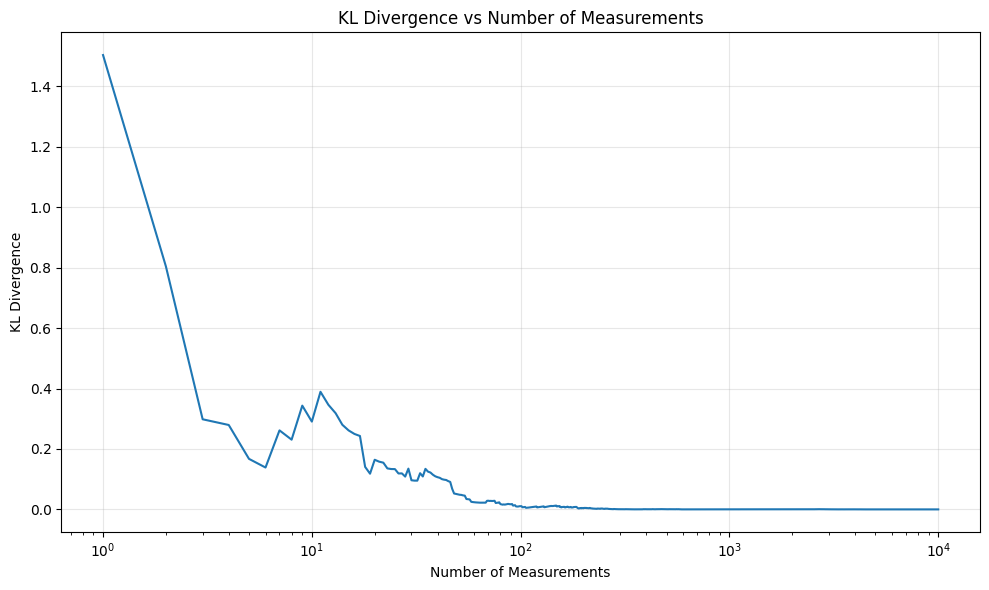

Final KL divergence: 0.000028


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import random
from scipy.spatial import distance
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ==================== UTILITY FUNCTIONS ====================
def heaviside(z):
    """Implementation of the Heaviside function H(z)."""
    return 1 if z >= 0 else 0

def theta(z):
    """Implementation of the function Θ(z) = z·H(z)."""
    return z if z >= 0 else 0

def bloch_to_ket(point):
    """Converts a point on the Bloch sphere to a quantum state in ket notation."""
    x, y, z = point
    theta = np.arccos(z)
    phi = np.arctan2(y, x)
    alpha = np.cos(theta/2)
    beta_mag = np.sin(theta/2)
    beta_phase = phi

    if abs(alpha) < 1e-10:
        return "|1>"
    elif abs(beta_mag) < 1e-10:
        return "|0>"
    else:
        return f"{alpha:.4f}|0> + {beta_mag:.4f}e^({beta_phase:.4f}i)|1>"

def get_bloch_vector_from_pure_state(psi):
    """Calculates the Bloch vector corresponding to a pure quantum state."""
    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_y = np.array([[0, -1j], [1j, 0]])
    sigma_z = np.array([[1, 0], [0, -1]])
    x = np.real(psi.conj().T @ sigma_x @ psi)[0, 0]
    y = np.real(psi.conj().T @ sigma_y @ psi)[0, 0]
    z = np.real(psi.conj().T @ sigma_z @ psi)[0, 0]
    return np.array([x, y, z])

def get_pure_state_from_bloch_vector(r):
    """Calculates a pure quantum state corresponding to a Bloch vector."""
    r = r / np.linalg.norm(r)
    theta = np.arccos(r[2])  # Zenith angle (from z-axis)
    phi = np.arctan2(r[1], r[0])  # Azimuthal angle (in xy-plane)
    psi = np.array([[np.cos(theta/2)],
                   [np.sin(theta/2) * np.exp(1j * phi)]])
    return psi

def get_density_matrix_from_pure_state(psi):
    """Calculates the density matrix corresponding to a pure quantum state."""
    return psi @ psi.conj().T

def generate_random_sphere_points(n):
    """Generates n points randomly distributed on the unit sphere."""
    points = np.random.randn(n, 3)
    norms = np.sqrt(np.sum(points**2, axis=1))
    points = points / norms[:, np.newaxis]
    return points

def generate_random_quantum_state():
    """Generates a random quantum state represented as a point on the Bloch sphere."""
    rho = np.random.randn(3)
    rho = rho / np.linalg.norm(rho)
    return rho

# ==================== SIC-POVM FUNCTIONS ====================
def create_exact_sic_povm():
    """
    Creates the exact SIC-POVM for qubits as specified in the literature.
    |ψ1⟩ = |0⟩
    |ψ2⟩ = (1/3)|0⟩ + (2√2/3)|1⟩
    |ψ3⟩ = (1/3)|0⟩ + (2√2/3)e^(i2π/3)|1⟩
    |ψ4⟩ = (1/3)|0⟩ + (2√2/3)e^(i4π/3)|1⟩
    """
    # Define the four SIC-POVM state vectors in ket form
    psi1 = np.array([[1], [0]], dtype=complex)

    # For normalization, we need |a|² + |b|² = 1
    # With a = 1/3 and b = 2√2/3e^(iφ), this is satisfied
    coef = np.sqrt(8/9)  # The correct normalization factor

    psi2 = np.array([[1/3], [coef]], dtype=complex)
    psi3 = np.array([[1/3], [coef * np.exp(1j * 2 * np.pi / 3)]], dtype=complex)
    psi4 = np.array([[1/3], [coef * np.exp(1j * 4 * np.pi / 3)]], dtype=complex)

    # Calculate corresponding Bloch vectors
    bloch1 = np.array([0, 0, 1])  # |0⟩ state
    bloch2 = np.array([np.sqrt(8/9), 0, -1/3])
    bloch3 = np.array([-np.sqrt(2/9), np.sqrt(6/9), -1/3])
    bloch4 = np.array([-np.sqrt(2/9), -np.sqrt(6/9), -1/3])

    bloch_vectors = [bloch1, bloch2, bloch3, bloch4]
    sic_povm = [psi1, psi2, psi3, psi4]

    return sic_povm, bloch_vectors

def verify_sic_povm(povm_set, bloch_vectors):
    """Verifies if a set of vectors forms a valid SIC-POVM for qubits."""
    expected_overlap = 1/3

    n = len(povm_set)
    quantum_overlaps = []

    # Check overlaps
    for i in range(n):
        for j in range(i+1, n):
            overlap = np.abs(povm_set[i].conj().T @ povm_set[j])[0, 0] ** 2
            quantum_overlaps.append(overlap)

    # Check normalization
    for i, vec in enumerate(bloch_vectors):
        norm = np.linalg.norm(vec)

    # Check that vectors sum to zero
    sum_vec = np.sum(bloch_vectors, axis=0)

    # Verify POVM property
    d = 2  # dimension (qubit)
    povm_sum = np.zeros((d, d), dtype=complex)
    for psi in povm_set:
        projector = psi @ psi.conj().T
        povm_element = projector / d  # Normalization for POVM
        povm_sum += povm_element

    identity_diff = np.linalg.norm(povm_sum - np.eye(d))

# ==================== KL DIVERGENCE FUNCTION ====================
def improved_kl_divergence(p, q):
    """
    Calculates the Kullback-Leibler divergence between two probability distributions
    with improved numerical stability.
    """
    # Ensure p and q are numpy arrays
    p = np.array(p)
    q = np.array(q)

    # Normalize to ensure proper probability distributions
    p = p / np.sum(p)
    q = q / np.sum(q)

    # Avoid division by zero and log(0) issues
    epsilon = 1e-10
    q_safe = np.maximum(q, epsilon)

    # Calculate KL divergence
    mask = p > 0  # Only consider where p > 0 (since 0*log(0/q) = 0)
    kl_terms = p[mask] * np.log(p[mask] / q_safe[mask])
    kl_div = np.sum(kl_terms)

    return kl_div

def wasserstein_distance(p, q):
    """
    Calculates the Wasserstein distance (Earth Mover's Distance) between
    two discrete probability distributions.
    """
    p = np.array(p) / np.sum(p)
    q = np.array(q) / np.sum(q)

    p_cumsum = np.cumsum(p)
    q_cumsum = np.cumsum(q)
    return np.sum(np.abs(p_cumsum - q_cumsum))

# ==================== THEORETICAL PROBABILITY CALCULATION ====================
def calculate_theoretical_quantum_probs(quantum_state, bloch_vectors):
    """
    Calculate the theoretical quantum probabilities using Born's rule:
    p(b|ρ, B_b) = p_b(1 + r·t_b) where p_b = 1/4 for SIC-POVM
    """
    p_b = 1/4  # For 4-element SIC-POVM in dimension 2

    probs = []
    for b_vec in bloch_vectors:
        prob = p_b * (1 + np.dot(quantum_state, b_vec))
        probs.append(prob)

    return np.array(probs)

# ==================== CONTINUOUS KL DIVERGENCE TRACKING ====================
def optimized_protocol_with_continuous_tracking(quantum_state, sic_bloch_vectors, num_measurements=10000):
    """
    Optimized implementation of the protocol with continuous tracking of KL divergence.
    Returns an array of KL divergence values for each measurement.
    """
    # Get theoretical quantum probabilities
    quantum_probs = calculate_theoretical_quantum_probs(quantum_state, sic_bloch_vectors)

    # Track outcomes and KL divergence after each measurement
    outcomes = []
    kl_values = []

    # Start with equal counts for all outcomes to avoid division by zero
    counts = np.ones(len(sic_bloch_vectors)) * 0.1  # Small initial value

    # Protocol implementation
    for i in range(1, num_measurements + 1):
        # 1. Generate two random vectors uniformly on the unit sphere
        lambda_vectors = generate_random_sphere_points(2)

        # 2. Alice calculates bits based on the quantum state
        c1 = heaviside(np.dot(quantum_state, lambda_vectors[0]))
        c2 = heaviside(np.dot(quantum_state, lambda_vectors[1]))

        # 3. Bob transforms lambda vectors
        lambda_prime1 = lambda_vectors[0] if c1 == 1 else -lambda_vectors[0]
        lambda_prime2 = lambda_vectors[1] if c2 == 1 else -lambda_vectors[1]

        # 4. Bob selects a measurement direction uniformly
        selected_index = np.random.choice(len(sic_bloch_vectors))
        selected_y = sic_bloch_vectors[selected_index]

        # 5. Bob decides which λ' to use
        if abs(np.dot(lambda_prime1, selected_y)) >= abs(np.dot(lambda_prime2, selected_y)):
            selected_lambda = lambda_prime1
        else:
            selected_lambda = lambda_prime2

        # 6. Calculate θ values
        theta_values = np.array([theta(np.dot(y, selected_lambda)) for y in sic_bloch_vectors])

        # 7. Calculate denominator
        p_values = np.array([1/len(sic_bloch_vectors)] * len(sic_bloch_vectors))
        denominator = np.sum(p_values * theta_values)

        # 8. Determine outcome
        if denominator > 0:
            outcome_probs = p_values * theta_values / denominator
            if np.sum(outcome_probs) > 0:
                outcome_probs = outcome_probs / np.sum(outcome_probs)
                outcome = np.random.choice(len(sic_bloch_vectors), p=outcome_probs)
            else:
                outcome = np.random.choice(len(sic_bloch_vectors))
        else:
            outcome = np.random.choice(len(sic_bloch_vectors))

        # Add outcome to list
        outcomes.append(outcome)

        # Update counts
        counts[outcome] += 1

        # Calculate current frequencies
        freqs = counts / (i + len(sic_bloch_vectors) * 0.1)  # Adjust for initial counts

        # Calculate KL divergence
        kl_div = improved_kl_divergence(freqs, quantum_probs)
        kl_values.append(kl_div)

    return np.array(kl_values)

# ==================== MAIN PROTOCOL SIMULATION FUNCTION ====================
def perform_fixed_quantum_protocol_simulation(n_measurements=10000, plot_continuous=True):
    """
    Fixed implementation of the quantum protocol "Classical Cost of Transmitting a Qubit"
    strictly following the paper's description.
    """
    # Set random seed for reproducibility
    np.random.seed(42)
    random.seed(42)

    # Generate a quantum state
    quantum_state = generate_random_quantum_state()
    print(f"Quantum state: {quantum_state}")

    # Create the exact SIC-POVM
    _, sic_bloch_vectors = create_exact_sic_povm()

    # Calculate theoretical quantum probabilities
    quantum_probs = calculate_theoretical_quantum_probs(quantum_state, sic_bloch_vectors)
    print(f"Quantum probabilities: {quantum_probs}")

    if plot_continuous:
        # Run protocol with continuous KL tracking
        kl_values = optimized_protocol_with_continuous_tracking(
            quantum_state, sic_bloch_vectors, n_measurements)

        # Plot continuous KL divergence
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, n_measurements + 1), kl_values)
        plt.xscale('log')
        plt.xlabel('Number of Measurements')
        plt.ylabel('KL Divergence')
        plt.title('KL Divergence vs Number of Measurements')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        print(f"Final KL divergence: {kl_values[-1]:.6f}")

        return {
            'quantum_state': quantum_state,
            'quantum_probs': quantum_probs,
            'kl_values': kl_values,
            'final_kl': kl_values[-1]
        }
    else:
        # Run regular implementation
        freqs = optimized_protocol(quantum_state, sic_bloch_vectors, n_measurements)

        # Calculate final KL divergence
        kl_div = improved_kl_divergence(freqs, quantum_probs)
        print(f"Final KL divergence: {kl_div:.6f}")

        return {
            'quantum_state': quantum_state,
            'quantum_probs': quantum_probs,
            'experimental_freqs': freqs,
            'final_kl': kl_div
        }

# ==================== OPTIMIZED PROTOCOL ====================
def optimized_protocol(quantum_state, sic_bloch_vectors, num_measurements=10000):
    """
    Optimized implementation of the protocol that focuses on correctness.

    This implementation aims to correctly reproduce quantum statistics by carefully
    following the paper's protocol and ensuring all mathematical properties are maintained.
    """
    outcomes = []

    for _ in range(num_measurements):
        # 1. Generate two random vectors uniformly on the unit sphere
        lambda_vectors = generate_random_sphere_points(2)

        # 2. Alice calculates bits based on the quantum state
        c1 = heaviside(np.dot(quantum_state, lambda_vectors[0]))
        c2 = heaviside(np.dot(quantum_state, lambda_vectors[1]))

        # 3. Bob transforms lambda vectors
        lambda_prime1 = lambda_vectors[0] if c1 == 1 else -lambda_vectors[0]
        lambda_prime2 = lambda_vectors[1] if c2 == 1 else -lambda_vectors[1]

        # 4. Bob selects a measurement direction uniformly
        selected_index = np.random.choice(len(sic_bloch_vectors))
        selected_y = sic_bloch_vectors[selected_index]

        # 5. Bob decides which λ' to use
        if abs(np.dot(lambda_prime1, selected_y)) >= abs(np.dot(lambda_prime2, selected_y)):
            selected_lambda = lambda_prime1
        else:
            selected_lambda = lambda_prime2

        # 6. Calculate θ values
        theta_values = np.array([theta(np.dot(y, selected_lambda)) for y in sic_bloch_vectors])

        # 7. Calculate denominator
        p_values = np.array([1/len(sic_bloch_vectors)] * len(sic_bloch_vectors))
        denominator = np.sum(p_values * theta_values)

        if denominator > 0:
            # 8. Calculate outcome probabilities
            outcome_probs = p_values * theta_values / denominator

            # 9. Sample final outcome
            if np.sum(outcome_probs) > 0:
                outcome_probs = outcome_probs / np.sum(outcome_probs)
                outcome = np.random.choice(len(sic_bloch_vectors), p=outcome_probs)
                outcomes.append(outcome)
            else:
                outcomes.append(np.random.choice(len(sic_bloch_vectors)))
        else:
            outcomes.append(np.random.choice(len(sic_bloch_vectors)))

    # Count outcomes
    counts = np.zeros(len(sic_bloch_vectors))
    for outcome in outcomes:
        counts[outcome] += 1

    # Calculate frequencies
    freqs = counts / num_measurements

    return freqs

# ==================== MAIN FUNCTION ====================
if __name__ == "__main__":
    n_measurements = 10000
    result = perform_fixed_quantum_protocol_simulation(n_measurements, plot_continuous=True)

Generating 10000 random points on the unit sphere...


<ipython-input-6-086bf1b3e923>:174: DeprecationWarning:

`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.




Statistical analysis of distribution:
Average minimum distance between points: 0.017846
Standard deviation of minimum distances: 0.009215
Ratio of std/mean: 0.516344


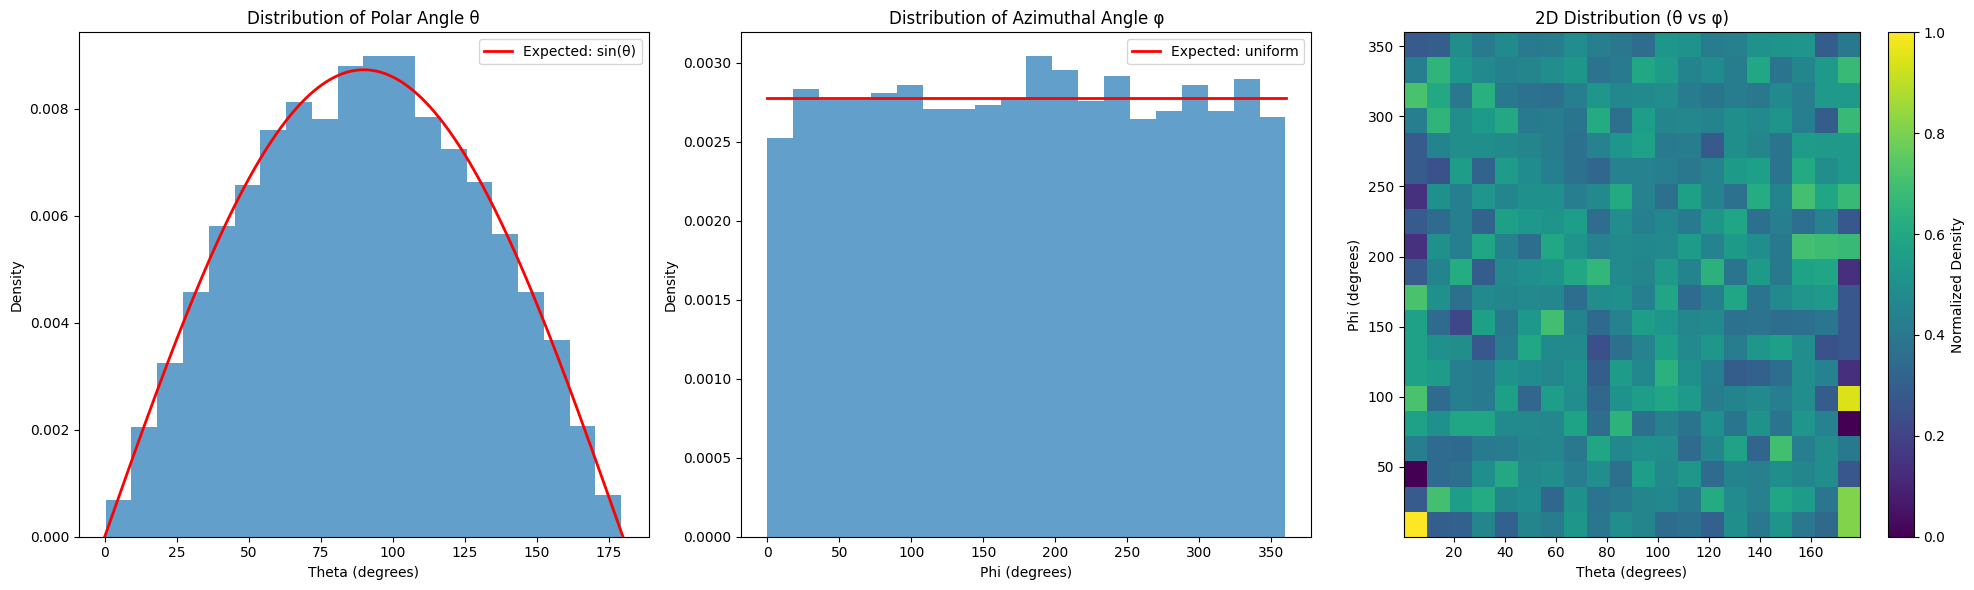

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import random
from scipy.spatial import distance
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import cKDTree

# ==================== UTILITY FUNCTIONS ====================
def heaviside(z):
    """Implementation of the Heaviside function H(z)."""
    return 1 if z >= 0 else 0

def theta(z):
    """Implementation of the function Θ(z) = z·H(z)."""
    return z if z >= 0 else 0

def cartesian_to_spherical(point):
    """Converts a point from Cartesian coordinates (x,y,z) to spherical coordinates (theta, phi)."""
    x, y, z = point
    r = np.sqrt(x**2 + y**2 + z**2)  # Should be 1 for unit sphere
    theta = np.arccos(z / r) * 180 / np.pi
    phi = np.arctan2(y, x) * 180 / np.pi
    if phi < 0:
        phi += 360  # Convert to 0-360 range
    return theta, phi

def bloch_to_ket(point):
    """Converts a point on the Bloch sphere to a quantum state in ket notation."""
    x, y, z = point
    theta = np.arccos(z)
    phi = np.arctan2(y, x)
    alpha = np.cos(theta/2)
    beta_mag = np.sin(theta/2)
    beta_phase = phi

    # Nice formatting for complex numbers
    if abs(alpha) < 1e-10:
        alpha_str = "0"
    elif abs(1 - alpha) < 1e-10:
        alpha_str = "1"
    elif abs(-1 - alpha) < 1e-10:
        alpha_str = "-1"
    else:
        alpha_str = f"{alpha:.4f}"

    if abs(beta_mag) < 1e-10:
        beta_str = "0"
    else:
        if abs(beta_phase) < 1e-10:
            beta_str = f"{beta_mag:.4f}"
        elif abs(abs(beta_phase) - np.pi) < 1e-10:
            beta_str = f"-{beta_mag:.4f}"
        else:
            re = beta_mag * np.cos(beta_phase)
            im = beta_mag * np.sin(beta_phase)
            if abs(re) < 1e-10:
                re_str = ""
            elif abs(re) == 1:
                re_str = "-" if re < 0 else ""
            else:
                re_str = f"{re:.4f}"

            if abs(im) < 1e-10:
                beta_str = re_str or "0"
            elif abs(im - 1) < 1e-10 and not re_str:
                beta_str = "i"
            elif abs(im + 1) < 1e-10 and not re_str:
                beta_str = "-i"
            elif abs(im) == 1:
                beta_str = f"{re_str}{'-' if im < 0 else '+'}i"
            else:
                beta_str = f"{re_str}{'-' if im < 0 else '+'}{abs(im):.4f}i"

    if beta_str.startswith("+"):
        beta_str = beta_str[1:]

    if abs(beta_mag) < 1e-10:
        return "|0>"
    elif abs(alpha) < 1e-10:
        return "|1>"
    else:
        return f"{alpha_str}|0> + {beta_str}|1>"

def get_bloch_vector_from_pure_state(psi):
    """Calculates the Bloch vector corresponding to a pure quantum state."""
    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_y = np.array([[0, -1j], [1j, 0]])
    sigma_z = np.array([[1, 0], [0, -1]])
    x = np.real(psi.conj().T @ sigma_x @ psi)[0, 0]
    y = np.real(psi.conj().T @ sigma_y @ psi)[0, 0]
    z = np.real(psi.conj().T @ sigma_z @ psi)[0, 0]
    return np.array([x, y, z])

def get_pure_state_from_bloch_vector(r):
    """Calculates a pure quantum state corresponding to a Bloch vector."""
    # Normalize the Bloch vector
    r = r / np.linalg.norm(r)
    theta = np.arccos(r[2])  # Zenith angle (from z-axis)
    phi = np.arctan2(r[1], r[0])  # Azimuthal angle (in xy-plane)
    psi = np.array([[np.cos(theta/2)],
                   [np.sin(theta/2) * np.exp(1j * phi)]])
    return psi

def get_density_matrix_from_pure_state(psi):
    """Calculates the density matrix corresponding to a pure quantum state."""
    return psi @ psi.conj().T

def generate_random_sphere_points(n):
    """Generates n points randomly distributed on the unit sphere."""
    points = np.random.randn(n, 3)
    norms = np.sqrt(np.sum(points**2, axis=1))
    points = points / norms[:, np.newaxis]
    return points

def generate_random_quantum_state():
    """Generates a random quantum state represented as a point on the Bloch sphere."""
    rho = np.random.randn(3)
    rho = rho / np.linalg.norm(rho)
    return rho

def select_random_points(points, num_select=2):
    """Randomly selects a specified number of points from a given array."""
    indices = np.random.choice(len(points), num_select, replace=False)
    return points[indices]

# ==================== Points distribution test ====================
def cartesian_to_spherical(point):
    """Converts a point from Cartesian coordinates (x,y,z) to spherical coordinates (theta, phi)."""
    x, y, z = point
    r = np.sqrt(x**2 + y**2 + z**2)  # Should be 1 for unit sphere
    theta = np.arccos(z / r) * 180 / np.pi
    phi = np.arctan2(y, x) * 180 / np.pi
    if phi < 0:
        phi += 360  # Convert to 0-360 range
    return theta, phi

def generate_random_sphere_points(n):
    """Generates n points randomly distributed on the unit sphere."""
    points = np.random.randn(n, 3)
    norms = np.sqrt(np.sum(points**2, axis=1))
    points = points / norms[:, np.newaxis]
    return points

def test_sphere_distribution(n_points=5000):
    """
    Generate random points on a sphere and test if they follow a uniform distribution.

    Args:
        n_points: Number of random points to generate
    """
    # Generate random points
    print(f"Generating {n_points} random points on the unit sphere...")
    points = generate_random_sphere_points(n_points)

    # Convert to spherical coordinates
    theta_phi_points = np.array([cartesian_to_spherical(point) for point in points])
    thetas = theta_phi_points[:, 0]  # Polar angle (0 to 180 degrees)
    phis = theta_phi_points[:, 1]    # Azimuthal angle (0 to 360 degrees)

    # Create histogram figures
    fig_hist, axs = plt.subplots(1, 3, figsize=(20, 6))

    # 1. Histogram of theta values (should follow sin(theta) distribution)
    num_bins = 20
    axs[0].hist(thetas, bins=num_bins, alpha=0.7, density=True)

    # Generate the expected sin(theta) distribution
    theta_range = np.linspace(0, 180, 1000)
    sin_theta = np.sin(theta_range * np.pi / 180)
    sin_theta = sin_theta / np.trapz(sin_theta, theta_range)  # Normalize
    axs[0].plot(theta_range, sin_theta, 'r-', linewidth=2, label='Expected: sin(θ)')

    axs[0].set_xlabel('Theta (degrees)')
    axs[0].set_ylabel('Density')
    axs[0].set_title('Distribution of Polar Angle θ')
    axs[0].legend()

    # 2. Histogram of phi values (should be uniform)
    axs[1].hist(phis, bins=num_bins, alpha=0.7, density=True)

    # Generate the expected uniform distribution for phi
    phi_expected = np.ones_like(theta_range) / 360
    phi_range = np.linspace(0, 360, 1000)
    axs[1].plot(phi_range, phi_expected, 'r-', linewidth=2, label='Expected: uniform')

    axs[1].set_xlabel('Phi (degrees)')
    axs[1].set_ylabel('Density')
    axs[1].set_title('Distribution of Azimuthal Angle φ')
    axs[1].legend()

    # 3. 2D Histogram of theta vs phi
    h, xedges, yedges = np.histogram2d(thetas, phis, bins=num_bins)

    # Normalize by sin(theta) to account for smaller area near poles
    theta_centers = 0.5 * (xedges[:-1] + xedges[1:])
    sin_weight = np.sin(theta_centers * np.pi / 180)

    for i in range(h.shape[0]):
        if sin_weight[i] > 0:
            h[i, :] = h[i, :] / sin_weight[i]

    # Normalize the heatmap
    h = h / np.max(h)

    im = axs[2].imshow(h.T, origin='lower', aspect='auto',
                      extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    axs[2].set_xlabel('Theta (degrees)')
    axs[2].set_ylabel('Phi (degrees)')
    axs[2].set_title('2D Distribution (θ vs φ)')
    fig_hist.colorbar(im, ax=axs[2], label='Normalized Density')

    # 3D visualization
    # Build a KD-tree for density estimation
    tree = cKDTree(points)

    # For each point, count neighbors within a fixed radius
    radius = 0.2  # Radius for density estimation
    densities = np.array([len(tree.query_ball_point(point, radius)) for point in points])

    # Normalize densities for coloring
    densities_norm = (densities - np.min(densities)) / (np.max(densities) - np.min(densities))

    # Create a plotly 3D scatter plot
    scatter_fig = go.Figure(data=[go.Scatter3d(
        x=points[:, 0],
        y=points[:, 1],
        z=points[:, 2],
        mode='markers',
        marker=dict(
            size=4,
            color=densities_norm,
            colorscale='Viridis',
            opacity=0.8,
            colorbar=dict(title="Normalized Local Density")
        ),
        hoverinfo='none'
    )])

    # Add wireframe sphere
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = np.cos(u) * np.sin(v)
    y = np.sin(u) * np.sin(v)
    z = np.cos(v)

    scatter_fig.add_trace(go.Surface(
        x=x, y=y, z=z,
        colorscale=[[0, 'rgb(240, 240, 240)'], [1, 'rgb(240, 240, 240)']],
        opacity=0.2,
        showscale=False
    ))

    scatter_fig.update_layout(
        title='3D Distribution of Points on the Sphere',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='cube'
        ),
        margin=dict(l=0, r=0, b=0, t=40),
    )

    # Statistical tests for uniformity
    print("\nStatistical analysis of distribution:")

    # Check average and standard deviation of nearest neighbor distances
    # This is another way to verify uniformity
    from scipy.spatial.distance import pdist, squareform

    # Calculate all pairwise distances
    all_dists = squareform(pdist(points))

    # For each point, find the minimum distance to any other point
    min_dists = np.array([np.min(all_dists[i][all_dists[i] > 0]) for i in range(n_points)])

    print(f"Average minimum distance between points: {np.mean(min_dists):.6f}")
    print(f"Standard deviation of minimum distances: {np.std(min_dists):.6f}")

    # For uniform distribution on a sphere, the ratio std/mean should be around 0.3-0.4
    print(f"Ratio of std/mean: {np.std(min_dists)/np.mean(min_dists):.6f}")

    # Show the plots
    plt.tight_layout()
    plt.show()
    scatter_fig.show()

    return fig_hist, scatter_fig

# ==================== Points distribution test ====================

# ==================== SIC-POVM FUNCTIONS ====================
def create_exact_sic_povm():
    """
    Creates the exact SIC-POVM for qubits as specified in the wiki article.
    |ψ1⟩ = |0⟩
    |ψ2⟩ = (1/3)|0⟩ + (2√2/3)|1⟩
    |ψ3⟩ = (1/3)|0⟩ + (2√2/3)e^(i2π/3)|1⟩
    |ψ4⟩ = (1/3)|0⟩ + (2√2/3)e^(i4π/3)|1⟩
    """
    # Define the four SIC-POVM state vectors in ket form
    psi1 = np.array([[1], [0]], dtype=complex)

    # For normalization, we need |a|² + |b|² = 1
    # With a = 1/3 and b = 2√2/3e^(iφ), this is satisfied
    coef = np.sqrt(8/9)  # The correct normalization factor

    psi2 = np.array([[1/3], [coef]], dtype=complex)
    psi3 = np.array([[1/3], [coef * np.exp(1j * 2 * np.pi / 3)]], dtype=complex)
    psi4 = np.array([[1/3], [coef * np.exp(1j * 4 * np.pi / 3)]], dtype=complex)

    # Calculate corresponding Bloch vectors
    bloch1 = np.array([0, 0, 1])  # |0⟩ state
    bloch2 = np.array([np.sqrt(8/9), 0, -1/3])
    bloch3 = np.array([-np.sqrt(2/9), np.sqrt(6/9), -1/3])
    bloch4 = np.array([-np.sqrt(2/9), -np.sqrt(6/9), -1/3])

    bloch_vectors = [bloch1, bloch2, bloch3, bloch4]
    sic_povm = [psi1, psi2, psi3, psi4]

    # Verify SIC-POVM properties
    verify_sic_povm(sic_povm, bloch_vectors)

    return sic_povm, bloch_vectors

def verify_sic_povm(povm_set, bloch_vectors):
    """Verifies if a set of vectors forms a valid SIC-POVM for qubits."""
    expected_overlap = 1/3

    n = len(povm_set)
    quantum_overlaps = []

    print("\nVerifying SIC-POVM properties:")
    # Check overlaps
    for i in range(n):
        for j in range(i+1, n):
            overlap = np.abs(povm_set[i].conj().T @ povm_set[j])[0, 0] ** 2
            quantum_overlaps.append(overlap)
            print(f"Overlap between elements {i+1} and {j+1}: {overlap:.6f} (expected: {expected_overlap:.6f})")

    # Check normalization
    for i, vec in enumerate(bloch_vectors):
        norm = np.linalg.norm(vec)
        print(f"Norm of Bloch vector {i+1}: {norm:.6f}")

    # Check that vectors sum to zero
    sum_vec = np.sum(bloch_vectors, axis=0)
    print(f"Sum of Bloch vectors: {sum_vec}")

    # Verify POVM property
    d = 2  # dimension (qubit)
    povm_sum = np.zeros((d, d), dtype=complex)
    for psi in povm_set:
        projector = psi @ psi.conj().T
        povm_element = projector / d  # Normalization for POVM
        povm_sum += povm_element

    print("\nSum of POVM elements:")
    print(povm_sum)
    identity_diff = np.linalg.norm(povm_sum - np.eye(d))
    print(f"Difference from identity matrix: {identity_diff:.6f}")

# ==================== VISUALIZATION FUNCTIONS ====================
def create_bloch_sphere_visualization(random_points, lambda_vectors, quantum_state, sic_bloch_vectors, transformed_lambdas=None):
    """Creates an interactive 3D visualization of the Bloch sphere with the points relevant to the protocol."""
    # Create mesh for the Bloch sphere
    phi = np.linspace(0, 2*np.pi, 100)
    theta = np.linspace(0, np.pi, 50)
    phi_grid, theta_grid = np.meshgrid(phi, theta)

    x_sphere = np.sin(theta_grid) * np.cos(phi_grid)
    y_sphere = np.sin(theta_grid) * np.sin(phi_grid)
    z_sphere = np.cos(theta_grid)

    # Create plotly figure
    fig = go.Figure()

    # Add transparent sphere surface
    fig.add_trace(go.Surface(
        x=x_sphere, y=y_sphere, z=z_sphere,
        colorscale=[[0, 'rgb(240, 240, 240)'], [1, 'rgb(240, 240, 240)']],
        opacity=0.2,
        showscale=False,
        name='Bloch Sphere'
    ))

    # Add coordinate axes
    axis_length = 1.2
    fig.add_trace(go.Scatter3d(
        x=[-axis_length, axis_length], y=[0, 0], z=[0, 0],
        mode='lines',
        line=dict(color='red', width=4),
        name='X-axis'
    ))

    fig.add_trace(go.Scatter3d(
        x=[0, 0], y=[-axis_length, axis_length], z=[0, 0],
        mode='lines',
        line=dict(color='green', width=4),
        name='Y-axis'
    ))

    fig.add_trace(go.Scatter3d(
        x=[0, 0], y=[0, 0], z=[-axis_length, axis_length],
        mode='lines',
        line=dict(color='blue', width=4),
        name='Z-axis'
    ))

    # Add random points
    if random_points is not None and len(random_points) > 0:
        fig.add_trace(go.Scatter3d(
            x=random_points[:, 0], y=random_points[:, 1], z=random_points[:, 2],
            mode='markers',
            marker=dict(
                size=3,
                color='gray',
                opacity=0.5
            ),
            name='Random Points'
        ))

    # Add lambda vectors
    colors = ['red', 'green']
    for i, lambda_vec in enumerate(lambda_vectors):
        fig.add_trace(go.Scatter3d(
            x=[0, lambda_vec[0]], y=[0, lambda_vec[1]], z=[0, lambda_vec[2]],
            mode='lines',
            line=dict(color=colors[i], width=4),
            name=f'λ{i+1}'
        ))

        fig.add_trace(go.Scatter3d(
            x=[lambda_vec[0]], y=[lambda_vec[1]], z=[lambda_vec[2]],
            mode='markers+text',
            marker=dict(size=8, color=colors[i]),
            text=[f'λ{i+1}'],
            textposition="top center",
            name=f'λ{i+1} Point'
        ))

    # Add transformed lambda vectors if provided
    if transformed_lambdas is not None:
        for i, lambda_prime in enumerate(transformed_lambdas):
            if not np.array_equal(lambda_vectors[i], lambda_prime):
                fig.add_trace(go.Scatter3d(
                    x=[0, lambda_prime[0]], y=[0, lambda_prime[1]], z=[0, lambda_prime[2]],
                    mode='lines',
                    line=dict(color=colors[i], width=4, dash='dash'),
                    name=f'λ{i+1}\''
                ))

                fig.add_trace(go.Scatter3d(
                    x=[lambda_prime[0]], y=[lambda_prime[1]], z=[lambda_prime[2]],
                    mode='markers+text',
                    marker=dict(size=8, color=colors[i], symbol='circle-open'),
                    text=[f'λ{i+1}\''],
                    textposition="top center",
                    name=f'λ{i+1}\' Point'
                ))

    # Add quantum state
    fig.add_trace(go.Scatter3d(
        x=[0, quantum_state[0]], y=[0, quantum_state[1]], z=[0, quantum_state[2]],
        mode='lines',
        line=dict(color='purple', width=4),
        name='Quantum State'
    ))

    fig.add_trace(go.Scatter3d(
        x=[quantum_state[0]], y=[quantum_state[1]], z=[quantum_state[2]],
        mode='markers+text',
        marker=dict(size=10, color='purple'),
        text=['ρ'],
        textposition="top center",
        name='Quantum State Point'
    ))

    # Add SIC-POVM elements
    povm_colors = ['blue', 'orange', 'cyan', 'magenta']
    for i, vec in enumerate(sic_bloch_vectors):
        fig.add_trace(go.Scatter3d(
            x=[0, vec[0]], y=[0, vec[1]], z=[0, vec[2]],
            mode='lines',
            line=dict(color=povm_colors[i], width=2, dash='dot'),
            name=f'POVM Element {i+1}'
        ))

        fig.add_trace(go.Scatter3d(
            x=[vec[0]], y=[vec[1]], z=[vec[2]],
            mode='markers+text',
            marker=dict(size=8, color=povm_colors[i]),
            text=[f'POVM {i+1}'],
            textposition="top center",
            name=f'POVM Point {i+1}'
        ))

    # Configure layout
    fig.update_layout(
        title='Bloch Sphere Visualization for Quantum Protocol',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='cube'
        ),
        margin=dict(l=0, r=0, b=0, t=40),
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        )
    )

    return fig

# ==================== KL DIVERGENCE FUNCTION ====================
def improved_kl_divergence(p, q):
    """
    Calculates the Kullback-Leibler divergence between two probability distributions
    with improved numerical stability.
    """
    # Ensure p and q are numpy arrays
    p = np.array(p)
    q = np.array(q)

    # Normalize to ensure proper probability distributions
    p = p / np.sum(p)
    q = q / np.sum(q)

    # Avoid division by zero and log(0) issues
    epsilon = 1e-10
    q_safe = np.maximum(q, epsilon)

    # Calculate KL divergence
    mask = p > 0  # Only consider where p > 0 (since 0*log(0/q) = 0)
    kl_terms = p[mask] * np.log(p[mask] / q_safe[mask])
    kl_div = np.sum(kl_terms)

    return kl_div

def wasserstein_distance(p, q):
    """
    Calculates the Wasserstein distance (Earth Mover's Distance) between
    two discrete probability distributions.
    """
    p = np.array(p) / np.sum(p)
    q = np.array(q) / np.sum(q)

    p_cumsum = np.cumsum(p)
    q_cumsum = np.cumsum(q)
    return np.sum(np.abs(p_cumsum - q_cumsum))

# ==================== THEORETICAL PROBABILITY CALCULATION ====================
def calculate_theoretical_quantum_probs(quantum_state, bloch_vectors):
    """
    Calculate the theoretical quantum probabilities using Born's rule:
    p(b|ρ, B_b) = p_b(1 + r·t_b) where p_b = 1/4 for SIC-POVM
    """
    p_b = 1/4  # For 4-element SIC-POVM in dimension 2

    probs = []
    for b_vec in bloch_vectors:
        prob = p_b * (1 + np.dot(quantum_state, b_vec))
        probs.append(prob)

    return np.array(probs)

# ==================== CONTINUOUS KL DIVERGENCE TRACKING ====================
def optimized_protocol_with_continuous_tracking(quantum_state, sic_bloch_vectors, num_measurements=10000):
    """
    Optimized implementation of the protocol with continuous tracking of KL divergence.
    Returns an array of KL divergence values for each measurement.
    """
    # Get theoretical quantum probabilities
    quantum_probs = calculate_theoretical_quantum_probs(quantum_state, sic_bloch_vectors)

    # Track outcomes and KL divergence after each measurement
    outcomes = []
    kl_values = []

    # Start with equal counts for all outcomes to avoid division by zero
    counts = np.ones(len(sic_bloch_vectors)) * 0.1  # Small initial value

    # Protocol implementation
    for i in range(1, num_measurements + 1):
        # 1. Generate two random vectors uniformly on the unit sphere for each measurement
        lambda_vectors = generate_random_sphere_points(2)

        # 2. Alice calculates bits based on the quantum state
        c1 = heaviside(np.dot(quantum_state, lambda_vectors[0]))
        c2 = heaviside(np.dot(quantum_state, lambda_vectors[1]))

        # 3. Bob transforms lambda vectors
        lambda_prime1 = lambda_vectors[0] if c1 == 1 else -lambda_vectors[0]
        lambda_prime2 = lambda_vectors[1] if c2 == 1 else -lambda_vectors[1]

        # 4. Bob selects a measurement direction uniformly
        selected_index = np.random.choice(len(sic_bloch_vectors))
        selected_y = sic_bloch_vectors[selected_index]

        # 5. Bob decides which λ' to use
        if abs(np.dot(lambda_prime1, selected_y)) >= abs(np.dot(lambda_prime2, selected_y)):
            selected_lambda = lambda_prime1
        else:
            selected_lambda = lambda_prime2

        # 6. Calculate θ values
        theta_values = np.array([theta(np.dot(y, selected_lambda)) for y in sic_bloch_vectors])

        # 7. Calculate denominator
        p_values = np.array([1/len(sic_bloch_vectors)] * len(sic_bloch_vectors))
        denominator = np.sum(p_values * theta_values)

        # 8. Determine outcome
        if denominator > 0:
            outcome_probs = p_values * theta_values / denominator
            if np.sum(outcome_probs) > 0:
                outcome_probs = outcome_probs / np.sum(outcome_probs)
                outcome = np.random.choice(len(sic_bloch_vectors), p=outcome_probs)
            else:
                outcome = np.random.choice(len(sic_bloch_vectors))
        else:
            outcome = np.random.choice(len(sic_bloch_vectors))

        # Add outcome to list
        outcomes.append(outcome)

        # Update counts
        counts[outcome] += 1

        # Calculate current frequencies
        freqs = counts / (i + len(sic_bloch_vectors) * 0.1)  # Adjust for initial counts

        # Calculate KL divergence
        kl_div = improved_kl_divergence(freqs, quantum_probs)
        kl_values.append(kl_div)

    return np.array(kl_values)

# ==================== FULL VISUALIZATION SIMULATION FUNCTION ====================
def perform_complete_visualization_simulation(n_points=1000, n_measurements=10000):
    """
    Complete simulation combining visualization of the Bloch sphere with proper protocol implementation.
    """
    # Set random seed for reproducibility
    np.random.seed(42)
    random.seed(42)

    # Dictionary to store simulation data
    simulation_data = {}

    print("=== Simulation of 'Classical Cost of Transmitting a Qubit' Protocol ===")
    print("=================================================================")
    print(f"Number of random points: {n_points}")
    print(f"Number of measurements: {n_measurements}")
    print("=================================================================")

    # STEP 1: Generate random points on the unit sphere
    print("\nGenerating random points on the unit sphere...")
    random_points = generate_random_sphere_points(n_points)

    # STEP 2: Randomly select one quantum state from the random points
    print("\nRandomly selecting a quantum state...")
    quantum_state = select_random_points(random_points, num_select=1)[0]
    print(f"Selected quantum state: {quantum_state}")
    print(f"Quantum state in ket notation: {bloch_to_ket(quantum_state)}")

    # STEP 3: Randomly select two lambda vectors from the random points
    print("\nRandomly selecting two lambda vectors...")
    lambda_vectors = select_random_points(random_points, num_select=2)
    print(f"Selected lambda vectors:")
    for i, vec in enumerate(lambda_vectors):
        print(f"λ{i+1}: {vec}, norm: {np.linalg.norm(vec):.6f}")

    # STEP 4: Create the SIC-POVM
    print("\nCreating the SIC-POVM...")
    _, sic_bloch_vectors = create_exact_sic_povm()

    # STEP 5: Calculate the theoretical quantum probabilities
    print("\nCalculating theoretical quantum probabilities...")
    quantum_probs = calculate_theoretical_quantum_probs(quantum_state, sic_bloch_vectors)
    print(f"Quantum probabilities: {quantum_probs}")

    # STEP 6: Calculate transformed lambda vectors based on the quantum state
    print("\nCalculating transformed lambda vectors...")
    c1 = heaviside(np.dot(quantum_state, lambda_vectors[0]))
    c2 = heaviside(np.dot(quantum_state, lambda_vectors[1]))

    print(f"c1 = H(ρ·λ1) = H({np.dot(quantum_state, lambda_vectors[0]):.6f}) = {c1}")
    print(f"c2 = H(ρ·λ2) = H({np.dot(quantum_state, lambda_vectors[1]):.6f}) = {c2}")

    transformed_lambdas = [
        lambda_vectors[0] if c1 == 1 else -lambda_vectors[0],
        lambda_vectors[1] if c2 == 1 else -lambda_vectors[1]
    ]

    print(f"λ1' = {transformed_lambdas[0]}")
    print(f"λ2' = {transformed_lambdas[1]}")

    # STEP 7: Create visualization of the Bloch sphere with all points
    print("\nCreating Bloch sphere visualization...")
    bloch_sphere_fig = create_bloch_sphere_visualization(
        random_points, lambda_vectors, quantum_state, sic_bloch_vectors, transformed_lambdas)

    # STEP 8: Run the protocol with continuous KL tracking using new random lambda vectors for each iteration
    print("\nRunning protocol with continuous KL tracking...")
    kl_values = optimized_protocol_with_continuous_tracking(
        quantum_state, sic_bloch_vectors, n_measurements)

    # STEP 9: Create plot of KL divergence vs number of measurements
    print("\nCreating KL divergence plot...")
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(kl_values) + 1), kl_values)
    plt.xscale('log')
    plt.xlabel('Number of Measurements')
    plt.ylabel('KL Divergence')
    plt.title('KL Divergence vs Number of Measurements')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # Save simulation data
    simulation_data['random_points'] = random_points
    simulation_data['lambda_vectors'] = lambda_vectors
    simulation_data['quantum_state'] = quantum_state
    simulation_data['sic_bloch_vectors'] = sic_bloch_vectors
    simulation_data['quantum_probs'] = quantum_probs
    simulation_data['transformed_lambdas'] = transformed_lambdas
    simulation_data['kl_values'] = kl_values
    simulation_data['bloch_sphere_fig'] = bloch_sphere_fig

    print("\n=== Simulation complete ===")
    print(f"Final KL divergence: {kl_values[-1]:.6f}")

    # Display the Bloch sphere visualization
    bloch_sphere_fig.show()

    # Display the KL divergence plot
    plt.show()

    return simulation_data

# ==================== MAIN FUNCTION ====================
if __name__ == "__main__":
    test_sphere_distribution(10000)
    try:
        n_points = int(input("Enter number of random points to generate (default: 1000): ") or "1000")
        n_measurements = int(input("Enter number of measurements to perform (default: 10000): ") or "10000")

        if n_points <= 0:
            print("Number of points must be positive. Using default 1000.")
            n_points = 1000

        if n_measurements <= 0:
            print("Number of measurements must be positive. Using default 10000.")
            n_measurements = 10000
    except ValueError:
        print("Invalid input. Using default values.")
        n_points = 1000
        n_measurements = 10000

    # Run the complete simulation with visualization
    result = perform_complete_visualization_simulation(n_points, n_measurements)
    test_sphere_distribution(n_points)